In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import socket, struct
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import f1_score

pd.set_option('display.max_columns', 500)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
%pip install pyarrow
%pip install fastparquet

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Data exploration and processing

##### Carregamento dos dados

In [3]:
df = pd.read_parquet('subset.gzip')

In [3]:
df_nf = pd.read_parquet('merged_nf.gzip')
df_simargl = pd.read_parquet('merged_simargl.gzip')


In [30]:
df_subset = pd.concat([df[df.Label == 0].sample(300000), df[df.Label == 1].sample(300000)])
df_subset.to_parquet('subset.gzip')
df = df_subset

In [21]:
print("This dataset has {} columns and {} rows".format(df.shape[1],df.shape[0]))

This dataset has 25 columns and 600000 rows


##### Describe object (string) columns

In [64]:
df_simargl

DST_TO_SRC_SECOND_BYTES  \
0                                                       40   
1                                                        ,   
2                                                      104   
3                                                        ,   
4                                                       40   
...                                                    ...   
1330687  199,,100,100,199,100,100,100,,199,100,100,199,...   
1330688  176,,,,,,,,,,,,,,,88,,,,,,,,,,,,,,,168,,,,,,,,...   
1330689  52,,,,,,,,,,,52,,,,,,,,,,52,,,,,,,,,,52,,52,,,...   
1330690  40,,,,,,,856,,,,,,,,,,,,,,,,,,,,,,,80,,,,,,,85...   
1330691  2724,,,,,,,,,,,,,,,48,,,,,978,,,,,,,,,,,,956,,...   

         FLOW_DURATION_MILLISECONDS  IN_BYTES  IN_PKTS   IPV4_DST_ADDR  \
0                                 0        44        1  10.114.225.212   
1                                 0        68        1  10.114.225.215   
2                                44       189        2  10.114.241.165   
3                                 0        52        1   10.114.226.23   
4                                 1       189        2   10.114.224.65   
...                             ...       ...      ...             ...   
1330687                      119273     97760      232   52.112.83.128   
1330688                      105054       976       16   10.114.241.99   
1330689                      112645       728       14  10.114.225.205   
1330690                       96349      3054       58  10.114.225.202   
1330691                      116558     16578       38  172.217.16.142   

           IPV4_SRC_ADDR  L4_DST_PORT  L4_SRC_PORT  MAX_IP_PKT_LEN  \
0        162.142.125.173        60541        22351               0   
1          45.79.106.170            0            0               0   
2          10.114.224.65        24650          443               0   
3          202.179.91.28         8728        61075               0   
4         10.114.241.165          443        39762               0   
...                  ...          ...          ...             ...   
1330687   10.114.225.205         3480        50053               0   
1330688   10.114.225.205           22        49308               0   
1330689   138.199.36.111        45549           80               0   
1330690     45.11.129.28        51875          443               0   
1330691   10.114.225.206          443        33790               0   

         MIN_IP_PKT_LEN  OUT_BYTES  OUT_PKTS  PROTOCOL PROTOCOL_MAP  \
0                     0         40         1         6          tcp   
1                     0          0         0         1         icmp   
2                     0        104         2         6          tcp   
3                     0          0         0         6          tcp   
4                     0         40         1         6          tcp   
...                 ...        ...       ...       ...          ...   
1330687               0      14057       138        17          udp   
1330688               0       1040        12         6          tcp   
1330689               0        728        14         6          tcp   
1330690               0       3704        51         6          tcp   
1330691               0       9141        45        17          udp   

         RETRANSMITTED_IN_BYTES  RETRANSMITTED_IN_PKTS  \
0                             0                      0   
1                             0                      0   
2                             0                      0   
3                             0                      0   
4                             0                      0   
...                         ...                    ...   
1330687                       0                      0   
1330688                       0                      0   
1330689                       0                      0   
1330690                       0                      0   
1330691                       0                      0   

         R

In [5]:
df_nf.head()

IPV4_SRC_ADDR  L4_SRC_PORT  IPV4_DST_ADDR  L4_DST_PORT  PROTOCOL  \
0  192.168.100.148        65389  192.168.100.7           80         6   
1  192.168.100.148        11154  192.168.100.5           80         6   
2     192.168.1.31        42062   192.168.1.79         1041         6   
3     192.168.1.34        46849   192.168.1.79         9110         6   
4     192.168.1.30        50360  192.168.1.152         1084         6   

   IN_BYTES  IN_PKTS  OUT_BYTES  OUT_PKTS  TCP_FLAGS  \
0       420        3          0         0          2   
1       280        2         40         1         22   
2        44        1         40         1         22   
3        44        1         40         1         22   
4        44        1         40         1         22   

   FLOW_DURATION_MILLISECONDS  MIN_IP_PKT_LEN  MAX_IP_PKT_LEN  \
0                     4293092               0             140   
1                     4294499              40             140   
2                           0              40              44   
3                           0              40              44   
4                           0              40              44   

   SRC_TO_DST_SECOND_BYTES  DST_TO_SRC_SECOND_BYTES  RETRANSMITTED_IN_BYTES  \
0                 140280.0                      0.0                     140   
1                    280.0                     40.0                       0   
2                     44.0                     40.0                       0   
3                     44.0                     40.0                       0   
4                     44.0                     40.0                       0   

   RETRANSMITTED_IN_PKTS  RETRANSMITTED_OUT_BYTES  RETRANSMITTED_OUT_PKTS  \
0                      1                        0                       0   
1                      0                        0                       0   
2                      0                        0                       0   
3                      0                        0                       0   
4                      0                        0                       0   

   TCP_WIN_MAX_IN  TCP_WIN_MAX_OUT  Label  Attack L7_PROTO_NAME PROTOCOL_MAP  
0             512                0      1     DoS           CBT          tcp  
1             512                0      1     DoS           CBT          tcp  
2            1024                0      0  Benign        HOPOPT          tcp  
3            1024                0      0  Benign        HOPOPT          tcp  
4            1024                0      0  Benign        HOPOPT          tcp

In [166]:
df.describe(include=[object])

IPV4_SRC_ADDR IPV4_DST_ADDR SRC_TO_DST_SECOND_BYTES  \
count          5001358       5001358                 5001358   
unique           42210        154059                  236852   
top     10.114.241.166  10.114.226.5                      44   
freq           2512625        434478                 2524868   

       DST_TO_SRC_SECOND_BYTES                 Attack L7_PROTO_NAME  \
count                  5001358                5001358       4976988   
unique                  225323                     23           450   
top                         40  SYN Scan - aggressive       Unknown   
freq                   2168095                2496814       2950884   

       PROTOCOL_MAP  
count       5001358  
unique            6  
top             tcp  
freq        3686630

##### Describe numerical columns

In [7]:
df_nf.describe()

L4_SRC_PORT   L4_DST_PORT      PROTOCOL      IN_BYTES       IN_PKTS  \
count  3.000000e+06  3.000000e+06  3.000000e+06  3.000000e+06  3.000000e+06   
mean   4.038722e+04  3.350640e+03  1.024170e+01  9.915695e+02  9.670526e+00   
std    1.842122e+04  1.068101e+04  5.654876e+00  8.326632e+04  5.763028e+02   
min    0.000000e+00  0.000000e+00  0.000000e+00  3.000000e+00  1.000000e+00   
25%    2.724000e+04  8.000000e+01  6.000000e+00  5.600000e+01  1.000000e+00   
50%    4.573000e+04  8.000000e+01  6.000000e+00  1.120000e+02  2.000000e+00   
75%    5.504500e+04  4.430000e+02  1.700000e+01  2.800000e+02  3.000000e+00   
max    6.553500e+04  6.553500e+04  2.550000e+02  7.405536e+07  1.926100e+05   

          OUT_BYTES      OUT_PKTS     TCP_FLAGS  FLOW_DURATION_MILLISECONDS  \
count  3.000000e+06  3.000000e+06  3.000000e+06                3.000000e+06   
mean   3.034575e+03  4.649585e+00  2.418990e+01                2.315053e+06   
std    2.536018e+05  1.928144e+02  5.845195e+01                2.140399e+06   
min    0.000000e+00  0.000000e+00  0.000000e+00                0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00                0.000000e+00   
50%    0.000000e+00  0.000000e+00  2.000000e+00                4.293061e+06   
75%    1.520000e+02  1.000000e+00  2.200000e+01                4.294029e+06   
max    1.554980e+08  1.045650e+05  2.230000e+02                4.294967e+06   

       MIN_IP_PKT_LEN  MAX_IP_PKT_LEN  SRC_TO_DST_SECOND_BYTES  \
count    3.000000e+06    3.000000e+06             3.000000e+06   
mean     2.356534e+01    2.649258e+02            2.196007e+298   
std      2.696914e+01    4.320319e+02                      inf   
min      0.000000e+00    2.800000e+01             0.000000e+00   
25%      0.000000e+00    4.000000e+01             6.800000e+01   
50%      0.000000e+00    1.000000e+02             1.408000e+03   
75%      4.000000e+01    1.400000e+02             3.806000e+03   
max      5.470000e+02    6.521200e+04            6.588022e+304   

       DST_TO_SRC_SECOND_BYTES  RETRANSMITTED_IN_BYTES  RETRANSMITTED_IN_PKTS  \
count             3.000000e+06            3.000000e+06           3.000000e+06   
mean             1.386680e+151            8.017808e+01           3.958197e-01   
std                        inf            6.931635e+03           1.240083e+01   
min               0.000000e+00            0.000000e+00           0.000000e+00   
25%               0.000000e+00            0.000000e+00           0.000000e+00   
50%               0.000000e+00            0.000000e+00           0.000000e+00   
75%               1.640000e+02            0.000000e+00           0.000000e+00   
max              4.160041e+157            6.321251e+06           1.272900e+04   

       RETRANSMITTED_OUT_BYTES  RETRANSMITTED_OUT_PKTS  TCP_WIN_MAX_IN  \
count             3.000000e+06            3.000000e+06    3.000000e+06   
mean              5.691843e+02            5.734313e-01    6.023915e+03   
std               1.408053e+04            1.007526e+01    1.324776e+04   
min               0.000000e+00            0.000000e+00    0.000000e+00   
25%               0.000000e+00            0.000000e+00    0.000000e+00   
50%               0.000000e+00            0.000000e+00    5.120000e+02   
75%               0.000000e+00            0.000000e+00    4.096000e+03   
max               3.953335e+06            2.909000e+03    6.553500e+04   

       TCP_WIN_MAX_OUT         Label  
count     3.000000e+06  3.000000e+06  
mean      8.379874e+03  6.690783e-01  
std       1.769573e+04  4.705450e-01  
min       0.000000e+00  0.000000e+00  
25%       0.000000e+00  0.000000e+00  
50%       0.000000e+00  1.000000e+00  
75%       0.000000e+00  1.000000e+00  
max       6.553500e+04  1.000000e+00

##### Analysis of the number of distinct elements

In [9]:
# Can ignore NaN values
df_nf.nunique()

IPV4_SRC_ADDR                 37465
L4_SRC_PORT                   65536
IPV4_DST_ADDR                 11937
L4_DST_PORT                   62352
PROTOCOL                        234
IN_BYTES                      12308
IN_PKTS                        1605
OUT_BYTES                     23860
OUT_PKTS                       1136
TCP_FLAGS                        43
FLOW_DURATION_MILLISECONDS     2641
MIN_IP_PKT_LEN                  102
MAX_IP_PKT_LEN                 1521
SRC_TO_DST_SECOND_BYTES       26366
DST_TO_SRC_SECOND_BYTES       30917
RETRANSMITTED_IN_BYTES         3242
RETRANSMITTED_IN_PKTS           198
RETRANSMITTED_OUT_BYTES        3830
RETRANSMITTED_OUT_PKTS          356
TCP_WIN_MAX_IN                 6799
TCP_WIN_MAX_OUT                2244
Label                             2
Attack                           21
L7_PROTO_NAME                    58
PROTOCOL_MAP                      6
dtype: int64

In [10]:
df_simargl.nunique()

DST_TO_SRC_SECOND_BYTES       220714
FLOW_DURATION_MILLISECONDS     63789
IN_BYTES                       38144
IN_PKTS                         5218
IPV4_DST_ADDR                 151868
IPV4_SRC_ADDR                  38982
L4_DST_PORT                    65536
L4_SRC_PORT                    64258
MAX_IP_PKT_LEN                     1
MIN_IP_PKT_LEN                     1
OUT_BYTES                      45338
OUT_PKTS                        5491
PROTOCOL                           5
PROTOCOL_MAP                       5
RETRANSMITTED_IN_BYTES          2011
RETRANSMITTED_IN_PKTS            438
RETRANSMITTED_OUT_BYTES         5423
RETRANSMITTED_OUT_PKTS          1530
SRC_TO_DST_SECOND_BYTES       232608
TCP_FLAGS                         52
TCP_WIN_MAX_IN                 10270
TCP_WIN_MAX_OUT                 8678
L7_PROTO_NAME                    411
Attack                             4
Label                              2
dtype: int64

##### Checking if the dataset has duplicate rows

In [12]:
df_nf.duplicated().sum(), df_simargl.duplicated().sum()

(6929, 285750)

##### Analysis of columns with null values

In [14]:
print("Total de valores nulos")
print(df_nf.isnull().sum())

Total de valores nulos
IPV4_SRC_ADDR                      0
L4_SRC_PORT                        0
IPV4_DST_ADDR                      0
L4_DST_PORT                        0
PROTOCOL                           0
IN_BYTES                           0
IN_PKTS                            0
OUT_BYTES                          0
OUT_PKTS                           0
TCP_FLAGS                          0
FLOW_DURATION_MILLISECONDS         0
MIN_IP_PKT_LEN                     0
MAX_IP_PKT_LEN                     0
SRC_TO_DST_SECOND_BYTES            0
DST_TO_SRC_SECOND_BYTES            0
RETRANSMITTED_IN_BYTES             0
RETRANSMITTED_IN_PKTS              0
RETRANSMITTED_OUT_BYTES            0
RETRANSMITTED_OUT_PKTS             0
TCP_WIN_MAX_IN                     0
TCP_WIN_MAX_OUT                    0
Label                              0
Attack                             0
L7_PROTO_NAME                 729183
PROTOCOL_MAP                       0
dtype: int64


In [16]:
print("Total de valores nulos")
print(df_simargl.isnull().sum())

Total de valores nulos
DST_TO_SRC_SECOND_BYTES       0
FLOW_DURATION_MILLISECONDS    0
IN_BYTES                      0
IN_PKTS                       0
IPV4_DST_ADDR                 0
IPV4_SRC_ADDR                 0
L4_DST_PORT                   0
L4_SRC_PORT                   0
MAX_IP_PKT_LEN                0
MIN_IP_PKT_LEN                0
OUT_BYTES                     0
OUT_PKTS                      0
PROTOCOL                      0
PROTOCOL_MAP                  0
RETRANSMITTED_IN_BYTES        0
RETRANSMITTED_IN_PKTS         0
RETRANSMITTED_OUT_BYTES       0
RETRANSMITTED_OUT_PKTS        0
SRC_TO_DST_SECOND_BYTES       0
TCP_FLAGS                     0
TCP_WIN_MAX_IN                0
TCP_WIN_MAX_OUT               0
L7_PROTO_NAME                 0
Attack                        0
Label                         0
dtype: int64


##### Distribution of the categorical variables

In [17]:
df = df_nf

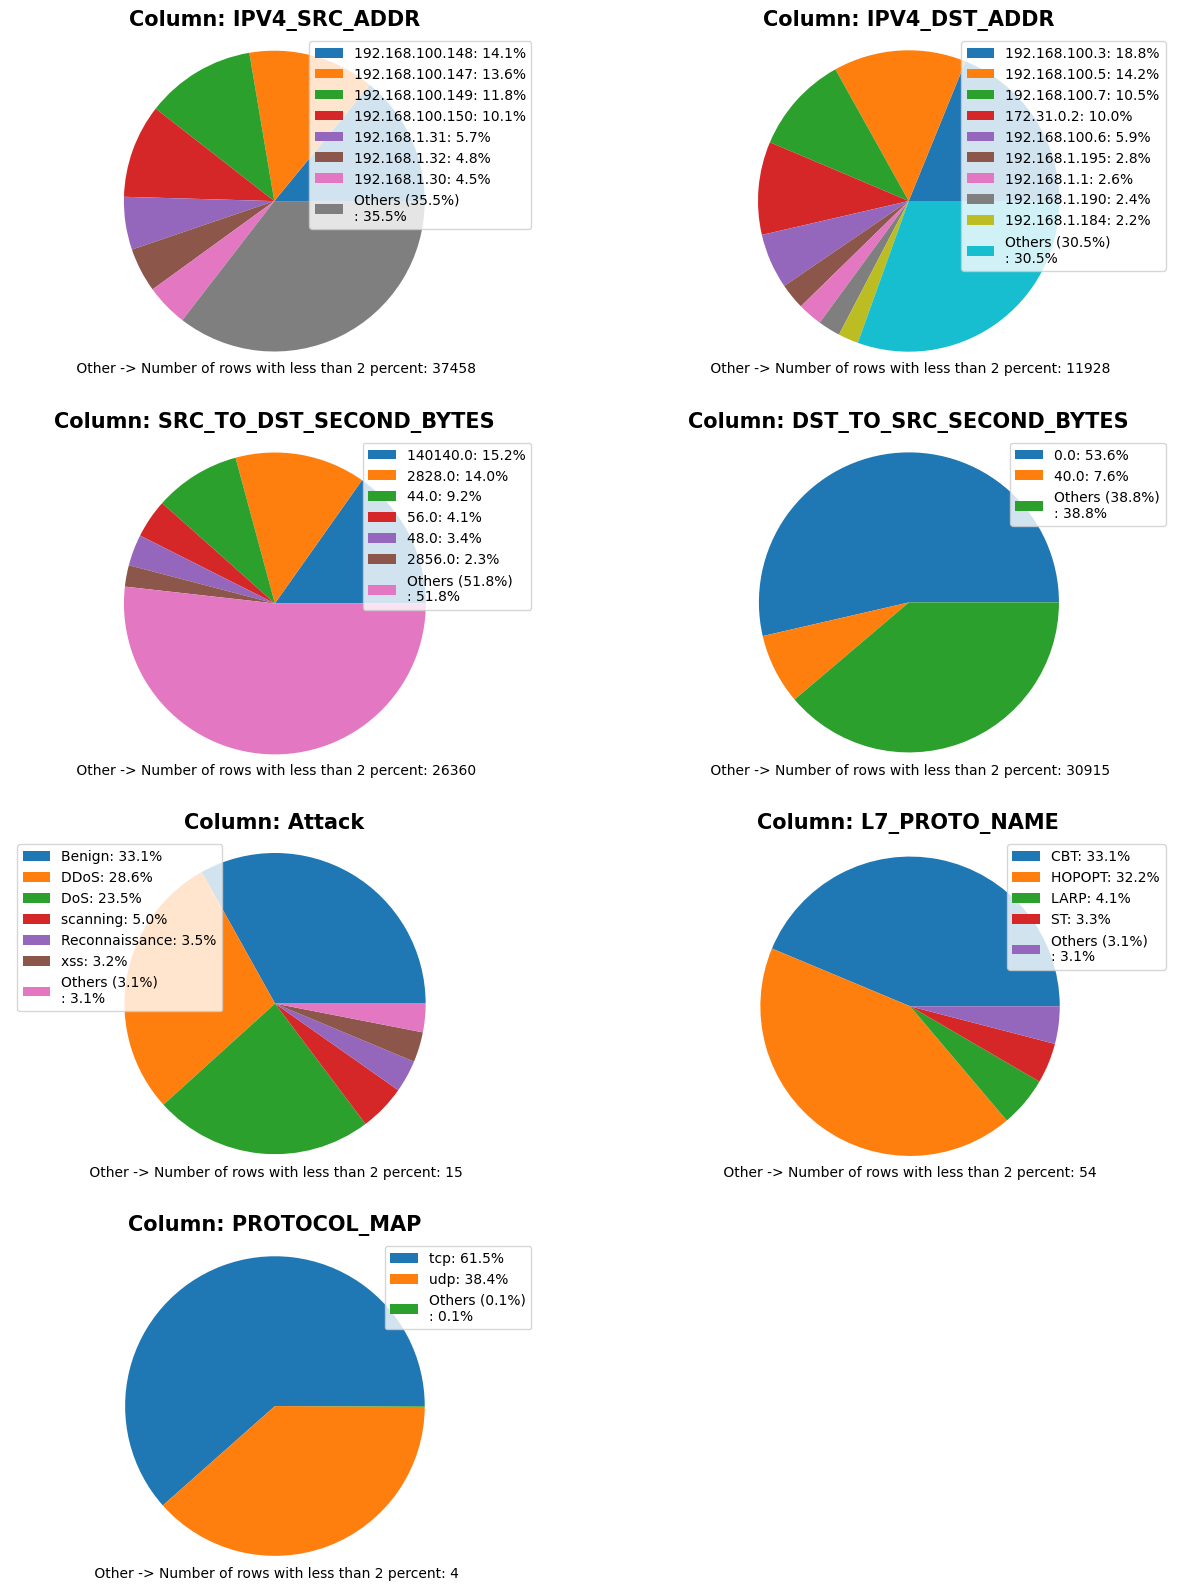

In [18]:
cols = ["IPV4_SRC_ADDR", "IPV4_DST_ADDR", "SRC_TO_DST_SECOND_BYTES", "DST_TO_SRC_SECOND_BYTES", "Attack", "L7_PROTO_NAME", "PROTOCOL_MAP"]
fig_nr_columns = 2
fig_nr_rows = 4
fig = plt.figure(1, figsize=[15,20])
percentage = 2

for k in range(len(cols)):
    value_counts = df[cols[k]].value_counts()
    percentage_values = (value_counts / len(df)) * 100
    filtered_values = percentage_values[percentage_values > percentage]
    filtered_values_others = percentage_values[percentage_values <= percentage]
    filtered_values_others_sum = filtered_values_others.sum()
    others_series = pd.Series({f'Others ({filtered_values_others_sum:.1f}%)\n': filtered_values_others_sum})
    filtered_values = pd.concat([filtered_values, others_series])
    labels = filtered_values.index
    sizes = filtered_values.values
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+1)
    ax.pie(sizes, labels=None, autopct=None)
    plt.axis('equal')
    plt.title("Column: {}".format(cols[k]), fontweight='bold', fontsize=15)
    legend_labels = [f'{label}: {size:.1f}%' for label, size in zip(labels, sizes)]
    plt.legend(legend_labels, loc='best')
    count_less_than_two_percent = len(filtered_values_others)
    plt.annotate(f' Other -> Number of rows with less than {percentage} percent: {count_less_than_two_percent}', xy=(0.5, 0.0), xycoords='axes fraction',ha='center', va='center')
    
plt.show()

##### Distribution of the numerical variances

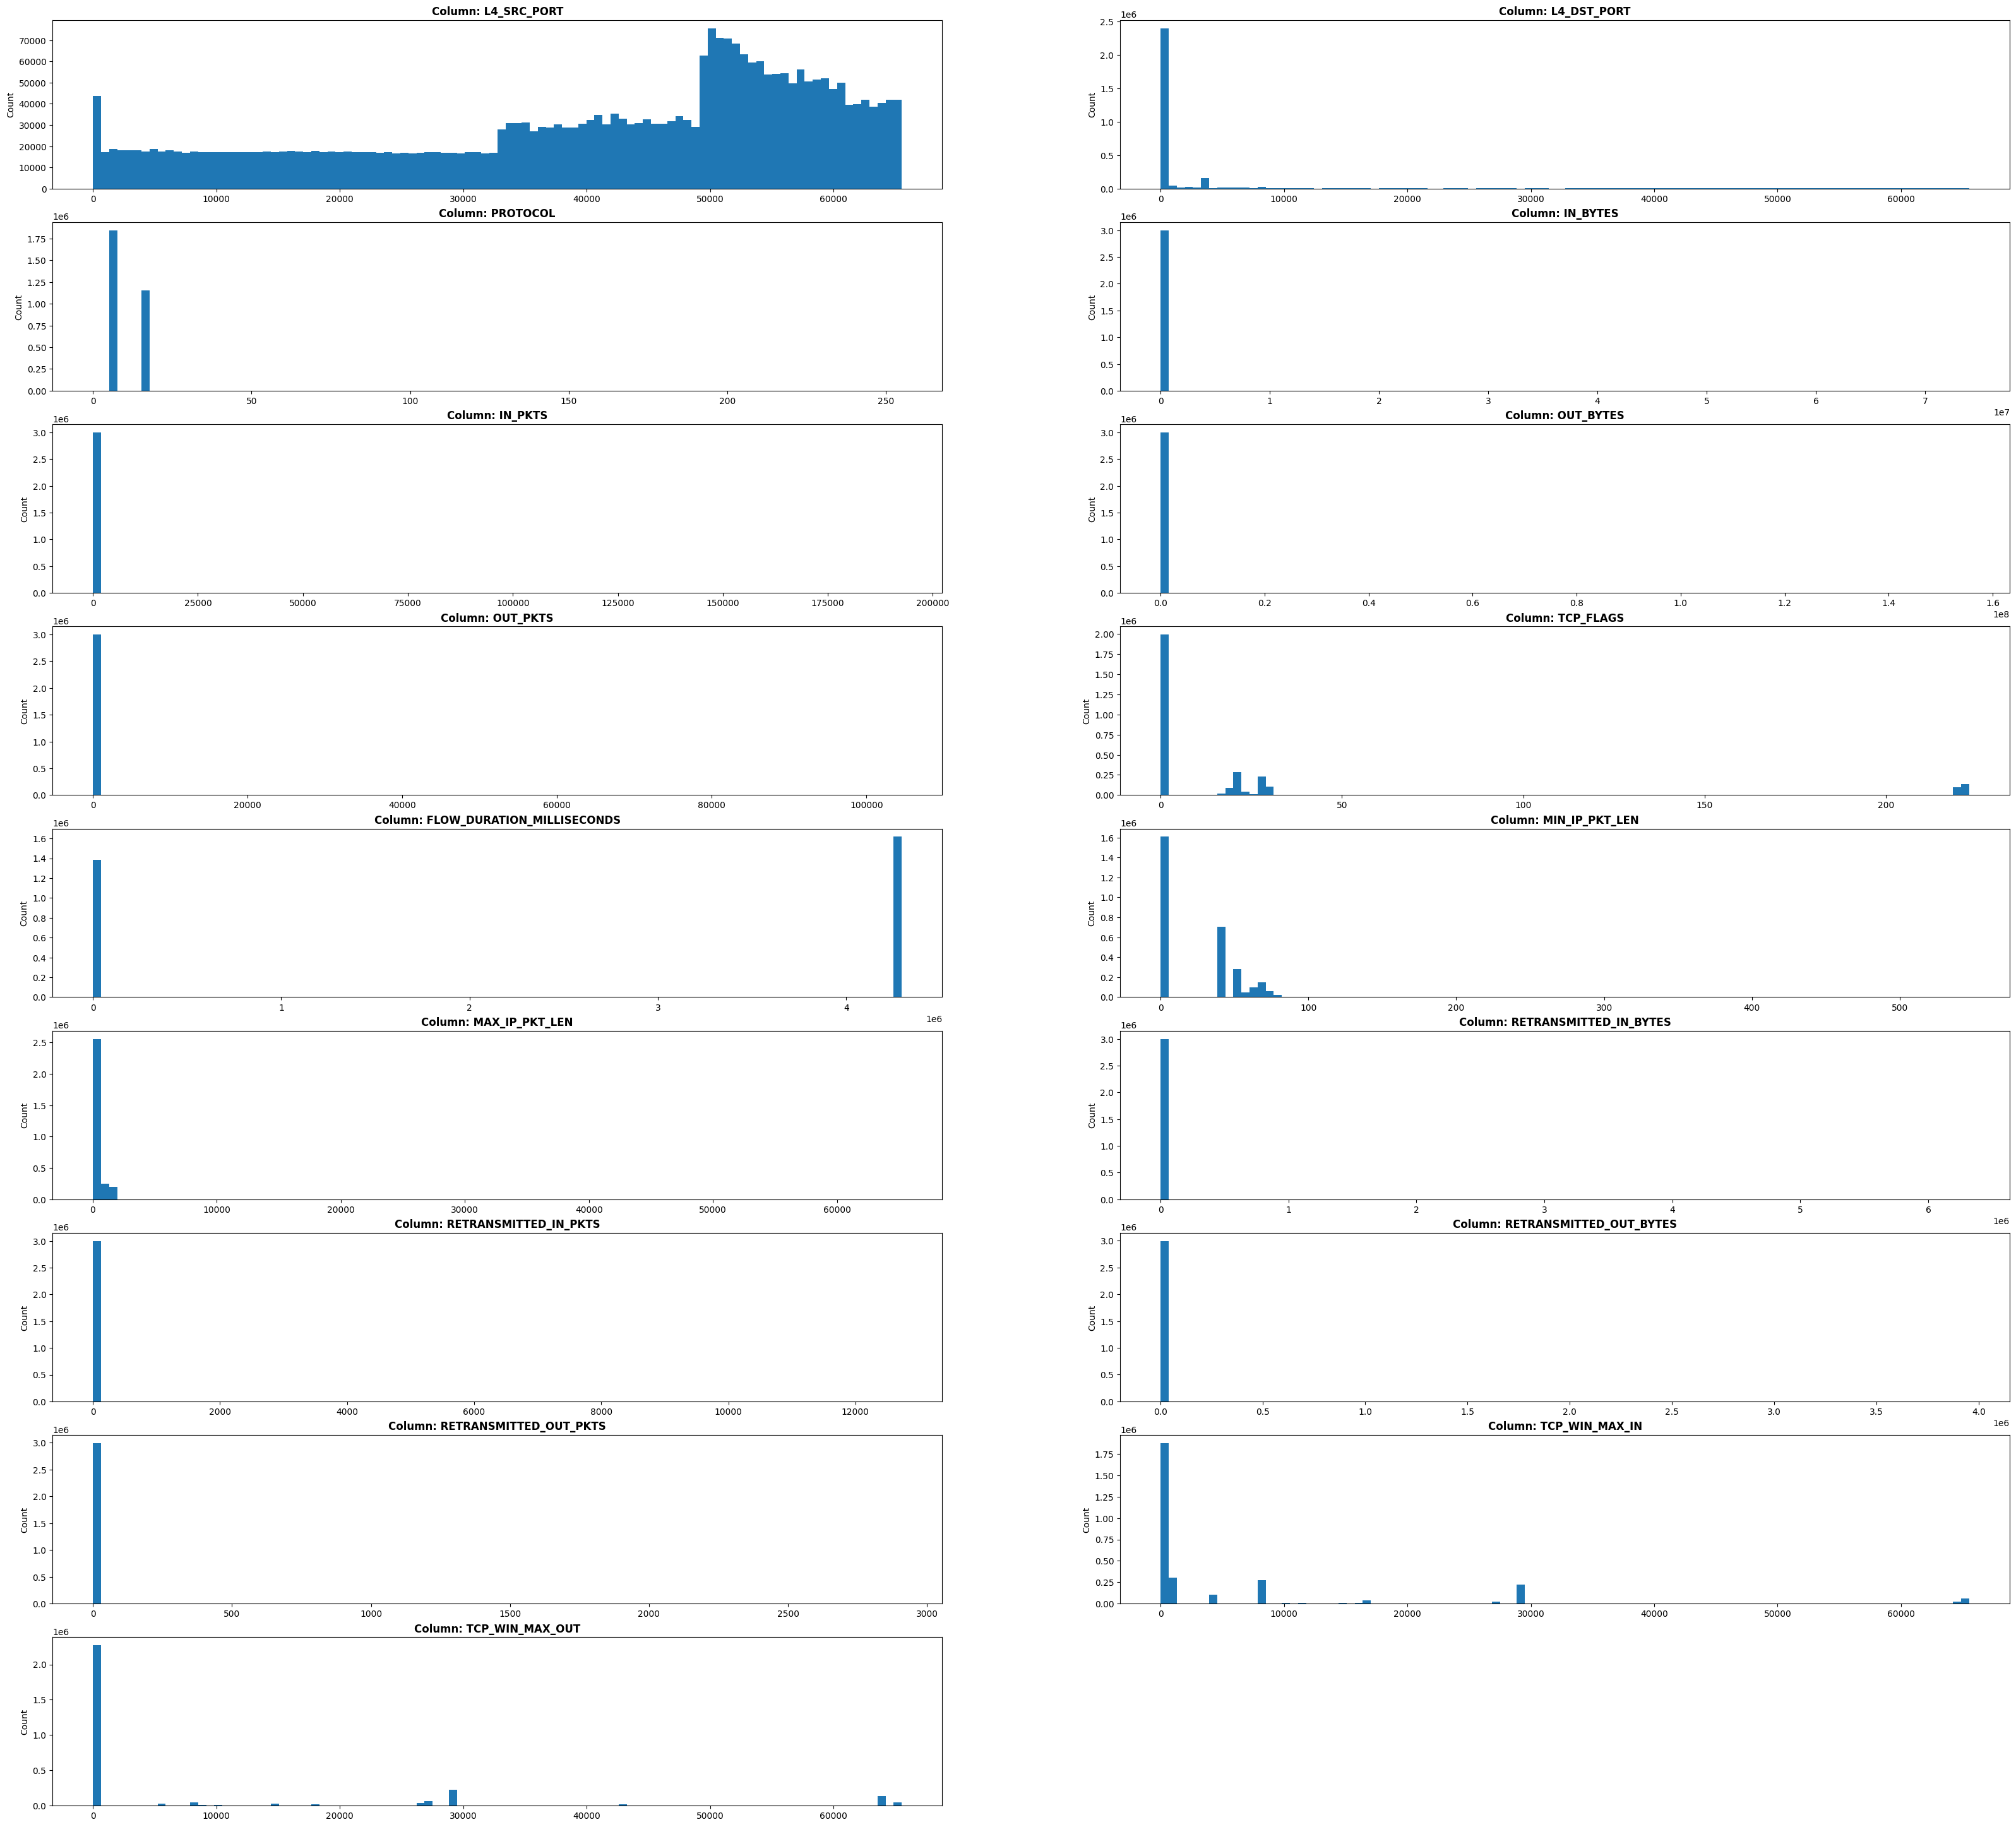

In [19]:
cols = ["L4_SRC_PORT","L4_DST_PORT","PROTOCOL","IN_BYTES","IN_PKTS","OUT_BYTES","OUT_PKTS","TCP_FLAGS","FLOW_DURATION_MILLISECONDS","MIN_IP_PKT_LEN","MAX_IP_PKT_LEN","RETRANSMITTED_IN_BYTES","RETRANSMITTED_IN_PKTS","RETRANSMITTED_OUT_BYTES","RETRANSMITTED_OUT_PKTS","TCP_WIN_MAX_IN","TCP_WIN_MAX_OUT"]

fig_nr_columns = 2
fig_nr_rows = 17
fig = plt.figure(1, figsize=[40,70])

for k in range(len(cols)):
    num_bins = 100
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+1)
    ax.hist(df[cols[k]], num_bins)
    plt.title("Column: {}".format(cols[k]), fontweight='bold')
    plt.ylabel("Count")

plt.show()

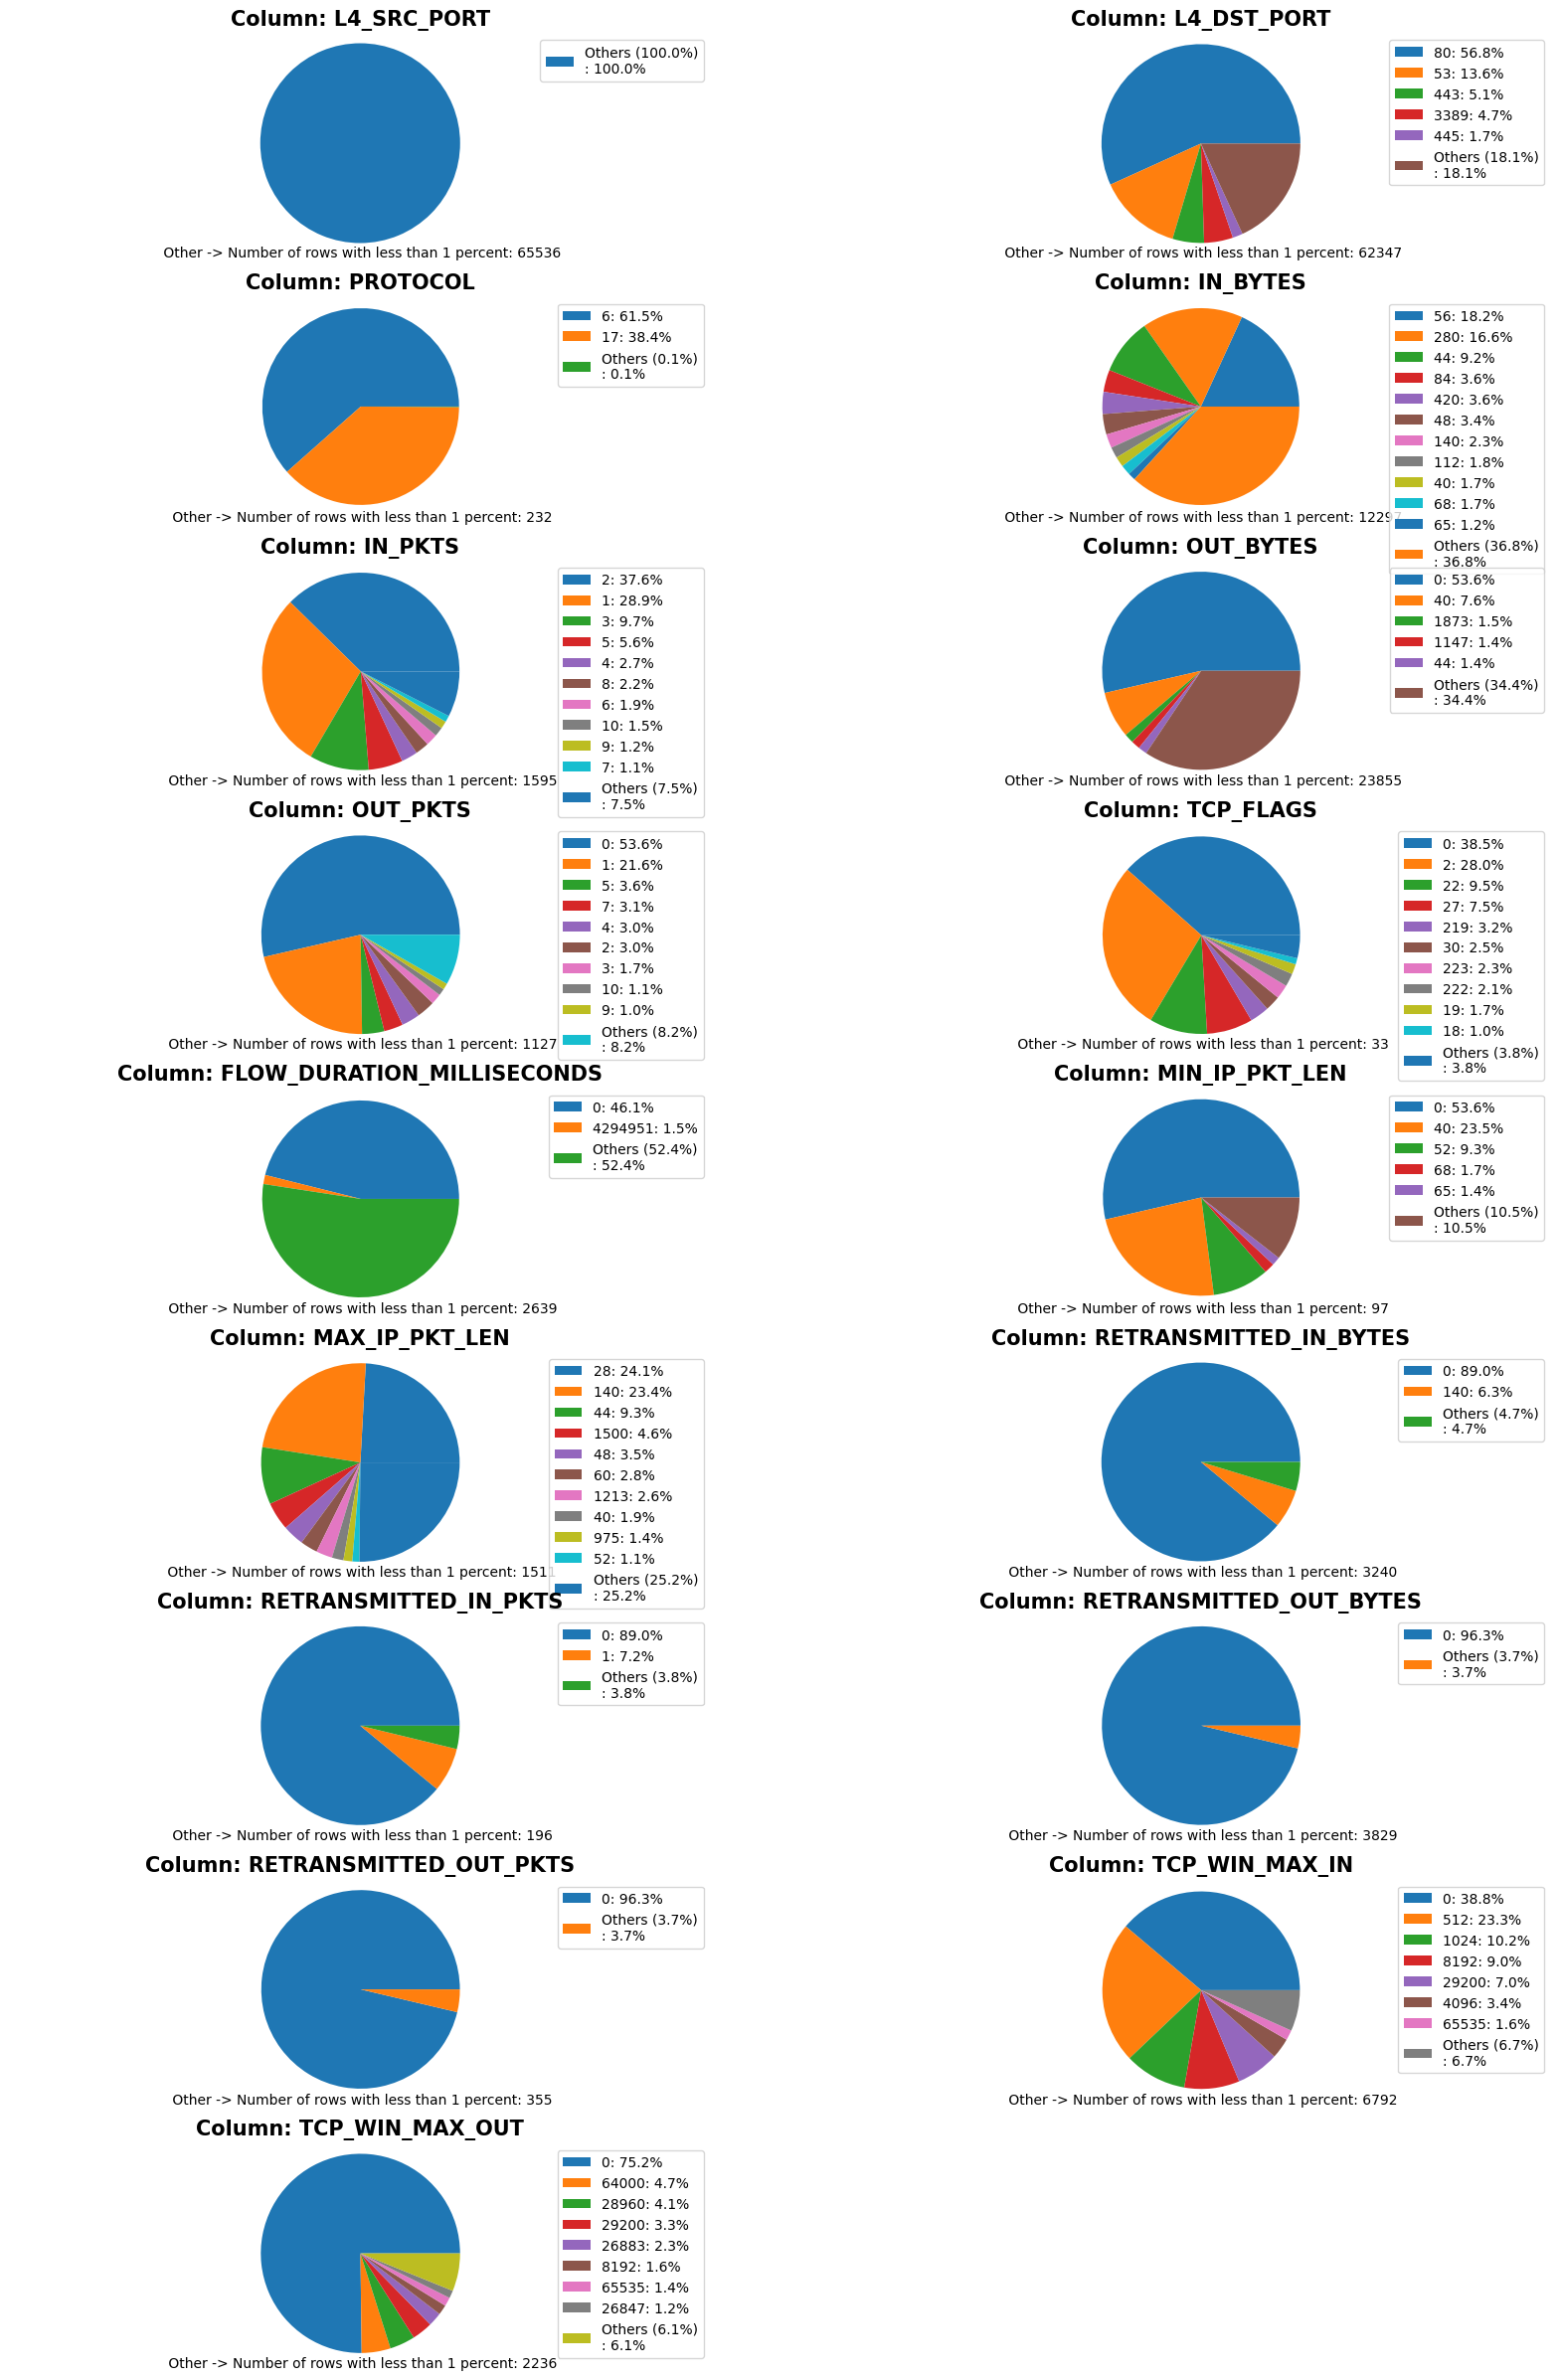

In [20]:
cols = ["L4_SRC_PORT","L4_DST_PORT","PROTOCOL","IN_BYTES","IN_PKTS","OUT_BYTES","OUT_PKTS","TCP_FLAGS","FLOW_DURATION_MILLISECONDS","MIN_IP_PKT_LEN","MAX_IP_PKT_LEN","RETRANSMITTED_IN_BYTES","RETRANSMITTED_IN_PKTS","RETRANSMITTED_OUT_BYTES","RETRANSMITTED_OUT_PKTS","TCP_WIN_MAX_IN","TCP_WIN_MAX_OUT"]
fig_nr_columns = 2
fig_nr_rows = 17
fig = plt.figure(1, figsize=[20,58])
percentage = 1

for k in range(len(cols)):
    value_counts = df[cols[k]].value_counts()
    percentage_values = (value_counts / len(df)) * 100
    filtered_values = percentage_values[percentage_values > percentage]
    filtered_values_others = percentage_values[percentage_values <= percentage]
    filtered_values_others_sum = filtered_values_others.sum()
    others_series = pd.Series({f'Others ({filtered_values_others_sum:.1f}%)\n': filtered_values_others_sum})
    filtered_values = pd.concat([filtered_values, others_series])
    labels = filtered_values.index
    sizes = filtered_values.values
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+1)
    ax.pie(sizes, labels=None, autopct=None)
    plt.axis('equal')
    plt.title("Column: {}".format(cols[k]), fontweight='bold', fontsize=15)
    legend_labels = [f'{label}: {size:.1f}%' for label, size in zip(labels, sizes)]
    plt.legend(legend_labels, loc='best')
    count_less_than_two_percent = len(filtered_values_others)
    plt.annotate(f' Other -> Number of rows with less than {percentage} percent: {count_less_than_two_percent}', xy=(0.5, 0.0), xycoords='axes fraction',ha='center', va='center')
    
plt.show()

##### Remove rows with NaN Labels

In [27]:
len(df_nf)

3000000

In [26]:
df = df.drop_duplicates()
df

IPV4_SRC_ADDR  L4_SRC_PORT  IPV4_DST_ADDR  L4_DST_PORT  PROTOCOL  \
0        192.168.100.148        65389  192.168.100.7           80         6   
1        192.168.100.148        11154  192.168.100.5           80         6   
2           192.168.1.31        42062   192.168.1.79         1041         6   
3           192.168.1.34        46849   192.168.1.79         9110         6   
4           192.168.1.30        50360  192.168.1.152         1084         6   
...                  ...          ...            ...          ...       ...   
2999992     172.31.64.28        55067     172.31.0.2           53        17   
2999994  192.168.100.150        42788  192.168.100.3           80         6   
2999996     172.31.67.73        64089     172.31.0.2           53        17   
2999998     192.168.1.30        38764    192.168.1.1           53        17   
2999999       59.166.0.9        54774  149.171.126.3           21         6   

         IN_BYTES  IN_PKTS  OUT_BYTES  OUT_PKTS  TCP_FLAGS  \
0             420        3          0         0          2   
1             280        2         40         1         22   
2              44        1         40         1         22   
3              44        1         40         1         22   
4              44        1         40         1         22   
...           ...      ...        ...       ...        ...   
2999992        70        1        130         1          0   
2999994       360        4         88         2         22   
2999996        68        1        167         1          0   
2999998        65        1         81         1          0   
2999999       701       13       1054        15         24   

         FLOW_DURATION_MILLISECONDS  MIN_IP_PKT_LEN  MAX_IP_PKT_LEN  \
0                           4293092               0             140   
1                           4294499              40             140   
2                                 0              40              44   
3                                 0              40              44   
4                                 0              40              44   
...                             ...             ...             ...   
2999992                           0              70             130   
2999994                     4294608              40             140   
2999996                           0              68             167   
2999998                           0              65              81   
2999999                           0              52             106   

         SRC_TO_DST_SECOND_BYTES  DST_TO_SRC_SECOND_BYTES  \
0                       140280.0                      0.0   
1                          280.0                     40.0   
2                           44.0                     40.0   
3                           44.0                     40.0   
4                           44.0                     40.0   
...                          ...                      ...   
2999992                    140.0                    130.0   
2999994                    360.0                     88.0   
2999996                     68.0                    167.0   
2999998                     65.0                     81.0   
2999999                   1148.0                   1296.0   

         RETRANSMITTED_IN_BYTES  RETRANSMITTED_IN_PKTS  \
0                           140                      1   
1                             0                      0   
2                             0                      0   
3                             0                      0   
4                             0                      0   
...                         ...                    ...   
2999992                       0                      0   
2999994                       0                      0   
2999996                       0                      0   
2999998                       0                      0   
2999999                     190                      3   

         RETRANSMITTED_OUT_BYTES  

In [28]:
df = df[df['L7_PROTO_NAME'].notna()]
len(df[df.Label == 0]), len(df[df.Label == 1]), df.Label.isna().sum()

(987975, 1276096, 0)

In [30]:
df.describe()

L4_SRC_PORT   L4_DST_PORT      PROTOCOL      IN_BYTES       IN_PKTS  \
count  2.264071e+06  2.264071e+06  2.264071e+06  2.264071e+06  2.264071e+06   
mean   4.286580e+04  4.402826e+03  8.072552e+00  1.262996e+03  1.154267e+01   
std    1.756808e+04  1.210134e+04  4.784232e+00  9.546190e+04  6.472147e+02   
min    0.000000e+00  0.000000e+00  0.000000e+00  3.000000e+00  1.000000e+00   
25%    3.402600e+04  8.000000e+01  6.000000e+00  6.500000e+01  1.000000e+00   
50%    4.942500e+04  8.000000e+01  6.000000e+00  2.800000e+02  2.000000e+00   
75%    5.597600e+04  1.092000e+03  6.000000e+00  4.200000e+02  5.000000e+00   
max    6.553500e+04  6.553500e+04  2.550000e+02  7.405536e+07  1.926100e+05   

          OUT_BYTES      OUT_PKTS     TCP_FLAGS  FLOW_DURATION_MILLISECONDS  \
count  2.264071e+06  2.264071e+06  2.264071e+06                2.264071e+06   
mean   4.015332e+03  6.152100e+00  3.202676e+01                1.718226e+06   
std    2.918809e+05  2.219026e+02  6.539145e+01                2.103716e+06   
min    0.000000e+00  0.000000e+00  0.000000e+00                0.000000e+00   
25%    0.000000e+00  0.000000e+00  2.000000e+00                0.000000e+00   
50%    4.400000e+01  1.000000e+00  2.000000e+00                0.000000e+00   
75%    3.410000e+02  4.000000e+00  2.700000e+01                4.293576e+06   
max    1.554980e+08  1.045650e+05  2.230000e+02                4.294967e+06   

       MIN_IP_PKT_LEN  MAX_IP_PKT_LEN  SRC_TO_DST_SECOND_BYTES  \
count    2.264071e+06    2.264071e+06             2.264071e+06   
mean     3.101948e+01    3.416558e+02            2.909812e+298   
std      2.691784e+01    4.724438e+02                      inf   
min      0.000000e+00    2.800000e+01             0.000000e+00   
25%      0.000000e+00    6.500000e+01             6.700000e+01   
50%      4.000000e+01    1.400000e+02             4.880000e+02   
75%      5.200000e+01    2.000000e+02             1.401400e+05   
max      5.470000e+02    6.521200e+04            6.588022e+304   

       DST_TO_SRC_SECOND_BYTES  RETRANSMITTED_IN_BYTES  RETRANSMITTED_IN_PKTS  \
count             2.264071e+06            2.264071e+06           2.264071e+06   
mean             1.837416e+151            1.062312e+02           5.244637e-01   
std                        inf            7.978876e+03           1.427232e+01   
min               0.000000e+00            0.000000e+00           0.000000e+00   
25%               0.000000e+00            0.000000e+00           0.000000e+00   
50%               4.400000e+01            0.000000e+00           0.000000e+00   
75%               3.900000e+02            0.000000e+00           0.000000e+00   
max              4.160041e+157            6.321251e+06           1.272900e+04   

       RETRANSMITTED_OUT_BYTES  RETRANSMITTED_OUT_PKTS  TCP_WIN_MAX_IN  \
count             2.264071e+06            2.264071e+06    2.264071e+06   
mean              7.541929e+02            7.598136e-01    7.974017e+03   
std               1.620389e+04            1.159159e+01    1.472349e+04   
min               0.000000e+00            0.000000e+00    0.000000e+00   
25%               0.000000e+00            0.000000e+00    5.120000e+02   
50%               0.000000e+00            0.000000e+00    5.120000e+02   
75%               0.000000e+00            0.000000e+00    8.192000e+03   
max               3.953335e+06            2.909000e+03    6.553500e+04   

       TCP_WIN_MAX_OUT         Label  
count     2.264071e+06  2.264071e+06  
mean      1.110308e+04  5.636290e-01  
std       1.961312e+04  4.959349e-01  
min       0.000000e+00  0.000000e+00  
25%       0.000000e+00  0.000000e+00  
50%       0.000000e+00  1.000000e+00  
75%       1.882400e+04  1.000000e+00  
max       6.553500e+04  1.000000e+00

In [8]:
def spb_to_mean(x):
    vals = x.split(',')
    vals = list(filter(lambda v: v != '', vals))
    vals = [int(float(x)) for x in vals]
    
    if len(vals) == 0: return 0
    
    return np.asarray(vals, dtype=np.float64).mean()

def spb_to_total(x):
    vals = x.split(',')
    vals = list(filter(lambda v: v != '', vals))
    vals = [int(float(x)) for x in vals]
    
    return np.asarray(vals, dtype=np.float64).sum()


In [ ]:

df['DST_TO_SRC_SECOND_BYTES_MEAN'] = df.DST_TO_SRC_SECOND_BYTES.apply(spb_to_mean)
df['DST_TO_SRC_SECOND_BYTES_TOTAL'] = df.DST_TO_SRC_SECOND_BYTES.apply(spb_to_total)
df['SRC_TO_DST_SECOND_BYTES_MEAN'] = df.SRC_TO_DST_SECOND_BYTES.apply(spb_to_mean)
df['SRC_TO_DST_SECOND_BYTES_TOTAL'] = df.SRC_TO_DST_SECOND_BYTES.apply(spb_to_total)

##### Label Encoding da feature L7_PROTO_NAME

In [31]:
l7_proto_encoder = LabelEncoder()
df['L7_PROTO_NAME'] = l7_proto_encoder.fit_transform(df['L7_PROTO_NAME'])

##### Label Encoding da feature AttackEnc

In [32]:
attack_encoder = LabelEncoder()
df['AttackEnc'] = attack_encoder.fit_transform(df.Attack)

##### Remove features 

In [25]:
df = df.drop(['DST_TO_SRC_SECOND_BYTES', 'SRC_TO_DST_SECOND_BYTES'], axis=1)

##### Calculates the standard deviation of the values in column DST_TO_SRC_SECOND_BYTES_MEAN

In [36]:
np.array(df.DST_TO_SRC_SECOND_BYTES).std()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


inf

In [39]:
df.columns

Index(['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT',
       'PROTOCOL', 'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS', 'TCP_FLAGS',
       'FLOW_DURATION_MILLISECONDS', 'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN',
       'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS', 'TCP_WIN_MAX_IN',
       'TCP_WIN_MAX_OUT', 'Label', 'Attack', 'L7_PROTO_NAME', 'PROTOCOL_MAP',
       'DST_TO_SRC_SECOND_BYTES_MEAN', 'DST_TO_SRC_SECOND_BYTES_TOTAL',
       'SRC_TO_DST_SECOND_BYTES_MEAN', 'SRC_TO_DST_SECOND_BYTES_TOTAL',
       'AttackEnc'],
      dtype='object')

#### Bin creation

In [59]:
bins = [
    { 'col': 'IN_BYTES', 'n_bins': 4 },
    { 'col': 'OUT_BYTES', 'n_bins': 4 },
    { 'col': 'IN_PKTS', 'n_bins': 4 },
    { 'col': 'OUT_PKTS', 'n_bins': 4 },
    { 'col': 'FLOW_DURATION_MILLISECONDS', 'n_bins': 4 },
    { 'col': 'MAX_IP_PKT_LEN', 'n_bins': 4 },
    { 'col': 'MIN_IP_PKT_LEN', 'n_bins': 4 },
    { 'col': 'RETRANSMITTED_IN_BYTES', 'n_bins': 4 },
    { 'col': 'RETRANSMITTED_IN_PKTS', 'n_bins': 4 },
    { 'col': 'RETRANSMITTED_OUT_BYTES', 'n_bins': 4 },
    { 'col': 'RETRANSMITTED_OUT_PKTS', 'n_bins': 4 },
    { 'col': 'DST_TO_SRC_SECOND_BYTES_MEAN', 'n_bins': 4 },
    { 'col': 'DST_TO_SRC_SECOND_BYTES_TOTAL', 'n_bins': 4 },
    { 'col': 'SRC_TO_DST_SECOND_BYTES_MEAN', 'n_bins': 4 },
    { 'col': 'SRC_TO_DST_SECOND_BYTES_TOTAL', 'n_bins': 4 },
    { 'col': 'TCP_WIN_MAX_IN', 'n_bins': 4 },
    { 'col': 'TCP_WIN_MAX_OUT', 'n_bins': 4 },
]

cols = [ x['col'] for x in bins ]

enc = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='uniform')
df[cols] = enc.fit_transform(df[cols])
#bin_['enc'] = enc
# for bin_ in bins:
#     enc = KBinsDiscretizer(n_bins=bin_['n_bins'], encode='ordinal', strategy='uniform')
#     df[bin_['col']] = enc.fit_transform(df[bin_['col']])
#     bin_['enc'] = enc

##### Correlation matrix

<AxesSubplot:>

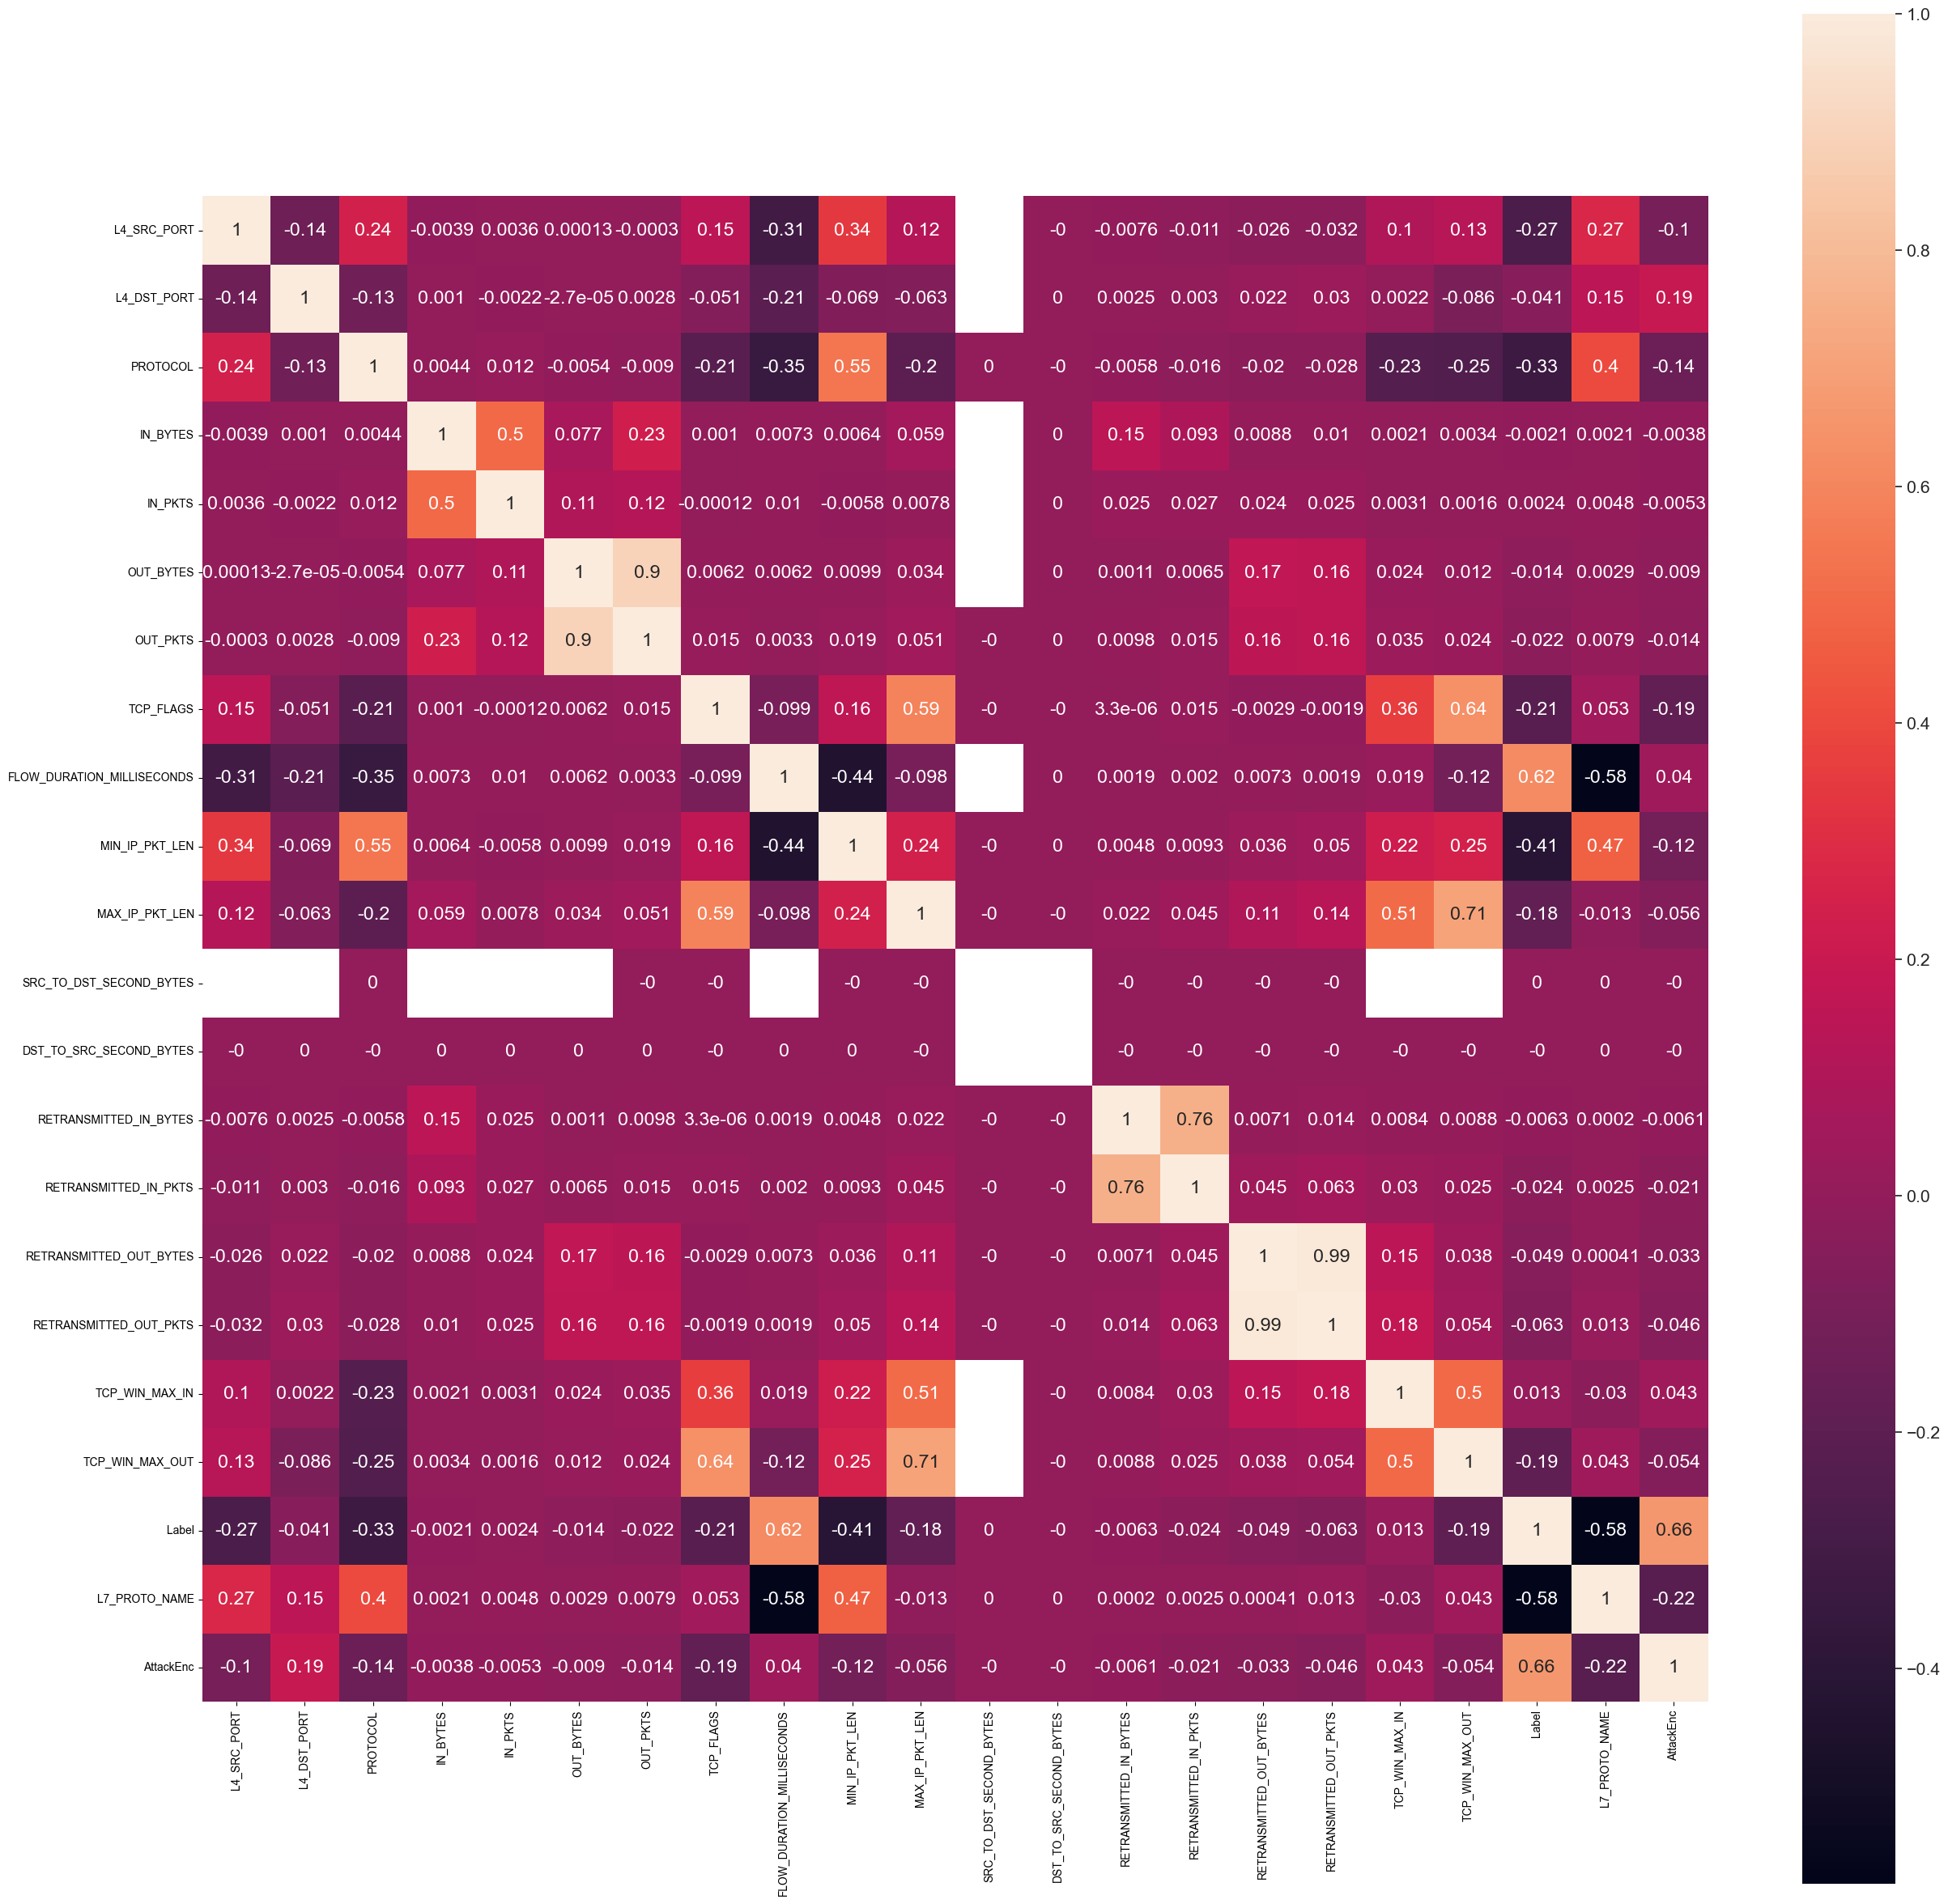

In [37]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(30, 30))
#plt.legend(title='Correlation Matrix', fontsize=20)
sns.set(font_scale=1.4)
sns.heatmap(corr, square=True, ax=ax, annot=True)

<AxesSubplot:xlabel='TCP_WIN_MAX_IN', ylabel='TCP_WIN_MAX_OUT'>

/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


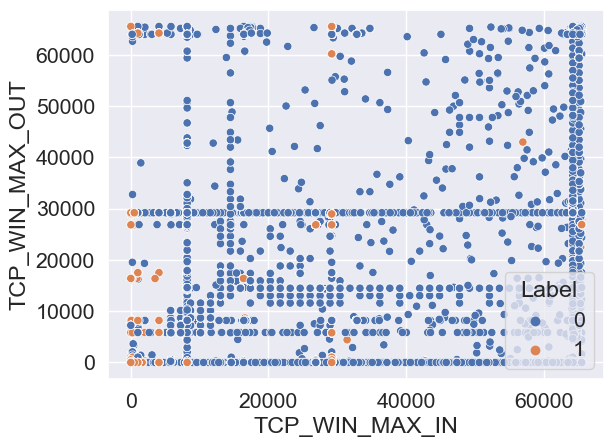

In [38]:
sns.scatterplot(data=df, x="TCP_WIN_MAX_IN", y="TCP_WIN_MAX_OUT", hue="Label")

<AxesSubplot:xlabel='TCP_WIN_MAX_IN', ylabel='IN_BYTES'>

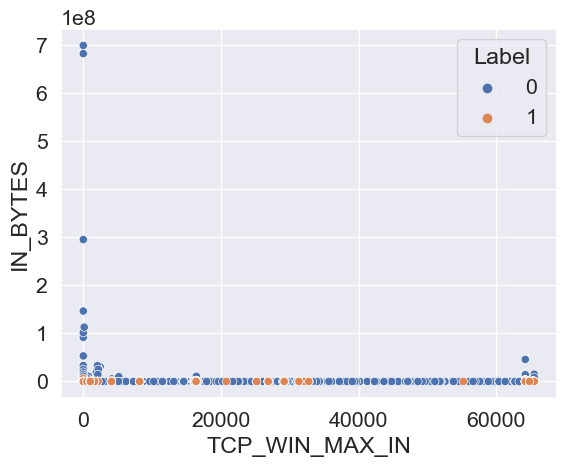

In [32]:
sns.scatterplot(data=df, x="TCP_WIN_MAX_IN", y="IN_BYTES", hue="Label")

In [39]:
sns.scatterplot(data=df, x="IPV4_SRC_ADDR", y="L4_DST_PORT", hue="Label")

<AxesSubplot:xlabel='IPV4_SRC_ADDR', ylabel='L4_DST_PORT'>

/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print

Error in callback <function flush_figures at 0x7fd6ca1acef0> (for post_execute):


KeyboardInterrupt: 

<AxesSubplot:xlabel='IPV4_DST_ADDR', ylabel='L4_DST_PORT'>

/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


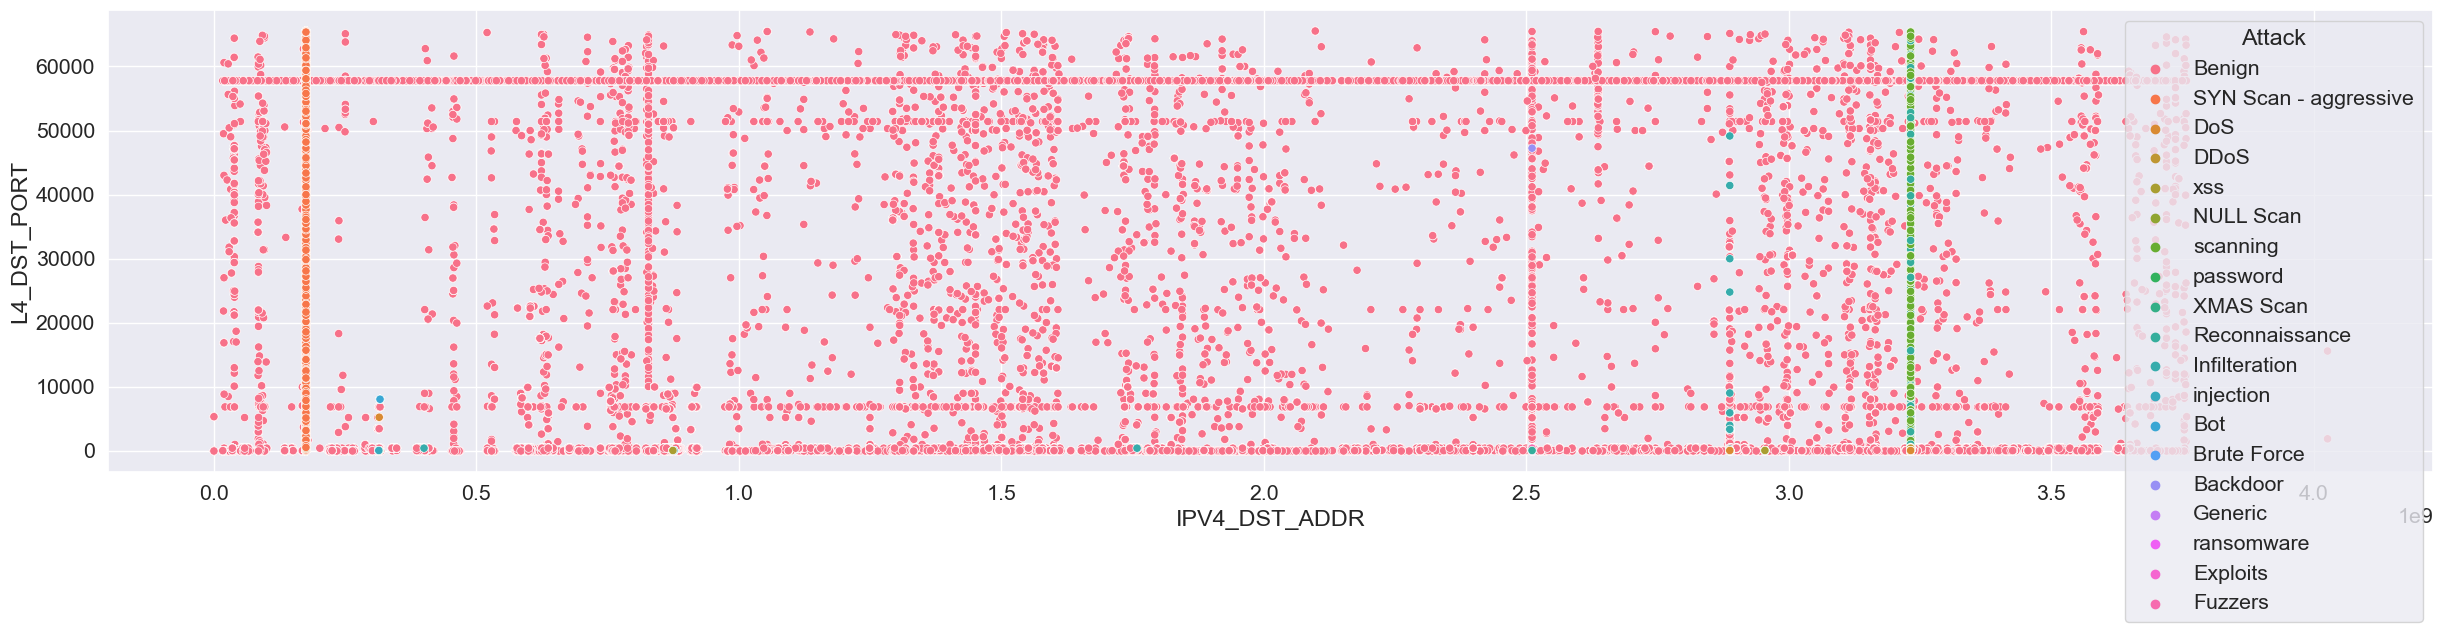

In [ ]:
fig, ax = plt.subplots(figsize=(30, 6))
sns.scatterplot(data=df, x="IPV4_DST_ADDR", y="L4_DST_PORT", hue="Attack", ax=ax)



<AxesSubplot:xlabel='IPV4_DST_ADDR', ylabel='L4_SRC_PORT'>

/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


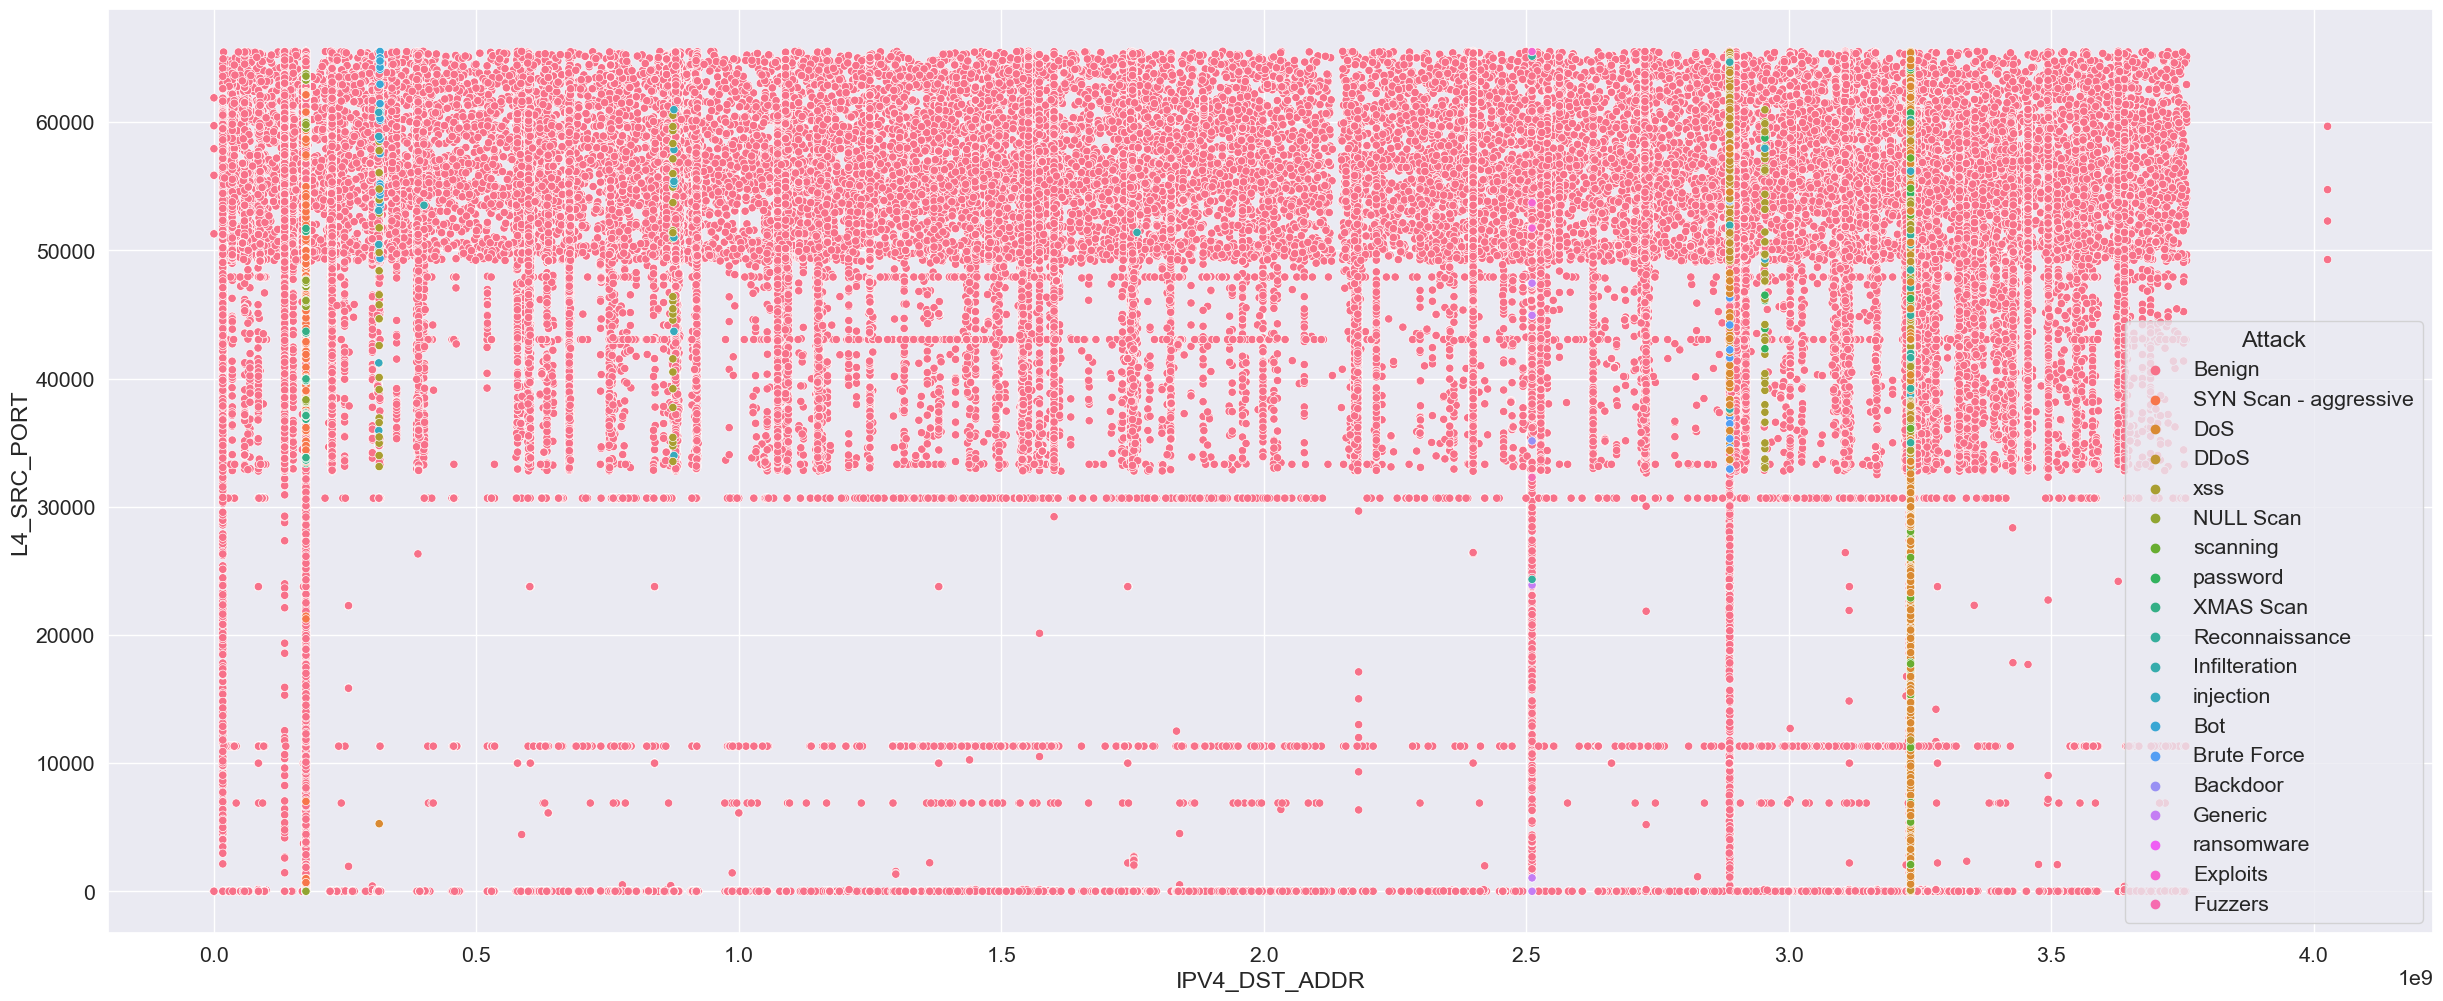

In [15]:
fig, ax = plt.subplots(figsize=(30, 12))
sns.scatterplot(data=df, x="IPV4_DST_ADDR", y="L4_SRC_PORT", hue="Attack", ax=ax)

<AxesSubplot:xlabel='L4_SRC_PORT', ylabel='L4_DST_PORT'>

/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


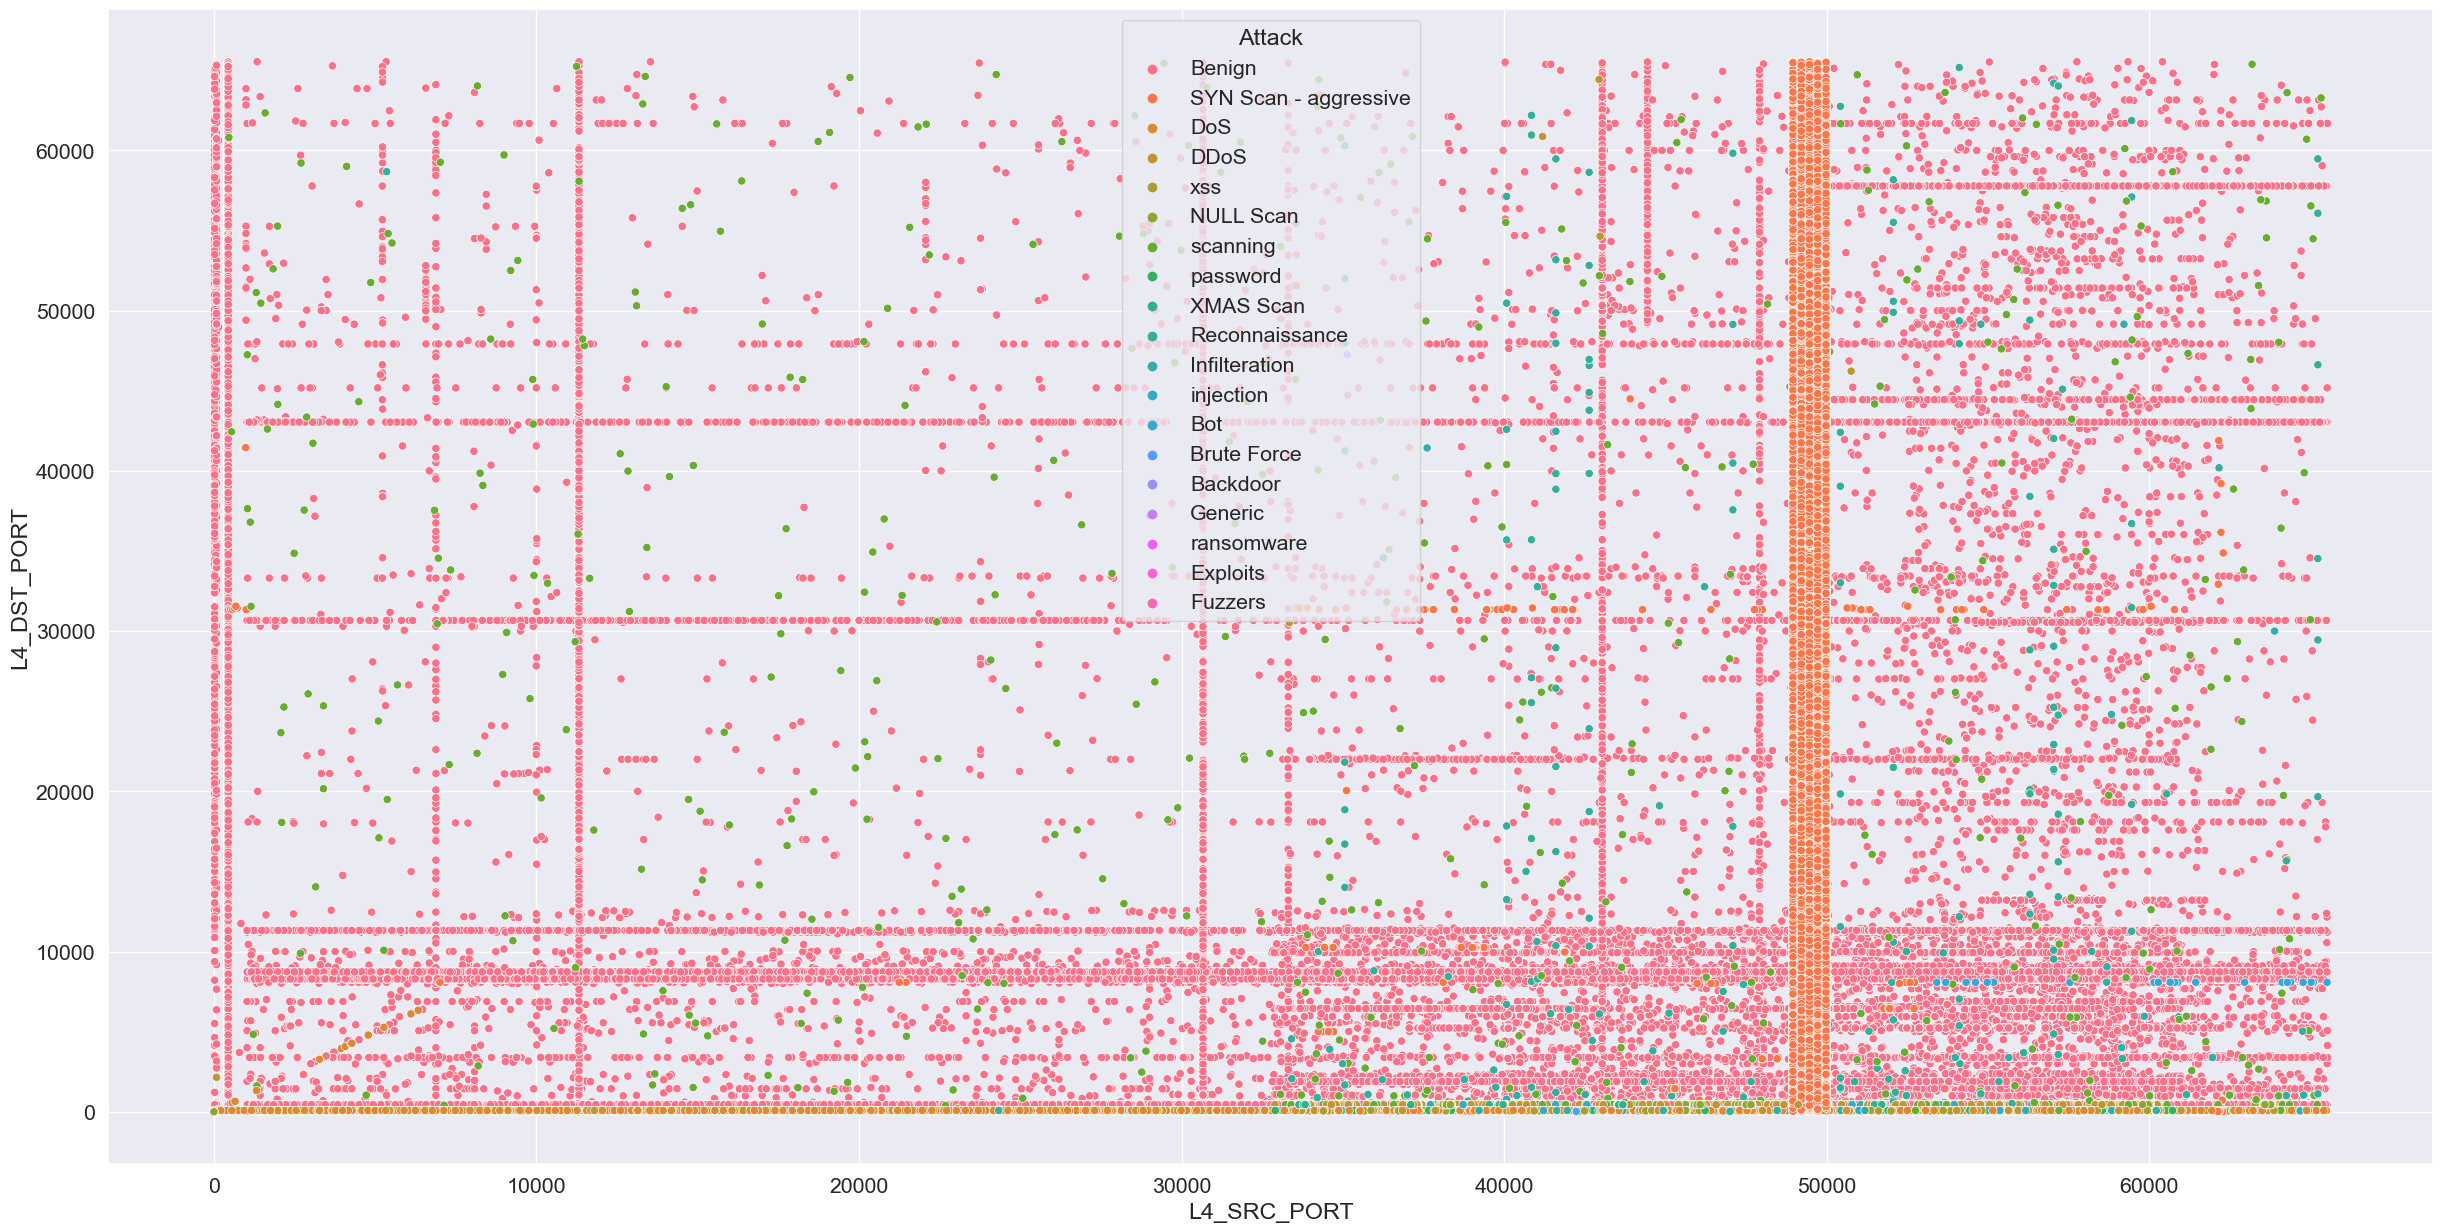

In [19]:
fig, ax = plt.subplots(figsize=(30, 15))
sns.scatterplot(data=df, x="L4_SRC_PORT", y="L4_DST_PORT", hue="Attack", ax=ax)

<AxesSubplot:xlabel='IN_BYTES', ylabel='OUT_BYTES'>

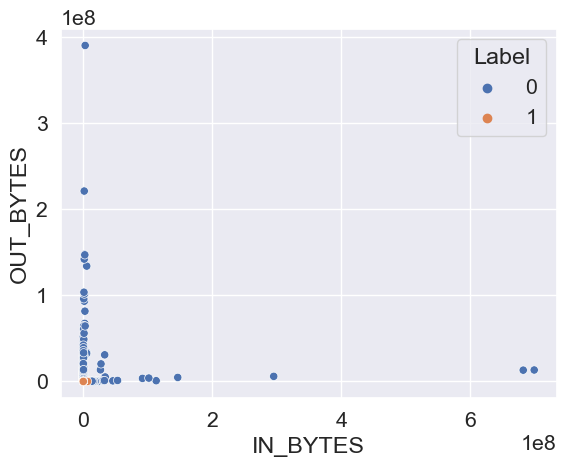

In [20]:
sns.scatterplot(data=df, x="IN_BYTES", y="OUT_BYTES", hue="Label")

In [24]:
df.PROTOCOL.describe()

count    597223.000000
mean          8.402314
std           4.843903
min           1.000000
25%           6.000000
50%           6.000000
75%           6.000000
max         177.000000
Name: PROTOCOL, dtype: float64

<AxesSubplot:xlabel='PROTOCOL', ylabel='Count'>

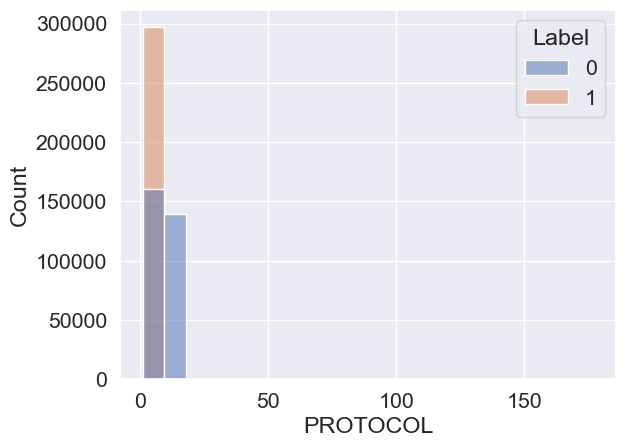

In [22]:
sns.histplot(data=df, x="PROTOCOL", hue="Label")

<AxesSubplot:xlabel='IN_BYTES', ylabel='Count'>

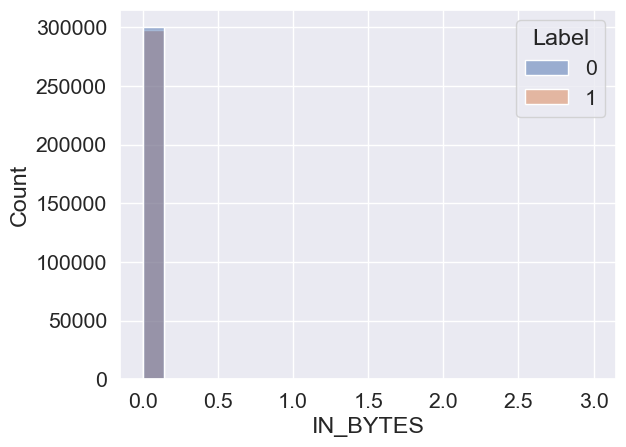

In [47]:
sns.histplot(data=df, x="IN_BYTES", hue="Label")

In [48]:
df.describe()

IPV4_SRC_ADDR   L4_SRC_PORT  IPV4_DST_ADDR    L4_DST_PORT  \
count   5.972230e+05  597223.00000   5.972230e+05  597223.000000   
mean    4.474240e+08   45191.38202   5.685460e+08   20011.162412   
std     7.668322e+08   15010.13529   9.211407e+08   21882.558325   
min     0.000000e+00       0.00000   0.000000e+00       0.000000   
25%     1.753009e+08   48616.00000   1.753006e+08      80.000000   
50%     1.753050e+08   49470.00000   1.753006e+08    9291.000000   
75%     1.753050e+08   49983.00000   1.753011e+08   39155.000000   
max     4.234391e+09   65534.00000   4.026532e+09   65535.000000   

            PROTOCOL       IN_BYTES        IN_PKTS      OUT_BYTES  \
count  597223.000000  597223.000000  597223.000000  597223.000000   
mean        8.402314       0.000012       0.000012       0.000018   
std         4.843903       0.005640       0.005640       0.005640   
min         1.000000       0.000000       0.000000       0.000000   
25%         6.000000       0.000000       0.000000       0.000000   
50%         6.000000       0.000000       0.000000       0.000000   
75%         6.000000       0.000000       0.000000       0.000000   
max       177.000000       3.000000       3.000000       3.000000   

            OUT_PKTS      TCP_FLAGS  FLOW_DURATION_MILLISECONDS  \
count  597223.000000  597223.000000               597223.000000   
mean        0.000022      14.056823                    0.017612   
std         0.005930      14.464179                    0.229182   
min         0.000000       0.000000                    0.000000   
25%         0.000000       0.000000                    0.000000   
50%         0.000000      22.000000                    0.000000   
75%         0.000000      22.000000                    0.000000   
max         3.000000     223.000000                    3.000000   

       MIN_IP_PKT_LEN  MAX_IP_PKT_LEN  RETRANSMITTED_IN_BYTES  \
count   597223.000000   597223.000000           597223.000000   
mean         0.011969        0.002806                0.000042   
std          0.131800        0.052995                0.008485   
min          0.000000        0.000000                0.000000   
25%          0.000000        0.000000                0.000000   
50%          0.000000        0.000000                0.000000   
75%          0.000000        0.000000                0.000000   
max          3.000000        3.000000                3.000000   

       RETRANSMITTED_IN_PKTS  RETRANSMITTED_OUT_BYTES  RETRANSMITTED_OUT_PKTS  \
count          597223.000000            597223.000000           597223.000000   
mean                0.000045                 0.000017                0.000017   
std                 0.008871                 0.006069                0.006069   
min                 0.000000                 0.000000                0.000000   
25%                 0.000000                 0.000000                0.000000   
50%                 0.000000                 0.000000                0.000000   
75%                 0.000000                 0.000000                0.000000   
max                 3.000000                 3.000000                3.000000   

       TCP_WIN_MAX_IN  TCP_WIN_MAX_OUT          Label  L7_PROTO_NAME  \
count   597223.000000    597223.000000  597223.000000  597223.000000   
mean         0.233352         0.155125       0.497702     263.086936   
std          0.764616         0.586387       0.499995     124.245653   
min          0.000000         0.000000       0.000000       0.000000   
25%          0.000000         0.000000       0.000000     175.000000   
50%          0.000000         0.000000       0.000000     348.000000   
75%          0.000000         0.000000       1.000000     348.000000   
max          3.000000         3.000000       1.000000     365.000000   

       DST_TO_SRC_SECOND_BYTES_MEAN  DST_TO_SRC_SECOND_BYTES_TOTAL  \
count                 597223.000000                  597223.000000   
mean                       0.000012                       0.000

### Outliers

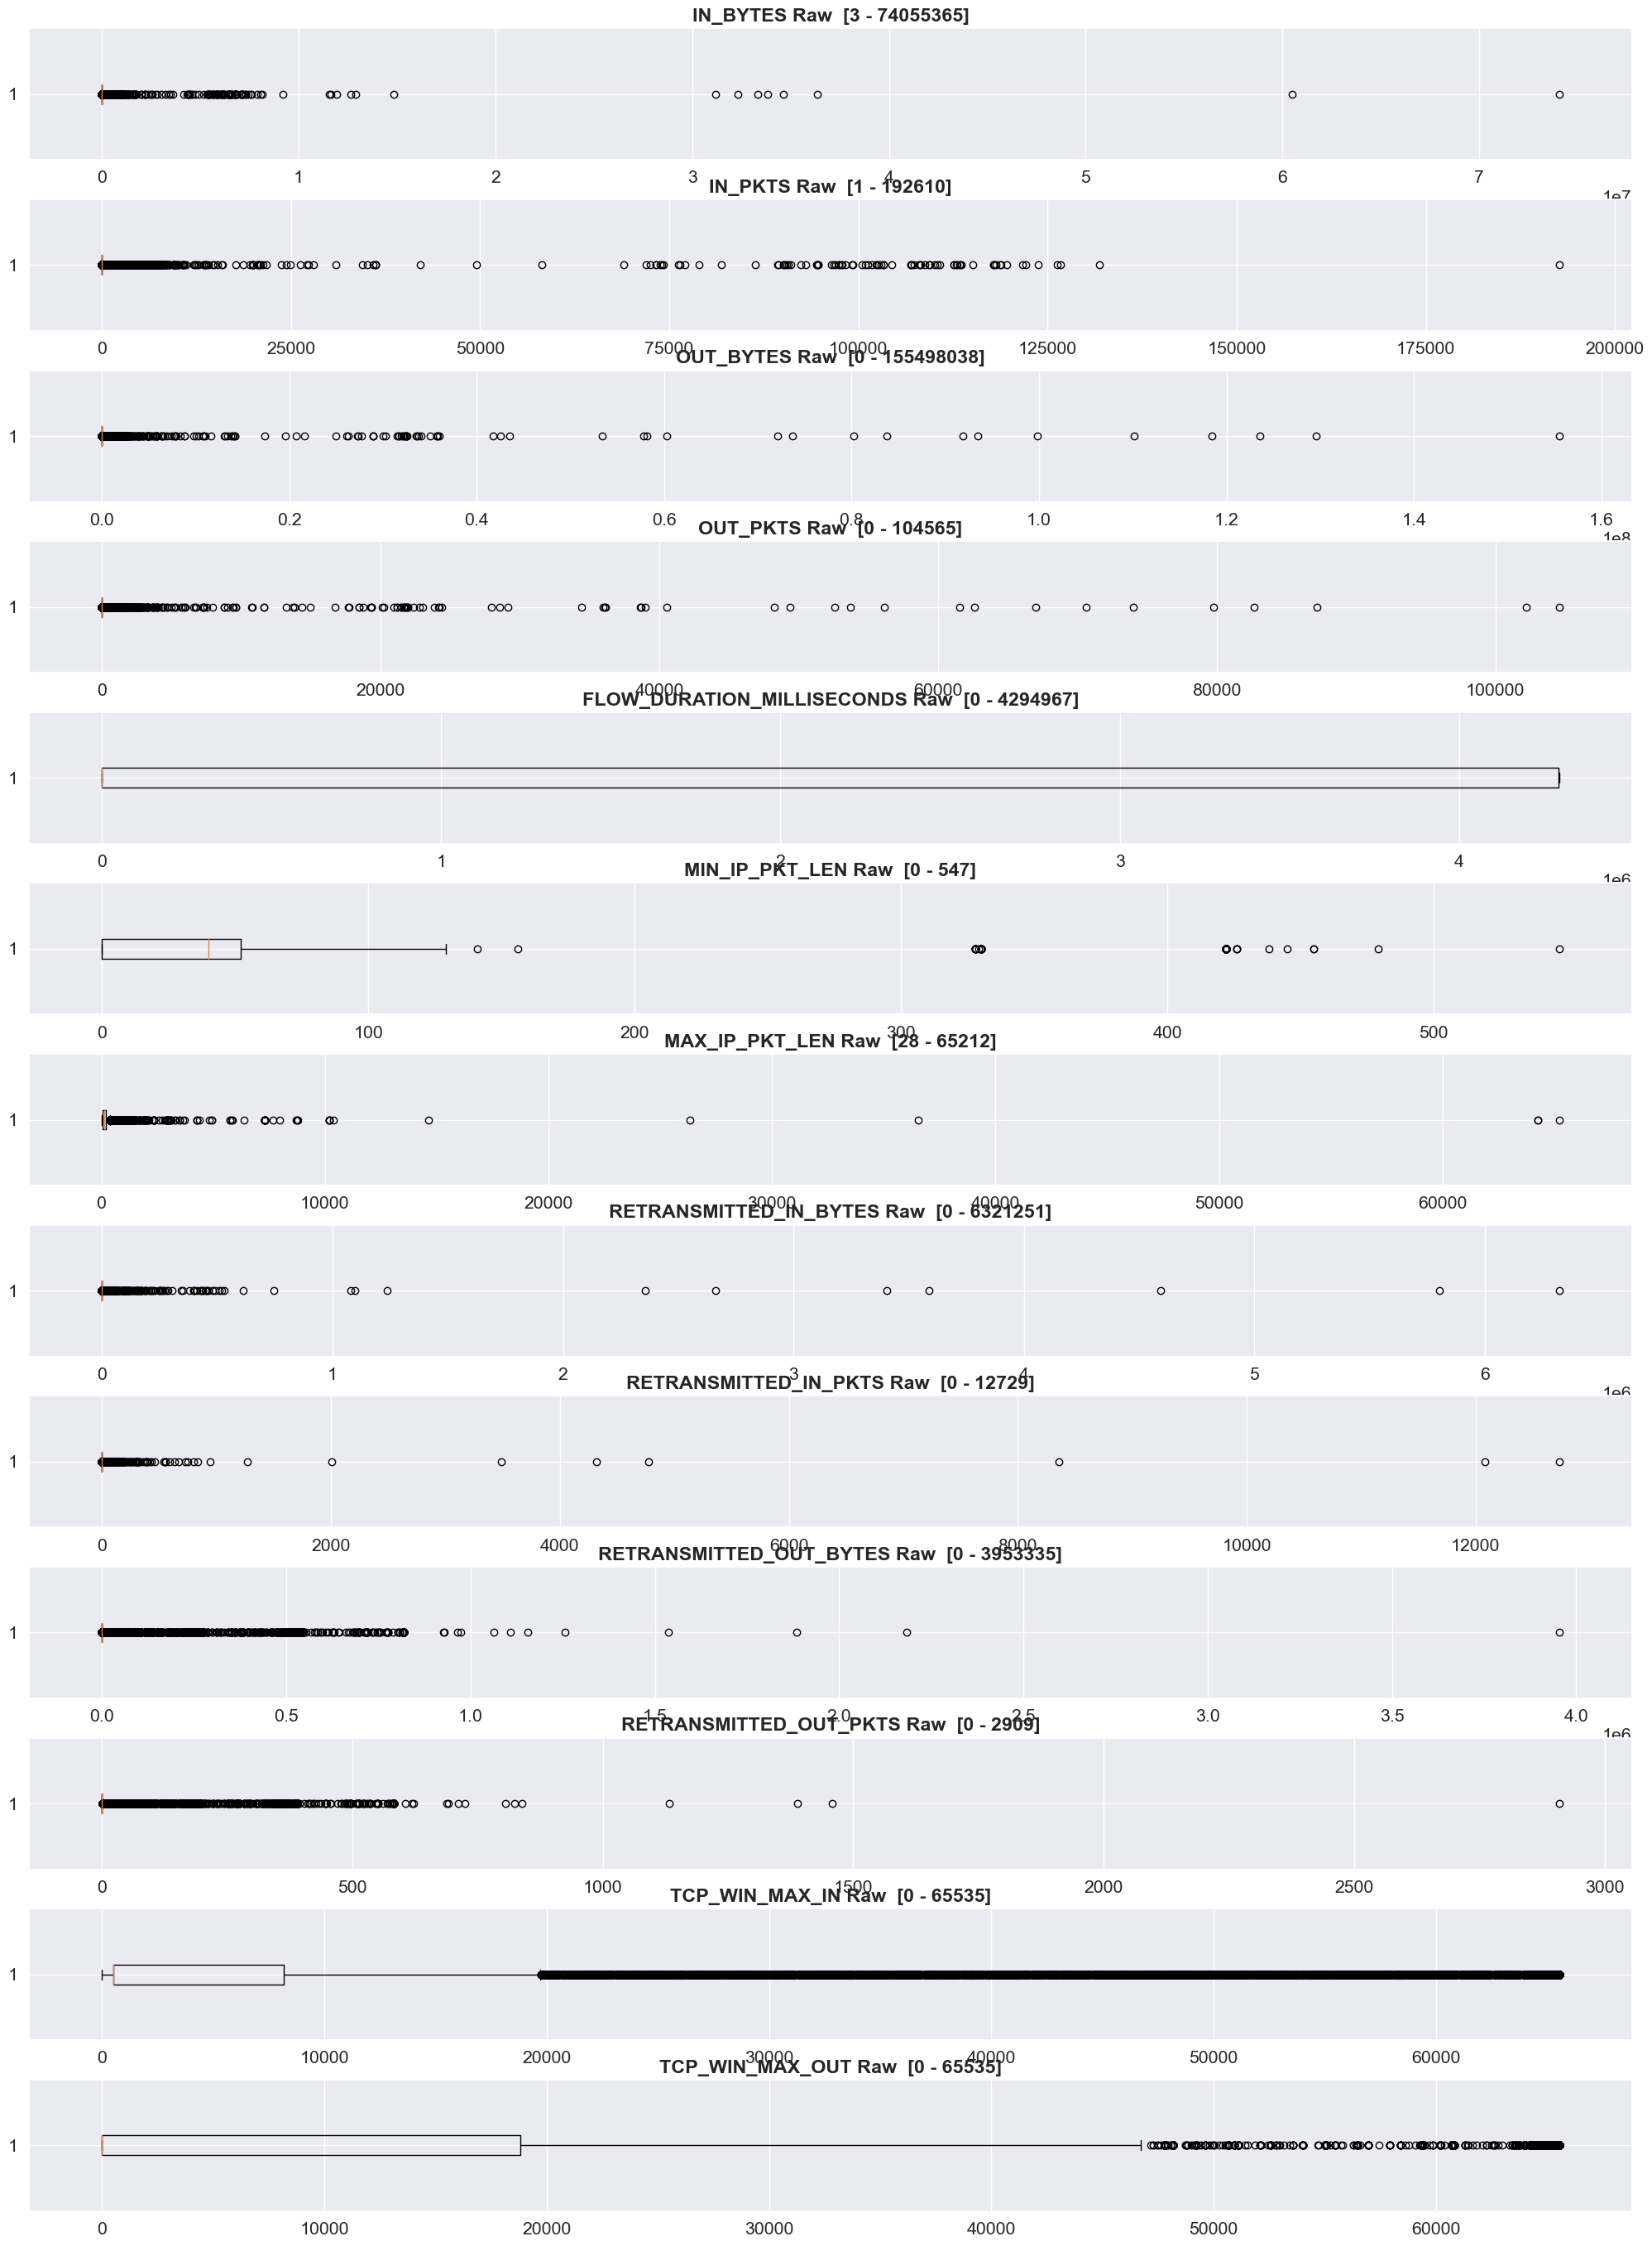

In [40]:
cols = ["IN_BYTES","IN_PKTS","OUT_BYTES","OUT_PKTS","FLOW_DURATION_MILLISECONDS","MIN_IP_PKT_LEN","MAX_IP_PKT_LEN","RETRANSMITTED_IN_BYTES","RETRANSMITTED_IN_PKTS","RETRANSMITTED_OUT_BYTES","RETRANSMITTED_OUT_PKTS","TCP_WIN_MAX_IN","TCP_WIN_MAX_OUT"]
fig_nr_columns = 1
fig_nr_rows = 17
fig = plt.figure(1, figsize=[25,45])

for k in range(len(cols)):
    num_bins = 100
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+1)
    yvalues = np.array(df[cols[k]].dropna())
    ax.boxplot(yvalues, vert=False)
    plt.title("{} Raw  [{} - {}]".format(cols[k], yvalues.min(), yvalues.max()), fontweight='bold')
plt.show()

In [25]:
# Piora a performance do modelo

out_cols = ["IN_BYTES","IN_PKTS","OUT_BYTES","OUT_PKTS","FLOW_DURATION_MILLISECONDS","MIN_IP_PKT_LEN","MAX_IP_PKT_LEN","RETRANSMITTED_IN_BYTES","RETRANSMITTED_IN_PKTS","RETRANSMITTED_OUT_BYTES","RETRANSMITTED_OUT_PKTS","TCP_WIN_MAX_IN","TCP_WIN_MAX_OUT"]

def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

def impute_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   upper = df[~(df>(q3+1.5*IQR))].max()
   lower = df[~(df<(q1-1.5*IQR))].min()

   df = np.where(df > upper,
       df.mean(),
       np.where(
           df < lower,
           df.mean(),
           df
           )
       )

   return df

#df[out_cols] = impute_outliers_IQR(df[out_cols])



In [70]:
df_nf.describe()

L4_SRC_PORT   L4_DST_PORT      PROTOCOL      IN_BYTES       IN_PKTS  \
count  3.000000e+06  3.000000e+06  3.000000e+06  3.000000e+06  3.000000e+06   
mean   4.038722e+04  3.350640e+03  1.024170e+01  9.915695e+02  9.670526e+00   
std    1.842122e+04  1.068101e+04  5.654876e+00  8.326632e+04  5.763028e+02   
min    0.000000e+00  0.000000e+00  0.000000e+00  3.000000e+00  1.000000e+00   
25%    2.724000e+04  8.000000e+01  6.000000e+00  5.600000e+01  1.000000e+00   
50%    4.573000e+04  8.000000e+01  6.000000e+00  1.120000e+02  2.000000e+00   
75%    5.504500e+04  4.430000e+02  1.700000e+01  2.800000e+02  3.000000e+00   
max    6.553500e+04  6.553500e+04  2.550000e+02  7.405536e+07  1.926100e+05   

          OUT_BYTES      OUT_PKTS     TCP_FLAGS  FLOW_DURATION_MILLISECONDS  \
count  3.000000e+06  3.000000e+06  3.000000e+06                3.000000e+06   
mean   3.034575e+03  4.649585e+00  2.418990e+01                2.315053e+06   
std    2.536018e+05  1.928144e+02  5.845195e+01                2.140399e+06   
min    0.000000e+00  0.000000e+00  0.000000e+00                0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00                0.000000e+00   
50%    0.000000e+00  0.000000e+00  2.000000e+00                4.293061e+06   
75%    1.520000e+02  1.000000e+00  2.200000e+01                4.294029e+06   
max    1.554980e+08  1.045650e+05  2.230000e+02                4.294967e+06   

       MIN_IP_PKT_LEN  MAX_IP_PKT_LEN  SRC_TO_DST_SECOND_BYTES  \
count    3.000000e+06    3.000000e+06             3.000000e+06   
mean     2.356534e+01    2.649258e+02            2.196007e+298   
std      2.696914e+01    4.320319e+02                      inf   
min      0.000000e+00    2.800000e+01             0.000000e+00   
25%      0.000000e+00    4.000000e+01             6.800000e+01   
50%      0.000000e+00    1.000000e+02             1.408000e+03   
75%      4.000000e+01    1.400000e+02             3.806000e+03   
max      5.470000e+02    6.521200e+04            6.588022e+304   

       DST_TO_SRC_SECOND_BYTES  RETRANSMITTED_IN_BYTES  RETRANSMITTED_IN_PKTS  \
count             3.000000e+06            3.000000e+06           3.000000e+06   
mean             1.386680e+151            8.017808e+01           3.958197e-01   
std                        inf            6.931635e+03           1.240083e+01   
min               0.000000e+00            0.000000e+00           0.000000e+00   
25%               0.000000e+00            0.000000e+00           0.000000e+00   
50%               0.000000e+00            0.000000e+00           0.000000e+00   
75%               1.640000e+02            0.000000e+00           0.000000e+00   
max              4.160041e+157            6.321251e+06           1.272900e+04   

       RETRANSMITTED_OUT_BYTES  RETRANSMITTED_OUT_PKTS  TCP_WIN_MAX_IN  \
count             3.000000e+06            3.000000e+06    3.000000e+06   
mean              5.691843e+02            5.734313e-01    6.023915e+03   
std               1.408053e+04            1.007526e+01    1.324776e+04   
min               0.000000e+00            0.000000e+00    0.000000e+00   
25%               0.000000e+00            0.000000e+00    0.000000e+00   
50%               0.000000e+00            0.000000e+00    5.120000e+02   
75%               0.000000e+00            0.000000e+00    4.096000e+03   
max               3.953335e+06            2.909000e+03    6.553500e+04   

       TCP_WIN_MAX_OUT         Label  
count     3.000000e+06  3.000000e+06  
mean      8.379874e+03  6.690783e-01  
std       1.769573e+04  4.705450e-01  
min       0.000000e+00  0.000000e+00  
25%       0.000000e+00  0.000000e+00  
50%       0.000000e+00  1.000000e+00  
75%       0.000000e+00  1.000000e+00  
max       6.553500e+04  1.000000e+00

In [40]:
from sklearn.impute import SimpleImputer

def prepare_dataset(df, handle=False, attack_encoder=None, l7_proto_encoder=None):
    df_cpy = df.copy()
    df_cpy = df_cpy.drop_duplicates()

    # Handle IPs
    #df_cpy.loc[:,'IPV4_SRC_ADDR'] = df_cpy['IPV4_SRC_ADDR'].copy().apply(ip2long)
    #df_cpy.loc[:,'IPV4_DST_ADDR'] = df_cpy['IPV4_DST_ADDR'].copy().apply(ip2long)

    if handle:
        #df_cpy['DST_TO_SRC_SECOND_BYTES_MEAN'] = df_cpy.DST_TO_SRC_SECOND_BYTES.apply(spb_to_mean)
        df_cpy['DST_TO_SRC_SECOND_BYTES'] = df_cpy.DST_TO_SRC_SECOND_BYTES.apply(spb_to_total)
        #df_cpy['SRC_TO_DST_SECOND_BYTES_MEAN'] = df_cpy.SRC_TO_DST_SECOND_BYTES.apply(spb_to_mean)
        df_cpy['SRC_TO_DST_SECOND_BYTES'] = df_cpy.SRC_TO_DST_SECOND_BYTES.apply(spb_to_total)
        
        #df_cpy['DST_TO_SRC_SECOND_BYTES_MEAN'] = np.log(df_cpy['DST_TO_SRC_SECOND_BYTES_MEAN'] + 1)
        #df_cpy['DST_TO_SRC_SECOND_BYTES'] = np.log(df_cpy['DST_TO_SRC_SECOND_BYTES'] + 1)
        #df_cpy['SRC_TO_DST_SECOND_BYTES_MEAN'] = np.log(df_cpy['SRC_TO_DST_SECOND_BYTES_MEAN'] + 1)
        #df_cpy['SRC_TO_DST_SECOND_BYTES'] = np.log(df_cpy['SRC_TO_DST_SECOND_BYTES'] + 1)

    df_cpy['DST_TO_SRC_SECOND_BYTES'] = np.log(df_cpy['DST_TO_SRC_SECOND_BYTES'] + 1)
    df_cpy['SRC_TO_DST_SECOND_BYTES'] = np.log(df_cpy['SRC_TO_DST_SECOND_BYTES'] + 1)
        

    
    #df_cpy = df_cpy.drop(['DST_TO_SRC_SECOND_BYTES', 'SRC_TO_DST_SECOND_BYTES', 'PROTOCOL_MAP'], axis=1)
    df_cpy = df_cpy.drop(['PROTOCOL_MAP', 'IPV4_SRC_ADDR', 'IPV4_DST_ADDR'], axis=1)

    if not attack_encoder:
        attack_encoder = LabelEncoder()
        df_cpy['AttackEnc'] = attack_encoder.fit_transform(df_cpy.Attack)
    else:
        df_cpy['AttackEnc'] = attack_encoder.transform(df_cpy.Attack)

    if not l7_proto_encoder:
        l7_proto_encoder = LabelEncoder()
        l7_proto_encoder.fit(df_cpy['L7_PROTO_NAME'])
        df_cpy['L7_PROTO_NAME'] = l7_proto_encoder.transform(df_cpy['L7_PROTO_NAME'])
        df_cpy = df_cpy[df_cpy['L7_PROTO_NAME'].notna()]
    else:
        df_cpy['L7_PROTO_NAME'] = l7_proto_encoder.transform(df_cpy['L7_PROTO_NAME'])
        df_cpy = df_cpy[df_cpy['L7_PROTO_NAME'].notna()]



    return df_cpy, attack_encoder, l7_proto_encoder
    
#dataset, ae, l7pe = prepare_dataset(df_nf)

In [46]:
dataset

L4_SRC_PORT  L4_DST_PORT  PROTOCOL  IN_BYTES  IN_PKTS  OUT_BYTES  \
0              65389           80         6       420        3          0   
1              11154           80         6       280        2         40   
2              42062         1041         6        44        1         40   
3              46849         9110         6        44        1         40   
4              50360         1084         6        44        1         40   
...              ...          ...       ...       ...      ...        ...   
2999995        46950           80        17        84        3          0   
2999996        64089           53        17        68        1        167   
2999997        23078           80        17        56        2          0   
2999998        38764           53        17        65        1         81   
2999999        54774           21         6       701       13       1054   

         OUT_PKTS  TCP_FLAGS  FLOW_DURATION_MILLISECONDS  MIN_IP_PKT_LEN  \
0               0          2                     4293092               0   
1               1         22                     4294499              40   
2               1         22                           0              40   
3               1         22                           0              40   
4               1         22                           0              40   
...           ...        ...                         ...             ...   
2999995         0          0                     4293463               0   
2999996         1          0                           0              68   
2999997         0          0                     4294186               0   
2999998         1          0                           0              65   
2999999        15         24                           0              52   

         MAX_IP_PKT_LEN  SRC_TO_DST_SECOND_BYTES  DST_TO_SRC_SECOND_BYTES  \
0                   140                 140280.0                      0.0   
1                   140                    280.0                     40.0   
2                    44                     44.0                     40.0   
3                    44                     44.0                     40.0   
4                    44                     44.0                     40.0   
...                 ...                      ...                      ...   
2999995              28                   2856.0                      0.0   
2999996             167                     68.0                    167.0   
2999997              28                     56.0                      0.0   
2999998              81                     65.0                     81.0   
2999999             106                   1148.0                   1296.0   

         RETRANSMITTED_IN_BYTES  RETRANSMITTED_IN_PKTS  \
0                           140                      1   
1                             0                      0   
2                             0                      0   
3                             0                      0   
4                             0                      0   
...                         ...                    ...   
2999995                       0                      0   
2999996                       0                      0   
2999997                       0                      0   
2999998                       0                      0   
2999999                     190                      3   

         RETRANSMITTED_OUT_BYTES  RETRANSMITTED_OUT_PKTS  TCP_WIN_MAX_IN  \
0                              0                       0             512   
1                              0                       0             512   
2                              0                       0            1024   
3                              0                       0            1024   
4                              0                       0            1024   
...                          ...                     ...             ...   
2999995          

In [168]:
l7pe.transform(pd.DataFrame([{ 'L7_PROTO_NAME': 'CBT' }])['L7_PROTO_NAME'])

array([12])

In [73]:
print(len(dataset.columns))

384


In [65]:
dataset.head()

IPV4_SRC_ADDR  L4_SRC_PORT  IPV4_DST_ADDR  L4_DST_PORT  PROTOCOL  IN_BYTES  \
1      760179200            0      175300864            0         1        68   
2      175300608          443      175304960        24650         6       189   
5     2887729664        51860     1298005504          443         6       152   
6     3232235776        56402     3232235776         9012         6       232   
8     3288071936            0      175300608            0         1        32   

   IN_PKTS  OUT_BYTES  OUT_PKTS  TCP_FLAGS  FLOW_DURATION_MILLISECONDS  \
1        1          0         0          0                           0   
2        2        104         2         25                          44   
5        3        120         3        214                           0   
6        4        132         3         31                           0   
8        1          0         0          0                           0   

   MIN_IP_PKT_LEN  MAX_IP_PKT_LEN  RETRANSMITTED_IN_BYTES  \
1               0               0                       0   
2               0               0                       0   
5              40              52                       0   
6              40              92                       0   
8               0               0                       0   

   RETRANSMITTED_IN_PKTS  RETRANSMITTED_OUT_BYTES  RETRANSMITTED_OUT_PKTS  \
1                      0                        0                       0   
2                      0                        0                       0   
5                      0                        0                       0   
6                      0                        0                       0   
8                      0                        0                       0   

   TCP_WIN_MAX_IN  TCP_WIN_MAX_OUT  Label  Attack  \
1               0                0      0  Benign   
2             122             1634      0  Benign   
5            8192                0      0  Benign   
6           29200            65535      0  Benign   
8               0                0      0  Benign   

   DST_TO_SRC_SECOND_BYTES_MEAN  DST_TO_SRC_SECOND_BYTES_TOTAL  \
1                           0.0                            0.0   
2                         104.0                          104.0   
5                         120.0                          120.0   
6                         132.0                          132.0   
8                           0.0                            0.0   

   SRC_TO_DST_SECOND_BYTES_MEAN  SRC_TO_DST_SECOND_BYTES_TOTAL  AttackEnc  \
1                          68.0                           68.0          2   
2                         189.0                          189.0          2   
5                         152.0                          152.0          2   
6                         232.0                          232.0          2   
8                          32.0                           32.0          2   

   P_udp  P_tcp  P_icmp  P_gre   P_  P_ipv6-icmp  L_SIP  L_TLS  L_TLS.Google  \
1    0.0    0.0     0.0    0.0  1.0          0.0    0.0    0.0           0.0   
2    0.0    0.0     0.0    0.0  1.0          0.0    0.0    0.0           0.0   
5    0.0    0.0     1.0    0.0  0.0          0.0    0.0    0.0           0.0   
6    0.0    0.0     0.0    0.0  1.0          0.0    0.0    0.0           0.0   
8    0.0    0.0     0.0    0.0  0.0          1.0    0.0    0.0           0.0   

   L_ICMP.Amazon  L_DNS.Yahoo  L_DNS  L_DNS.Google  L_DNS.Microsoft  \
1            0.0          0.0    0.0           0.0              0.0   
2            0.0          0.0    0.0           0.0              0.0   
5            0.0          0.0    0.0           0.0              0.0   
6            0.0          0.0    0.0           0.0              0.0   
8            0.0          0.0    0.0           0.0              0.0   

   L_Unknown  L_NTP  L_BitTorrent  L_DNS.Facebook  L_ICMP  L_QUIC.Google  \
1        0.0    0.0           0.0             0.0     0.0            0.0   
2 

## Best features selection
### SelectKBest

In [138]:
kbest = SelectKBest(chi2, k=12)
X_new = kbest.fit_transform(dataset.drop(['Label', 'Attack', 'AttackEnc'], axis=1), dataset.Label)
kbest.get_feature_names_out()

array(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'IN_BYTES',
       'OUT_BYTES', 'FLOW_DURATION_MILLISECONDS', 'TCP_WIN_MAX_IN',
       'TCP_WIN_MAX_OUT', 'DST_TO_SRC_SECOND_BYTES_MEAN',
       'DST_TO_SRC_SECOND_BYTES_TOTAL', 'SRC_TO_DST_SECOND_BYTES_MEAN',
       'SRC_TO_DST_SECOND_BYTES_TOTAL'], dtype=object)

In [139]:
kbest = SelectKBest(chi2, k=12)
X_new = kbest.fit_transform(dataset.drop(['Label', 'Attack'], axis=1), dataset.AttackEnc)
kbest.get_feature_names_out()

array(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'IN_BYTES',
       'OUT_BYTES', 'FLOW_DURATION_MILLISECONDS', 'TCP_WIN_MAX_IN',
       'TCP_WIN_MAX_OUT', 'DST_TO_SRC_SECOND_BYTES_MEAN',
       'DST_TO_SRC_SECOND_BYTES_TOTAL', 'SRC_TO_DST_SECOND_BYTES_MEAN',
       'SRC_TO_DST_SECOND_BYTES_TOTAL'], dtype=object)

### Feature importance
#### Label

In [56]:
dataset['DST_TO_SRC_SECOND_BYTES'] = np.log(dataset['DST_TO_SRC_SECOND_BYTES'] + 1)
dataset['SRC_TO_DST_SECOND_BYTES'] = np.log(dataset['SRC_TO_DST_SECOND_BYTES'] + 1)

In [57]:
dataset.describe()

L4_SRC_PORT   L4_DST_PORT      PROTOCOL      IN_BYTES       IN_PKTS  \
count  3.000000e+06  3.000000e+06  3.000000e+06  3.000000e+06  3.000000e+06   
mean   4.038722e+04  3.350640e+03  1.024170e+01  9.915695e+02  9.670526e+00   
std    1.842122e+04  1.068101e+04  5.654876e+00  8.326632e+04  5.763028e+02   
min    0.000000e+00  0.000000e+00  0.000000e+00  3.000000e+00  1.000000e+00   
25%    2.724000e+04  8.000000e+01  6.000000e+00  5.600000e+01  1.000000e+00   
50%    4.573000e+04  8.000000e+01  6.000000e+00  1.120000e+02  2.000000e+00   
75%    5.504500e+04  4.430000e+02  1.700000e+01  2.800000e+02  3.000000e+00   
max    6.553500e+04  6.553500e+04  2.550000e+02  7.405536e+07  1.926100e+05   

          OUT_BYTES      OUT_PKTS     TCP_FLAGS  FLOW_DURATION_MILLISECONDS  \
count  3.000000e+06  3.000000e+06  3.000000e+06                3.000000e+06   
mean   3.034575e+03  4.649585e+00  2.418990e+01                2.315053e+06   
std    2.536018e+05  1.928144e+02  5.845195e+01                2.140399e+06   
min    0.000000e+00  0.000000e+00  0.000000e+00                0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00                0.000000e+00   
50%    0.000000e+00  0.000000e+00  2.000000e+00                4.293061e+06   
75%    1.520000e+02  1.000000e+00  2.200000e+01                4.294029e+06   
max    1.554980e+08  1.045650e+05  2.230000e+02                4.294967e+06   

       MIN_IP_PKT_LEN  MAX_IP_PKT_LEN  SRC_TO_DST_SECOND_BYTES  \
count    3.000000e+06    3.000000e+06             3.000000e+06   
mean     2.356534e+01    2.649258e+02             7.340954e+00   
std      2.696914e+01    4.320319e+02             3.468027e+00   
min      0.000000e+00    2.800000e+01             0.000000e+00   
25%      0.000000e+00    4.000000e+01             4.234107e+00   
50%      0.000000e+00    1.000000e+02             7.250636e+00   
75%      4.000000e+01    1.400000e+02             8.244597e+00   
max      5.470000e+02    6.521200e+04             7.018711e+02   

       DST_TO_SRC_SECOND_BYTES  RETRANSMITTED_IN_BYTES  RETRANSMITTED_IN_PKTS  \
count             3.000000e+06            3.000000e+06           3.000000e+06   
mean              2.776262e+00            8.017808e+01           3.958197e-01   
std               3.363671e+00            6.931635e+03           1.240083e+01   
min               0.000000e+00            0.000000e+00           0.000000e+00   
25%               0.000000e+00            0.000000e+00           0.000000e+00   
50%               0.000000e+00            0.000000e+00           0.000000e+00   
75%               5.105945e+00            0.000000e+00           0.000000e+00   
max               3.629314e+02            6.321251e+06           1.272900e+04   

       RETRANSMITTED_OUT_BYTES  RETRANSMITTED_OUT_PKTS  TCP_WIN_MAX_IN  \
count             3.000000e+06            3.000000e+06    3.000000e+06   
mean              5.691843e+02            5.734313e-01    6.023915e+03   
std               1.408053e+04            1.007526e+01    1.324776e+04   
min               0.000000e+00            0.000000e+00    0.000000e+00   
25%               0.000000e+00            0.000000e+00    0.000000e+00   
50%               0.000000e+00            0.000000e+00    5.120000e+02   
75%               0.000000e+00            0.000000e+00    4.096000e+03   
max               3.953335e+06            2.909000e+03    6.553500e+04   

       TCP_WIN_MAX_OUT         Label  L7_PROTO_NAME     AttackEnc  
count     3.000000e+06  3.000000e+06   3.000000e+06  3.000000e+06  
mean      8.379874e+03  6.690783e-01   2.565329e+01  5.910750e+00  
std       1.769573e+04  4.705450e-01   2.100928e+01  4.882801e+00  
min       0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00  
25%       0.000000e+00  0.000000e+00   4.000000e+00  2.000000e+00  
50%       0.000000e+00  1.000000e+00   2.000000e+01  5.000000e+00  
75%       0.000000e+00  1.000000e+00   4.700000e+01  6.000000e+00  
max       6.553500e+04  1.000000e+00   5.800000e

<AxesSubplot:>

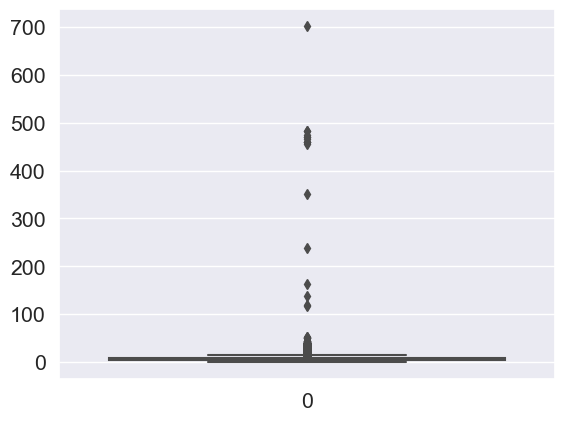

In [71]:
sns.boxplot(data=dataset['SRC_TO_DST_SECOND_BYTES'])

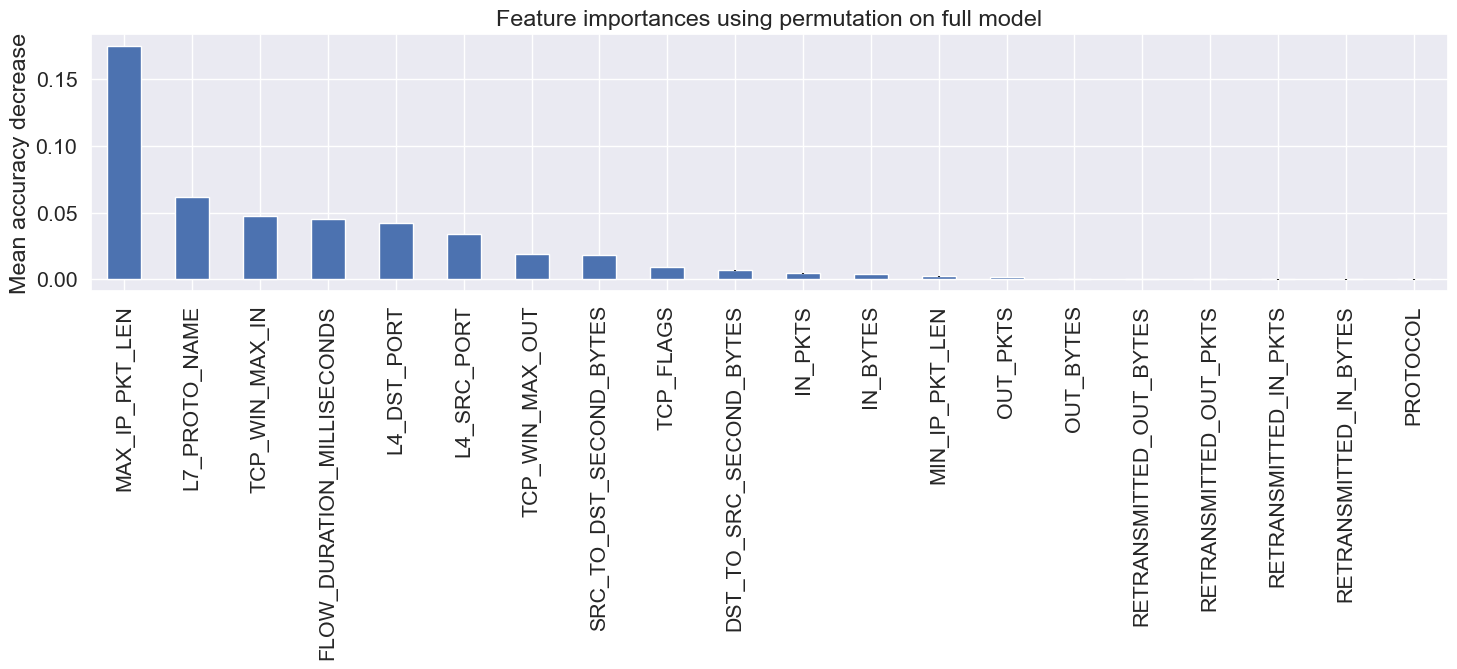

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score

nums = dataset_nf.select_dtypes(include=np.number)

X = nums.drop(columns=['Label', 'AttackEnc'], axis=1)
"""y = nums.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

forest = RandomForestClassifier(random_state=2022)
forest.fit(X_train, y_train)

result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=2022, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15, 7))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()"""

y = nums.AttackEnc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

forest = RandomForestClassifier(random_state=2022)
forest.fit(X_train, y_train)

result = permutation_importance(
    forest, X_test, y_test, n_repeats=5, random_state=2022, n_jobs=1
)
forest_importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15, 7))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [96]:
forest_importances.index

Index(['MAX_IP_PKT_LEN', 'L7_PROTO_NAME', 'TCP_WIN_MAX_IN',
       'FLOW_DURATION_MILLISECONDS', 'L4_DST_PORT', 'L4_SRC_PORT',
       'TCP_WIN_MAX_OUT', 'SRC_TO_DST_SECOND_BYTES', 'TCP_FLAGS',
       'DST_TO_SRC_SECOND_BYTES', 'IN_PKTS', 'IN_BYTES', 'MIN_IP_PKT_LEN',
       'OUT_PKTS', 'OUT_BYTES', 'RETRANSMITTED_OUT_BYTES',
       'RETRANSMITTED_OUT_PKTS', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_IN_BYTES', 'PROTOCOL'],
      dtype='object')

In [62]:
np.unique(dataset.Attack)

array(['Analysis', 'Backdoor', 'Benign', 'Bot', 'Brute Force', 'DDoS',
       'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Infilteration',
       'Reconnaissance', 'Shellcode', 'Theft', 'Worms', 'injection',
       'mitm', 'password', 'ransomware', 'scanning', 'xss'], dtype=object)

### Model training
#### Full dataset - Label

In [41]:
attack_encoder = LabelEncoder()
attack_encoder.fit(np.concatenate((df_nf.Attack.values, df_simargl.Attack.values)))

l7_proto_encoder = LabelEncoder()
l7_proto_encoder.fit(np.concatenate((df_nf.L7_PROTO_NAME.values, df_simargl.L7_PROTO_NAME.values)))


LabelEncoder()

In [59]:
dataset_nf, ae, l7pe = prepare_dataset(df_nf, l7_proto_encoder=l7_proto_encoder, attack_encoder=attack_encoder)
dataset_simargl, ae, l7pe = prepare_dataset(df_simargl, handle=True, l7_proto_encoder=l7_proto_encoder, attack_encoder=attack_encoder)

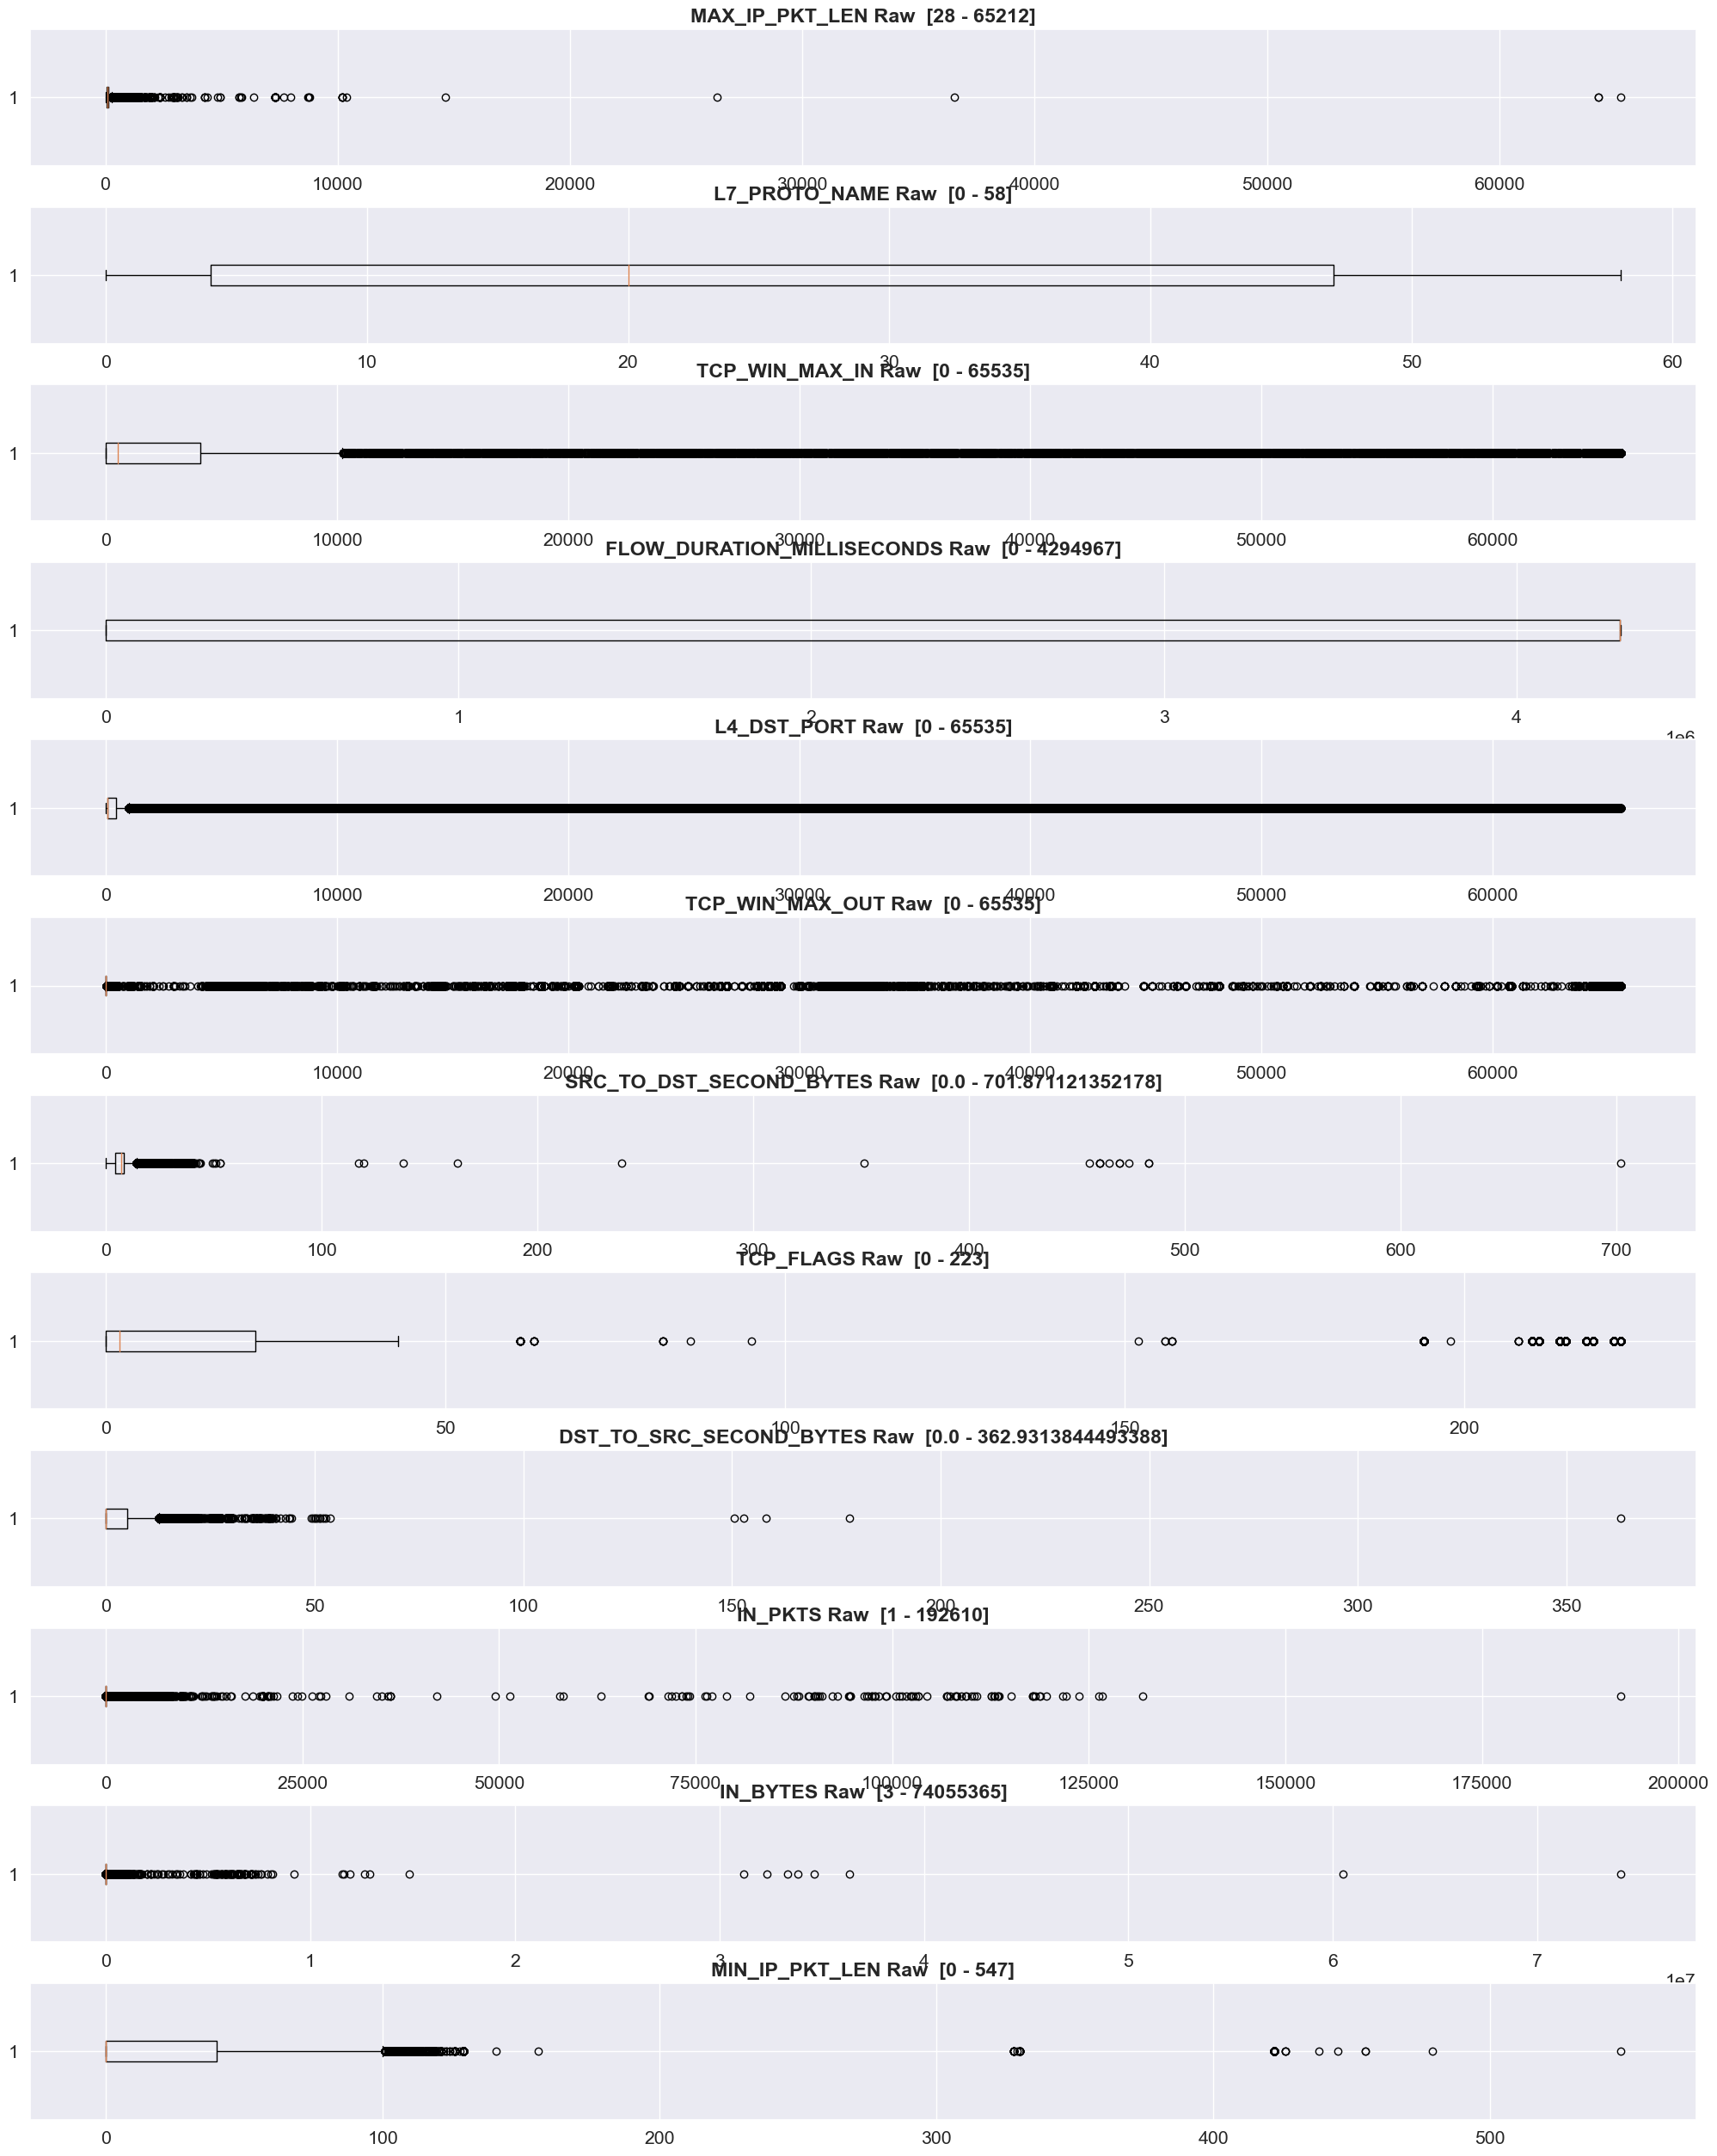

In [106]:
cols = ['MAX_IP_PKT_LEN', 'L7_PROTO_NAME', 'TCP_WIN_MAX_IN',
       'FLOW_DURATION_MILLISECONDS', 'L4_DST_PORT',
       'TCP_WIN_MAX_OUT', 'SRC_TO_DST_SECOND_BYTES', 'TCP_FLAGS',
       'DST_TO_SRC_SECOND_BYTES', 'IN_PKTS', 'IN_BYTES', 'MIN_IP_PKT_LEN']
fig_nr_columns = 1
fig_nr_rows = 17
fig = plt.figure(1, figsize=[25,45])

for k in range(len(cols)):
    num_bins = 100
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+1)
    yvalues = np.array(dataset_nf[cols[k]].dropna())
    ax.boxplot(yvalues, vert=False)
    plt.title("{} Raw  [{} - {}]".format(cols[k], yvalues.min(), yvalues.max()), fontweight='bold')
plt.show()

In [29]:
dataset_nf[cols] = impute_outliers_IQR(dataset_nf[cols])
dataset_simargl[cols] = impute_outliers_IQR(dataset_simargl[cols])

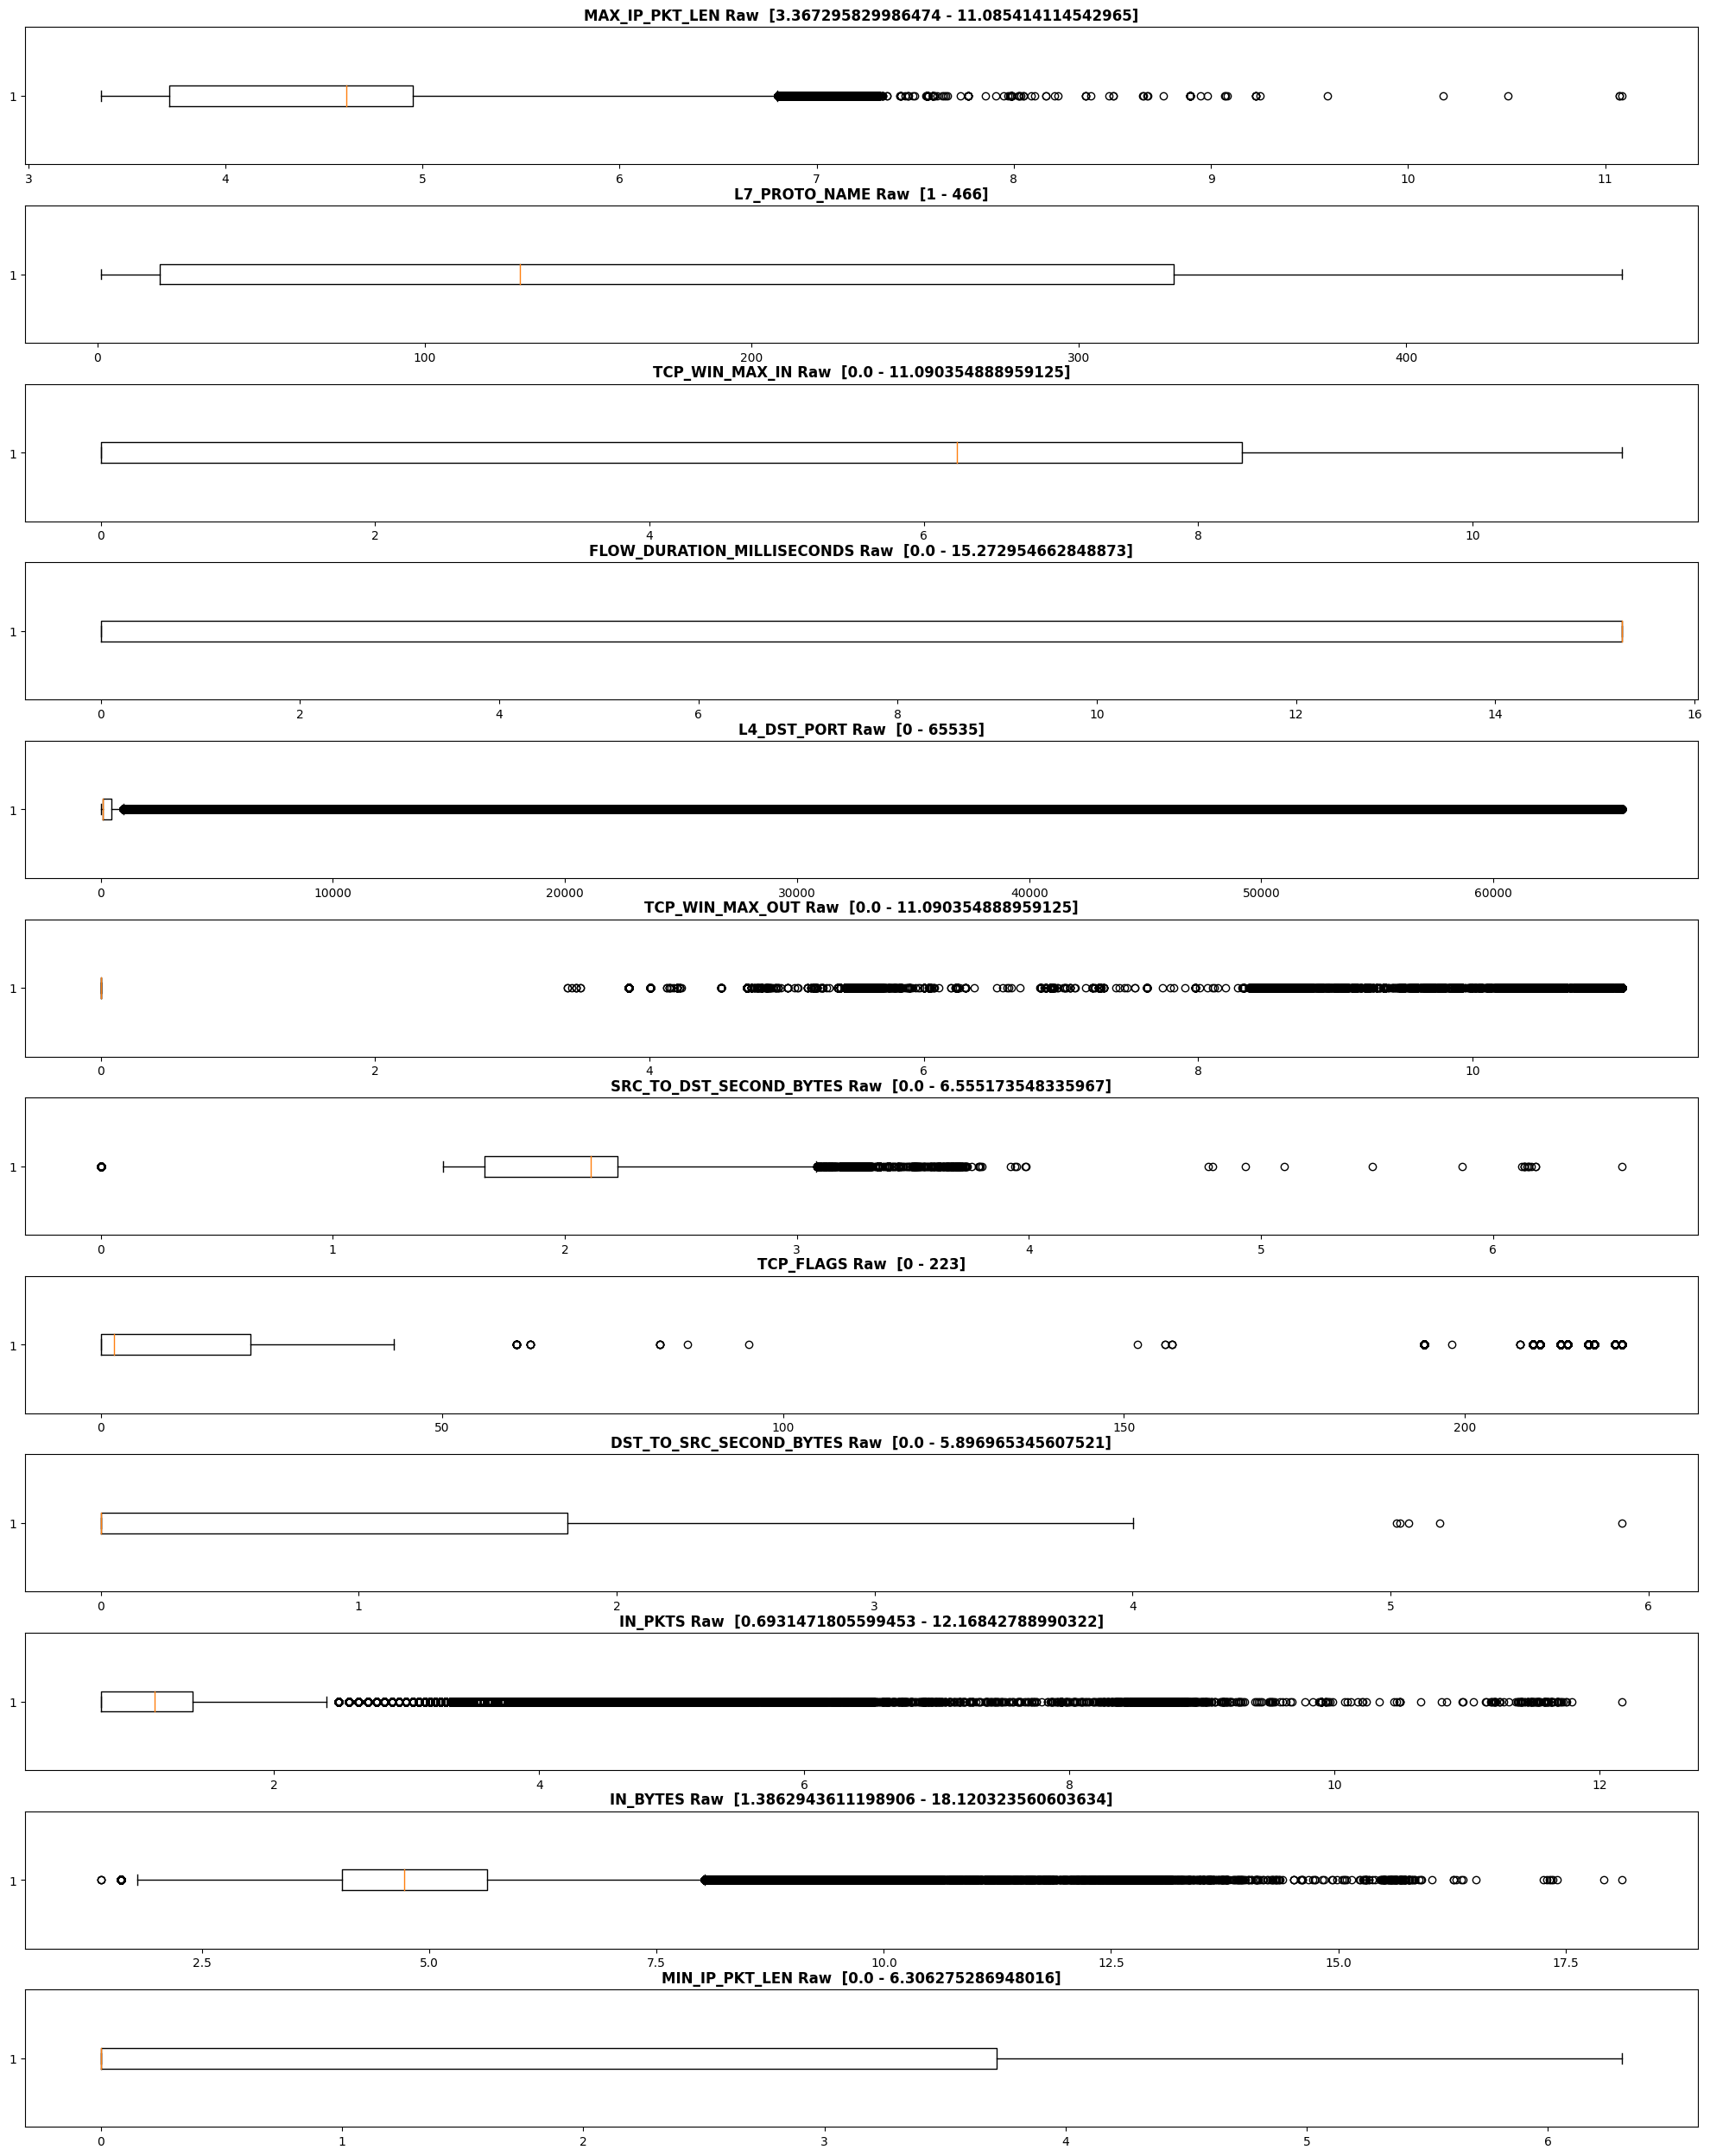

In [58]:
cols = ['MAX_IP_PKT_LEN', 'L7_PROTO_NAME', 'TCP_WIN_MAX_IN',
       'FLOW_DURATION_MILLISECONDS', 'L4_DST_PORT',
       'TCP_WIN_MAX_OUT', 'SRC_TO_DST_SECOND_BYTES', 'TCP_FLAGS',
       'DST_TO_SRC_SECOND_BYTES', 'IN_PKTS', 'IN_BYTES', 'MIN_IP_PKT_LEN']
fig_nr_columns = 1
fig_nr_rows = 17
fig = plt.figure(1, figsize=[25,45])

for k in range(len(cols)):
    num_bins = 100
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+1)
    yvalues = np.array(dataset_nf[cols[k]].dropna())
    ax.boxplot(yvalues, vert=False)
    plt.title("{} Raw  [{} - {}]".format(cols[k], yvalues.min(), yvalues.max()), fontweight='bold')
plt.show()

In [86]:
np.unique(dataset_simargl.Attack), np.unique(dataset.Attack)

(array(['Benign', 'NULL Scan', 'SYN Scan - aggressive', 'XMAS Scan'],
       dtype=object),
 array(['Analysis', 'Backdoor', 'Benign', 'Bot', 'Brute Force', 'DDoS',
        'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Infilteration',
        'Reconnaissance', 'Shellcode', 'Theft', 'Worms', 'injection',
        'mitm', 'password', 'ransomware', 'scanning', 'xss'], dtype=object))

In [49]:


cols = ['MAX_IP_PKT_LEN', 'TCP_WIN_MAX_IN',
       'FLOW_DURATION_MILLISECONDS',
       'TCP_WIN_MAX_OUT', 'SRC_TO_DST_SECOND_BYTES',
       'DST_TO_SRC_SECOND_BYTES', 'IN_PKTS', 'IN_BYTES', 'MIN_IP_PKT_LEN',
       'OUT_PKTS', 'OUT_BYTES', 'RETRANSMITTED_OUT_BYTES',
       'RETRANSMITTED_OUT_PKTS', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_IN_BYTES']

dataset_nf[cols] = np.log(dataset_nf[cols] + 1)
dataset_simargl[cols] = np.log(dataset_simargl[cols] + 1)


In [55]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#'L4_SRC_PORT', 'L4_DST_PORT',
cols = [ 'PROTOCOL', 'IN_BYTES', 'IN_PKTS', # 'L4_SRC_PORT', 'L4_DST_PORT',
       'OUT_BYTES', 'OUT_PKTS', 'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS',
       'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES',
       'DST_TO_SRC_SECOND_BYTES', 'RETRANSMITTED_IN_BYTES',
       'RETRANSMITTED_IN_PKTS', 'RETRANSMITTED_OUT_BYTES',
       'RETRANSMITTED_OUT_PKTS', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT', 'L7_PROTO_NAME']

nums = dataset_nf.select_dtypes(include=np.number).sample(n=500000, random_state=2022)
nums_simargl = dataset_simargl.select_dtypes(include=np.number)

X = nums[cols]
y = nums.Label
X_simargl = nums_simargl[cols]
y_simargl = nums_simargl.Label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

model_full_label = RandomForestClassifier(random_state=2022, n_estimators=300)
model_full_label.fit(X_train, y_train)

full_label_train = f1_score(y_train, model_full_label.predict(X_train), average='macro')
full_label_val = f1_score(y_test, model_full_label.predict(X_test), average='macro')
full_label_test = f1_score(y_simargl, model_full_label.predict(X_simargl), average='macro')

print("TRAIN F1-SCORE:", full_label_train)
print("VAL F1-SCORE:", full_label_val)
print("TEST F1-SCORE:", full_label_test)

TRAIN F1-SCORE: 0.9772038323245041
VAL F1-SCORE: 0.9743976654849293
TEST F1-SCORE: 0.8352970832076412


In [79]:
full_label_test = f1_score(y_simargl, model_full_label.predict(X_simargl), average='macro')
print("TEST F1-SCORE:", full_label_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


TEST F1-SCORE: 0.23167282278698886


In [80]:
X_simargl

DST_TO_SRC_SECOND_BYTES  FLOW_DURATION_MILLISECONDS  IN_BYTES  \
0                       3.713572                           0        44   
1                       0.000000                           0        68   
2                       4.653960                          44       189   
3                       0.000000                           0        52   
4                       3.713572                           1       189   
...                          ...                         ...       ...   
1330687                 9.550947                      119273     97760   
1330688                 6.947937                      105054       976   
1330689                 6.591674                      112645       728   
1330690                 8.217439                       96349      3054   
1330691                 9.120634                      116558     16578   

         IN_PKTS  L4_DST_PORT  L4_SRC_PORT  MAX_IP_PKT_LEN  MIN_IP_PKT_LEN  \
0              1        60541        22351               0               0   
1              1            0            0               0               0   
2              2        24650          443               0               0   
3              1         8728        61075               0               0   
4              2          443        39762               0               0   
...          ...          ...          ...             ...             ...   
1330687      232         3480        50053               0               0   
1330688       16           22        49308               0               0   
1330689       14        45549           80               0               0   
1330690       58        51875          443               0               0   
1330691       38          443        33790               0               0   

         OUT_BYTES  OUT_PKTS  PROTOCOL  RETRANSMITTED_IN_BYTES  \
0               40         1         6                       0   
1                0         0         1                       0   
2              104         2         6                       0   
3                0         0         6                       0   
4               40         1         6                       0   
...            ...       ...       ...                     ...   
1330687      14057       138        17                       0   
1330688       1040        12         6                       0   
1330689        728        14         6                       0   
1330690       3704        51         6                       0   
1330691       9141        45        17                       0   

         RETRANSMITTED_IN_PKTS  RETRANSMITTED_OUT_BYTES  \
0                            0                        0   
1                            0                        0   
2                            0                        0   
3                            0                        0   
4                            0                        0   
...                        ...                      ...   
1330687                      0                        0   
1330688                      0                        0   
1330689                      0                        0   
1330690                      0                        0   
1330691                      0                        0   

         RETRANSMITTED_OUT_PKTS  SRC_TO_DST_SECOND_BYTES  TCP_FLAGS  \
0                             0                 3.806662         22   
1                             0                 4.234107          0   
2                             0                 5.247024         25   
3                             0                 3.970292          2   
4                             0                 5.247024         28   
...                         ...                      ...        ...   
1330687                       0                11.490281          0   
1330688                       0                 6.884487         24   
1330689                       0           

In [81]:
X

L4_SRC_PORT  L4_DST_PORT  PROTOCOL  IN_BYTES  IN_PKTS  OUT_BYTES  \
0              65389           80         6       420        3          0   
1              11154           80         6       280        2         40   
2              42062         1041         6        44        1         40   
3              46849         9110         6        44        1         40   
4              50360         1084         6        44        1         40   
...              ...          ...       ...       ...      ...        ...   
2999995        46950           80        17        84        3          0   
2999996        64089           53        17        68        1        167   
2999997        23078           80        17        56        2          0   
2999998        38764           53        17        65        1         81   
2999999        54774           21         6       701       13       1054   

         OUT_PKTS  TCP_FLAGS  FLOW_DURATION_MILLISECONDS  MIN_IP_PKT_LEN  \
0               0          2                     4293092               0   
1               1         22                     4294499              40   
2               1         22                           0              40   
3               1         22                           0              40   
4               1         22                           0              40   
...           ...        ...                         ...             ...   
2999995         0          0                     4293463               0   
2999996         1          0                           0              68   
2999997         0          0                     4294186               0   
2999998         1          0                           0              65   
2999999        15         24                           0              52   

         MAX_IP_PKT_LEN  SRC_TO_DST_SECOND_BYTES  DST_TO_SRC_SECOND_BYTES  \
0                   140                11.851403                 0.000000   
1                   140                 5.638355                 3.713572   
2                    44                 3.806662                 3.713572   
3                    44                 3.806662                 3.713572   
4                    44                 3.806662                 3.713572   
...                 ...                      ...                      ...   
2999995              28                 7.957527                 0.000000   
2999996             167                 4.234107                 5.123964   
2999997              28                 4.043051                 0.000000   
2999998              81                 4.189655                 4.406719   
2999999             106                 7.046647                 7.167809   

         RETRANSMITTED_IN_BYTES  RETRANSMITTED_IN_PKTS  \
0                           140                      1   
1                             0                      0   
2                             0                      0   
3                             0                      0   
4                             0                      0   
...                         ...                    ...   
2999995                       0                      0   
2999996                       0                      0   
2999997                       0                      0   
2999998                       0                      0   
2999999                     190                      3   

         RETRANSMITTED_OUT_BYTES  RETRANSMITTED_OUT_PKTS  TCP_WIN_MAX_IN  \
0                              0                       0             512   
1                              0                       0             512   
2                              0                       0            1024   
3                              0                       0            1024   
4                              0                       0            1024   
...                          ...                     ...             ...   
2999995          

In [10]:
cols = ['MAX_IP_PKT_LEN', 'TCP_WIN_MAX_IN',
       'FLOW_DURATION_MILLISECONDS',
       'TCP_WIN_MAX_OUT', 'SRC_TO_DST_SECOND_BYTES',
       'DST_TO_SRC_SECOND_BYTES', 'IN_PKTS', 'IN_BYTES', 'MIN_IP_PKT_LEN',
       'OUT_PKTS', 'OUT_BYTES', 'RETRANSMITTED_OUT_BYTES',
       'RETRANSMITTED_OUT_PKTS', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_IN_BYTES']

dataset_nf[cols] = np.log(dataset_nf[cols] + 1)
dataset_simargl[cols] = np.log(dataset_simargl[cols] + 1)

In [ ]:
cols = ['MAX_IP_PKT_LEN', 'L7_PROTO_NAME', 'TCP_WIN_MAX_IN',
       'FLOW_DURATION_MILLISECONDS', 'L4_DST_PORT',
       'TCP_WIN_MAX_OUT', 'SRC_TO_DST_SECOND_BYTES', 'TCP_FLAGS',
       'DST_TO_SRC_SECOND_BYTES', 'IN_PKTS', 'IN_BYTES', 'MIN_IP_PKT_LEN']

In [63]:
np.unique(dataset_nf.Attack.values)

array(['Analysis', 'Backdoor', 'Benign', 'Bot', 'Brute Force', 'DDoS',
       'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Infilteration',
       'Reconnaissance', 'Shellcode', 'Theft', 'Worms', 'injection',
       'mitm', 'password', 'ransomware', 'scanning', 'xss'], dtype=object)

#### Full dataset - Attack

In [70]:
from sklearn.metrics import f1_score

nums = dataset_nf.select_dtypes(include=np.number).sample(n=500000, random_state=2022)
cols = [ 'PROTOCOL', 'IN_BYTES', 'IN_PKTS', # 'L4_SRC_PORT', 'L4_DST_PORT',
       'OUT_BYTES', 'OUT_PKTS', 'TCP_FLAGS', 'FLOW_DURATION_MILLISECONDS',
       'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES',
       'DST_TO_SRC_SECOND_BYTES', 'RETRANSMITTED_IN_BYTES',
       'RETRANSMITTED_IN_PKTS', 'RETRANSMITTED_OUT_BYTES',
       'RETRANSMITTED_OUT_PKTS', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT', 'L7_PROTO_NAME']

nums[cols] = np.log(nums[cols] + 1)

X = nums[cols]
y = nums.AttackEnc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=2022)

model_full_attack = RandomForestClassifier(random_state=2022, n_estimators=250)
model_full_attack.fit(X_train, y_train)

full_attack_train = f1_score(y_train, model_full_attack.predict(X_train), average='macro')
full_attack_val = f1_score(y_val, model_full_attack.predict(X_val), average='macro')
full_attack_test = f1_score(y_test, model_full_attack.predict(X_test), average='macro')

print("TRAIN F1-SCORE:", full_attack_train)
print("VAL F1-SCORE:", full_attack_val)
print("TEST F1-SCORE:", full_attack_test)


TRAIN F1-SCORE: 0.8878935599441048
VAL F1-SCORE: 0.6941346907231959
TEST F1-SCORE: 0.6327044673175699


#### 6 KBest features - Label

In [89]:
from sklearn.metrics import f1_score

nums = df.select_dtypes(include=np.number)

X = nums[['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'DST_TO_SRC_SECOND_BYTES_MEAN',
       'DST_TO_SRC_SECOND_BYTES_TOTAL', 'SRC_TO_DST_SECOND_BYTES_MEAN',
       'SRC_TO_DST_SECOND_BYTES_TOTAL']]
y = nums.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

model_6kbest_label = RandomForestClassifier(random_state=2022)
model_6kbest_label.fit(X_train, y_train)

kbest6_label_train = f1_score(y_train, model_6kbest_label.predict(X_train), average='macro')
kbest6_label_test = f1_score(y_test, model_6kbest_label.predict(X_test), average='macro')

print("TRAIN F1-SCORE:", kbest6_label_train)
print("TEST F1-SCORE:", kbest6_label_test)


TRAIN F1-SCORE: 0.9998681376170515
TEST F1-SCORE: 0.999757195585411


#### 6 KBest Features - Attack

In [90]:
from sklearn.metrics import f1_score

nums = df.select_dtypes(include=np.number)

X = nums[['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'DST_TO_SRC_SECOND_BYTES_MEAN',
       'DST_TO_SRC_SECOND_BYTES_TOTAL', 'SRC_TO_DST_SECOND_BYTES_MEAN',
       'SRC_TO_DST_SECOND_BYTES_TOTAL']]
y = nums.AttackEnc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

model_6kbest_attack = RandomForestClassifier(random_state=2022)
model_6kbest_attack.fit(X_train, y_train)

kbest6_attack_train = f1_score(y_train, model_6kbest_attack.predict(X_train), average='macro')
kbest6_attack_test = f1_score(y_test, model_6kbest_attack.predict(X_test), average='macro')

print("TRAIN F1-SCORE:", kbest6_attack_train)
print("TEST F1-SCORE:", kbest6_attack_test)


TRAIN F1-SCORE: 0.8789693397577176
TEST F1-SCORE: 0.7647069147363599


#### Best Feature importance - Label

In [46]:
from sklearn.metrics import f1_score

nums = dataset.select_dtypes(include=np.number)

X = nums[['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN', 'L4_DST_PORT', 'TCP_WIN_MAX_IN']]
y = nums.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

model_feat_importance_label = RandomForestClassifier(random_state=2022)
model_feat_importance_label.fit(X_train, y_train)

feat_importance_label_train = f1_score(y_train, model_feat_importance_label.predict(X_train), average='macro')
feat_importance_label_test = f1_score(y_test, model_feat_importance_label.predict(X_test), average='macro')

print("TRAIN F1-SCORE:", feat_importance_label_train)
print("TEST F1-SCORE:", feat_importance_label_test)


TRAIN F1-SCORE: 0.999987499998906
TEST F1-SCORE: 0.9996999995312492


#### Best Feature importance - Attack

In [45]:
from sklearn.metrics import f1_score

nums = dataset.select_dtypes(include=np.number)

X = nums[['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN', 'L4_DST_PORT', 'L7_PROTO_NAME']]
y = nums.AttackEnc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

model_6kbest_attack = RandomForestClassifier(random_state=2022)
model_6kbest_attack.fit(X_train, y_train)

feat_importance_attack_train = f1_score(y_train, model_6kbest_attack.predict(X_train), average='macro')
feat_importance_attack_test = f1_score(y_test, model_6kbest_attack.predict(X_test), average='macro')

print("TRAIN F1-SCORE:", feat_importance_attack_train)
print("TEST F1-SCORE:", feat_importance_attack_test)


TRAIN F1-SCORE: 0.941617746637494
TEST F1-SCORE: 0.6716282628823943


              type     score    set
0             full  0.999998  train
1             full  0.999740   test
2           kbest6  0.999868  train
3           kbest6  0.999757   test
4  feat_importance  0.999998  train
5  feat_importance  0.999816   test


<AxesSubplot:xlabel='type', ylabel='score'>

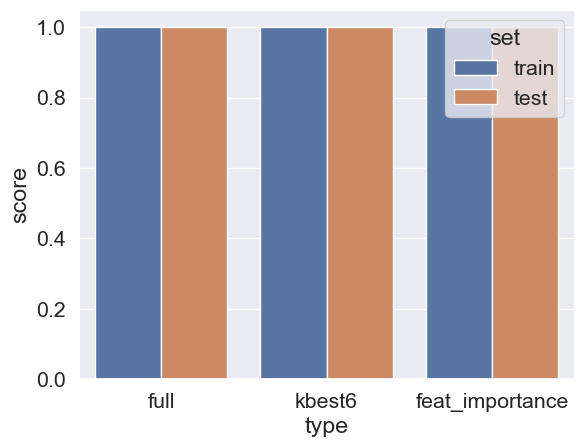

In [93]:
results_data_label = [
    { 'type': 'full', 'score': full_label_train, 'set': 'train' },
    { 'type': 'full', 'score': full_label_test, 'set': 'test' },
    { 'type': 'kbest6', 'score': kbest6_label_train, 'set': 'train' },
    { 'type': 'kbest6', 'score': kbest6_label_test, 'set': 'test' },
    { 'type': 'feat_importance', 'score': feat_importance_label_train, 'set': 'train' },
    { 'type': 'feat_importance', 'score': feat_importance_label_test, 'set': 'test' },
]

label_data = pd.DataFrame(results_data_label)
print(label_data)

sns.barplot(data=label_data, x="type", y="score", hue="set")

              type     score    set
0             full  0.998032  train
1             full  0.911983   test
2           kbest6  0.878969  train
3           kbest6  0.764707   test
4  feat_importance  0.995964  train
5  feat_importance  0.740533   test


<AxesSubplot:xlabel='type', ylabel='score'>

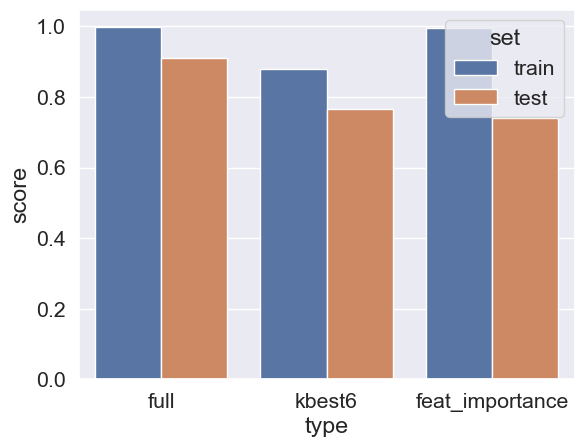

In [94]:
results_data_attack = [
    { 'type': 'full', 'score': full_attack_train, 'set': 'train' },
    { 'type': 'full', 'score': full_attack_test, 'set': 'test' },
    { 'type': 'kbest6', 'score': kbest6_attack_train, 'set': 'train' },
    { 'type': 'kbest6', 'score': kbest6_attack_test, 'set': 'test' },
    { 'type': 'feat_importance', 'score': feat_importance_attack_train, 'set': 'train' },
    { 'type': 'feat_importance', 'score': feat_importance_attack_test, 'set': 'test' },
]

attack_data = pd.DataFrame(results_data_attack)
print(attack_data)

sns.barplot(data=attack_data, x="type", y="score", hue="set")

In [101]:
forest_importances.index

Index(['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'L4_DST_PORT', 'L4_SRC_PORT',
       'L7_PROTO_NAME', 'MAX_IP_PKT_LEN', 'TCP_WIN_MAX_IN',
       'FLOW_DURATION_MILLISECONDS', 'SRC_TO_DST_SECOND_BYTES_MEAN',
       'TCP_WIN_MAX_OUT', 'SRC_TO_DST_SECOND_BYTES_TOTAL', 'IN_BYTES',
       'TCP_FLAGS', 'DST_TO_SRC_SECOND_BYTES_TOTAL', 'IN_PKTS', 'OUT_BYTES',
       'OUT_PKTS', 'RETRANSMITTED_OUT_PKTS', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_IN_BYTES', 'DST_TO_SRC_SECOND_BYTES_MEAN',
       'RETRANSMITTED_OUT_BYTES', 'MIN_IP_PKT_LEN', 'PROTOCOL'],
      dtype='object')

In [194]:
available_cols = list(forest_importances.index)
cols = []
data = []

for col in available_cols:
    cols.append(col)

    X = dataset[cols]
    y = dataset.AttackEnc
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

    model = RandomForestClassifier(random_state=2022)
    model.fit(X_train, y_train)

    score_train = f1_score(y_train, model.predict(X_train), average='macro')
    score_test = f1_score(y_test, model.predict(X_test), average='macro')
    cols_str = ','.join(cols)
    data.append({
        'n_cols': len(cols),
        'score': score_train,
        'set': 'train',
        'cols': cols_str
    })
    data.append({
        'n_cols':len(cols),
        'score': score_test,
        'set': 'test',
        'cols': cols_str
    })

    print(cols)
    print("TRAIN F1-SCORE:", score_train)
    print("TEST F1-SCORE:", score_test)
    print("\n")
    

['L4_SRC_PORT']
TRAIN F1-SCORE: 0.2308919928256596
TEST F1-SCORE: 0.15440266250177725


['L4_SRC_PORT', 'TCP_WIN_MAX_IN']
TRAIN F1-SCORE: 0.7156252075459015
TEST F1-SCORE: 0.36366535612649525


['L4_SRC_PORT', 'TCP_WIN_MAX_IN', 'MAX_IP_PKT_LEN']
TRAIN F1-SCORE: 0.9682637420893897
TEST F1-SCORE: 0.6011134973558332


['L4_SRC_PORT', 'TCP_WIN_MAX_IN', 'MAX_IP_PKT_LEN', 'L7_PROTO_NAME']
TRAIN F1-SCORE: 0.9702023009811155
TEST F1-SCORE: 0.649557654945122


['L4_SRC_PORT', 'TCP_WIN_MAX_IN', 'MAX_IP_PKT_LEN', 'L7_PROTO_NAME', 'L4_DST_PORT']
TRAIN F1-SCORE: 0.9722024051618894
TEST F1-SCORE: 0.6436367341500484


['L4_SRC_PORT', 'TCP_WIN_MAX_IN', 'MAX_IP_PKT_LEN', 'L7_PROTO_NAME', 'L4_DST_PORT', 'MIN_IP_PKT_LEN']
TRAIN F1-SCORE: 0.9722936331384731
TEST F1-SCORE: 0.6570607349582781


['L4_SRC_PORT', 'TCP_WIN_MAX_IN', 'MAX_IP_PKT_LEN', 'L7_PROTO_NAME', 'L4_DST_PORT', 'MIN_IP_PKT_LEN', 'FLOW_DURATION_MILLISECONDS']
TRAIN F1-SCORE: 0.9733900999538246
TEST F1-SCORE: 0.6658809439867657


['L4_SRC_PORT

<AxesSubplot:xlabel='n_cols', ylabel='score'>

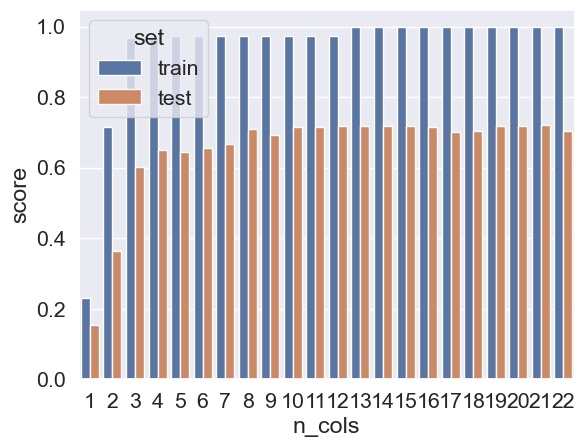

In [195]:
data_pd = pd.DataFrame(data)
sns.barplot(data=data_pd, x="n_cols", y="score", hue="set")

In [115]:
data_pd[data_pd.n_cols == 7].cols.values


array(['IPV4_DST_ADDR,IPV4_SRC_ADDR,L4_DST_PORT,L4_SRC_PORT,L7_PROTO_NAME,MAX_IP_PKT_LEN,TCP_WIN_MAX_IN',
       'IPV4_DST_ADDR,IPV4_SRC_ADDR,L4_DST_PORT,L4_SRC_PORT,L7_PROTO_NAME,MAX_IP_PKT_LEN,TCP_WIN_MAX_IN'],
      dtype=object)

In [114]:
data_pd[data_pd.n_cols == 14].cols.values

array(['IPV4_DST_ADDR,IPV4_SRC_ADDR,L4_DST_PORT,L4_SRC_PORT,L7_PROTO_NAME,MAX_IP_PKT_LEN,TCP_WIN_MAX_IN,FLOW_DURATION_MILLISECONDS,SRC_TO_DST_SECOND_BYTES_MEAN,TCP_WIN_MAX_OUT,SRC_TO_DST_SECOND_BYTES_TOTAL,IN_BYTES,TCP_FLAGS,DST_TO_SRC_SECOND_BYTES_TOTAL',
       'IPV4_DST_ADDR,IPV4_SRC_ADDR,L4_DST_PORT,L4_SRC_PORT,L7_PROTO_NAME,MAX_IP_PKT_LEN,TCP_WIN_MAX_IN,FLOW_DURATION_MILLISECONDS,SRC_TO_DST_SECOND_BYTES_MEAN,TCP_WIN_MAX_OUT,SRC_TO_DST_SECOND_BYTES_TOTAL,IN_BYTES,TCP_FLAGS,DST_TO_SRC_SECOND_BYTES_TOTAL'],
      dtype=object)

In [117]:
cols

['IPV4_DST_ADDR',
 'IPV4_SRC_ADDR',
 'L4_DST_PORT',
 'L4_SRC_PORT',
 'L7_PROTO_NAME',
 'MAX_IP_PKT_LEN',
 'FLOW_DURATION_MILLISECONDS',
 'SRC_TO_DST_SECOND_BYTES_MEAN',
 'TCP_WIN_MAX_OUT',
 'SRC_TO_DST_SECOND_BYTES_TOTAL',
 'IN_BYTES',
 'TCP_FLAGS',
 'DST_TO_SRC_SECOND_BYTES_TOTAL']

In [4]:
dataset, ae, l7pe = prepare_dataset(df)

NameError: name 'prepare_dataset' is not defined

In [189]:

#cols = ['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'L7_PROTO_NAME', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN', 'L4_DST_PORT', 'TCP_WIN_MAX_IN', 'FLOW_DURATION_MILLISECONDS', 'MIN_IP_PKT_LEN', 'TCP_WIN_MAX_OUT', 'SRC_TO_DST_SECOND_BYTES_MEAN', 'IN_BYTES', 'SRC_TO_DST_SECOND_BYTES_TOTAL', 'IN_PKTS', 'PROTOCOL', 'TCP_FLAGS', 'RETRANSMITTED_IN_BYTES']
cols = ['L7_PROTO_NAME', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN', 'L4_DST_PORT', 'TCP_WIN_MAX_IN', 'FLOW_DURATION_MILLISECONDS', 'MIN_IP_PKT_LEN', 'TCP_WIN_MAX_OUT', 'SRC_TO_DST_SECOND_BYTES_MEAN', 'IN_BYTES', 'SRC_TO_DST_SECOND_BYTES_TOTAL', 'IN_PKTS', 'PROTOCOL', 'TCP_FLAGS']

X = dataset['IN_BYTES'] #.drop(columns=['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Label', 'AttackEnc', 'Attack'], axis=1)
y = dataset.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

model = RandomForestClassifier(random_state=2022)
model.fit(X_train, y_train)

score_train = f1_score(y_train, model.predict(X_train), average='macro')
score_test = f1_score(y_test, model.predict(X_test), average='macro')

print("TRAIN F1-SCORE:", score_train)
print("TEST F1-SCORE:", score_test)

TRAIN F1-SCORE: 0.9858145003431732
TEST F1-SCORE: 0.9858498595952319


In [190]:

#cols = ['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'L7_PROTO_NAME', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN', 'L4_DST_PORT', 'TCP_WIN_MAX_IN', 'FLOW_DURATION_MILLISECONDS', 'MIN_IP_PKT_LEN', 'TCP_WIN_MAX_OUT', 'SRC_TO_DST_SECOND_BYTES_MEAN', 'IN_BYTES', 'SRC_TO_DST_SECOND_BYTES_TOTAL', 'IN_PKTS', 'PROTOCOL', 'TCP_FLAGS', 'RETRANSMITTED_IN_BYTES']
cols = ['L7_PROTO_NAME', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN', 'L4_DST_PORT', 'TCP_WIN_MAX_IN', 'FLOW_DURATION_MILLISECONDS', 'MIN_IP_PKT_LEN', 'TCP_WIN_MAX_OUT', 'SRC_TO_DST_SECOND_BYTES_MEAN', 'IN_BYTES', 'SRC_TO_DST_SECOND_BYTES_TOTAL', 'IN_PKTS', 'PROTOCOL', 'TCP_FLAGS']

X = dataset[cols] #.drop(columns=['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'Label', 'AttackEnc', 'Attack'], axis=1)
y = dataset.AttackEnc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

model = RandomForestClassifier(random_state=2022)
model.fit(X_train, y_train)

score_train = f1_score(y_train, model.predict(X_train), average='macro')
score_test = f1_score(y_test, model.predict(X_test), average='macro')

print("TRAIN F1-SCORE:", score_train)
print("TEST F1-SCORE:", score_test)

KeyboardInterrupt: 

In [9]:
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score

nums = dataset.select_dtypes(include=np.number)

#cols = ['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'L7_PROTO_NAME', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN', 'L4_DST_PORT', 'TCP_WIN_MAX_IN', 'FLOW_DURATION_MILLISECONDS', 'MIN_IP_PKT_LEN', 'TCP_WIN_MAX_OUT', 'SRC_TO_DST_SECOND_BYTES_MEAN', 'IN_BYTES', 'SRC_TO_DST_SECOND_BYTES_TOTAL', 'IN_PKTS', 'PROTOCOL', 'TCP_FLAGS', 'RETRANSMITTED_IN_BYTES']
# cols = ['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'L7_PROTO_NAME', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN', 'L4_DST_PORT', 'TCP_WIN_MAX_IN', 'FLOW_DURATION_MILLISECONDS', 'MIN_IP_PKT_LEN', 'TCP_WIN_MAX_OUT', 'SRC_TO_DST_SECOND_BYTES_MEAN', 'IN_BYTES', 'SRC_TO_DST_SECOND_BYTES_TOTAL', 'IN_PKTS', 'PROTOCOL', 'TCP_FLAGS']
cols = ['L4_SRC_PORT', 'TCP_WIN_MAX_IN', 'MAX_IP_PKT_LEN', 'L7_PROTO_NAME', 'L4_DST_PORT', 'MIN_IP_PKT_LEN', 'FLOW_DURATION_MILLISECONDS', 'IN_BYTES', 'TCP_WIN_MAX_OUT', 'SRC_TO_DST_SECOND_BYTES_TOTAL', 'SRC_TO_DST_SECOND_BYTES_MEAN', 'IN_PKTS']

X = nums[cols]
y = nums.AttackEnc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)
models = [
    {'name': 'knn', 'model': KNeighborsClassifier(n_neighbors=5)},
    #{'name': 'svm', 'model': SVC()},
    {'name': 'naivebayes', 'model': GaussianNB()},
    {'name': 'random_forets', 'model': RandomForestClassifier(random_state=2022)},
]
data = []

for m in models:
    model = m['model']
    model.fit(X_train, y_train)
    score_train = f1_score(y_train, model.predict(X_train), average='macro')
    score_test = f1_score(y_test, model.predict(X_test), average='macro')

    data.append({
        'train': score_train,
        'test': score_test,
        'model': m['name'],
    })

    print("MODEL:", m['name'])
    print("TRAIN F1-SCORE:", score_train)
    print("TEST F1-SCORE:", score_test)

# model = RandomForestClassifier(random_state=2022)
# model.fit(X_train, y_train)

# score_train = f1_score(y_train, model.predict(X_train), average='macro')
# score_test = f1_score(y_test, model.predict(X_test), average='macro')

# print("TRAIN F1-SCORE:", score_train)
# print("TEST F1-SCORE:", score_test)
cols

MODEL: knn
TRAIN F1-SCORE: 0.5098862888109812
TEST F1-SCORE: 0.5598415468480601
MODEL: naivebayes
TRAIN F1-SCORE: 0.05571949846471774
TEST F1-SCORE: 0.0510917244894982
MODEL: random_forets
TRAIN F1-SCORE: 0.9742441372209054
TEST F1-SCORE: 0.7182198776827439


['L4_SRC_PORT',
 'TCP_WIN_MAX_IN',
 'MAX_IP_PKT_LEN',
 'L7_PROTO_NAME',
 'L4_DST_PORT',
 'MIN_IP_PKT_LEN',
 'FLOW_DURATION_MILLISECONDS',
 'IN_BYTES',
 'TCP_WIN_MAX_OUT',
 'SRC_TO_DST_SECOND_BYTES_TOTAL',
 'SRC_TO_DST_SECOND_BYTES_MEAN',
 'IN_PKTS']

In [178]:
from sklearn.metrics import f1_score

nums = dataset.select_dtypes(include=np.number)

#cols = ['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'L7_PROTO_NAME', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN', 'L4_DST_PORT', 'TCP_WIN_MAX_IN', 'FLOW_DURATION_MILLISECONDS', 'MIN_IP_PKT_LEN', 'TCP_WIN_MAX_OUT', 'SRC_TO_DST_SECOND_BYTES_MEAN', 'IN_BYTES', 'SRC_TO_DST_SECOND_BYTES_TOTAL', 'IN_PKTS', 'PROTOCOL', 'TCP_FLAGS', 'RETRANSMITTED_IN_BYTES']
cols = ['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'L7_PROTO_NAME', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN', 'L4_DST_PORT', 'TCP_WIN_MAX_IN', 'FLOW_DURATION_MILLISECONDS', 'MIN_IP_PKT_LEN', 'TCP_WIN_MAX_OUT', 'SRC_TO_DST_SECOND_BYTES_MEAN', 'IN_BYTES', 'SRC_TO_DST_SECOND_BYTES_TOTAL', 'IN_PKTS', 'PROTOCOL', 'TCP_FLAGS']

X = nums[cols]
y = nums.AttackEnc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

model = RandomForestClassifier(random_state=2022)
model.fit(X_train, y_train)

score_train = f1_score(y_train, model.predict(X_train), average='macro')
score_test = f1_score(y_test, model.predict(X_test), average='macro')

print("TRAIN F1-SCORE:", score_train)
print("TEST F1-SCORE:", score_test)
cols

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [29]:
cols = ['L4_SRC_PORT', 'TCP_WIN_MAX_IN', 'MAX_IP_PKT_LEN', 'L7_PROTO_NAME', 'L4_DST_PORT', 'MIN_IP_PKT_LEN', 'FLOW_DURATION_MILLISECONDS', 'IN_BYTES', 'TCP_WIN_MAX_OUT', 'SRC_TO_DST_SECOND_BYTES_TOTAL', 'SRC_TO_DST_SECOND_BYTES_MEAN', 'IN_PKTS']

X = dataset[cols]
y = dataset.Label

model_l = RandomForestClassifier(random_state=2022)
model_l.fit(X, y)
X = dataset[cols]
y = dataset.AttackEnc

model_a = RandomForestClassifier(random_state=2022)
model_a.fit(X, y)

RandomForestClassifier(random_state=2022)

In [158]:
l7pe.transform(['tcp'])

ValueError: y contains previously unseen labels: 'tcp'

In [199]:

filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))

In [197]:
import pickle

filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))
filename = 'attack_encoder.sav'
pickle.dump(ae, open(filename, 'wb'))
filename = 'l7_pn.sav'
pickle.dump(l7pe, open(filename, 'wb'))
filename = 'columns.sav'
pickle.dump(cols, open(filename, 'wb'))

In [10]:
data

[{'train': 0.5098862888109812, 'test': 0.5598415468480601, 'model': 'knn'},
 {'train': 0.05571949846471774,
  'test': 0.0510917244894982,
  'model': 'naivebayes'},
 {'train': 0.9742441372209054,
  'test': 0.7182198776827439,
  'model': 'random_forets'}]

In [12]:
d = []

for D in data:
    d.append({
        'modelo': D['model'],
        'score': D['train'],
        'set': 'train',
    })
    d.append({
        'modelo': D['model'],
        'score': D['test'],
        'set': 'test',
    })

d

[{'modelo': 'knn', 'score': 0.5098862888109812, 'set': 'train'},
 {'modelo': 'knn', 'score': 0.5598415468480601, 'set': 'test'},
 {'modelo': 'naivebayes', 'score': 0.05571949846471774, 'set': 'train'},
 {'modelo': 'naivebayes', 'score': 0.0510917244894982, 'set': 'test'},
 {'modelo': 'random_forets', 'score': 0.9742441372209054, 'set': 'train'},
 {'modelo': 'random_forets', 'score': 0.7182198776827439, 'set': 'test'}]

<AxesSubplot:xlabel='modelo', ylabel='score'>

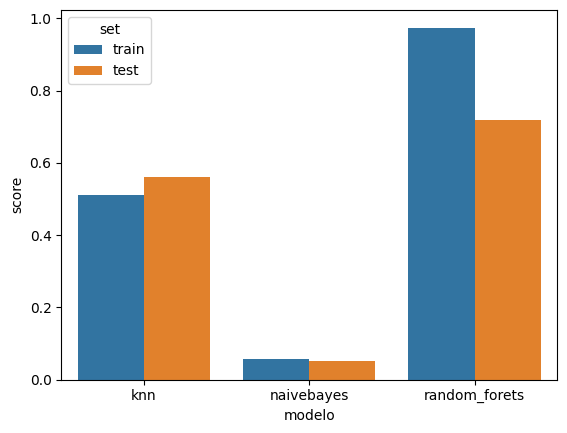

In [14]:
attack_data = pd.DataFrame(d)

sns.barplot(data=attack_data, x="modelo", y="score", hue="set")

TRAIN F1-SCORE: 0.9239164313654102
TEST F1-SCORE: 0.9971193693197322
[{'score': 0.9999729166645873, 'set': 'train', 'label': 'label'}, {'score': 0.9994083325394718, 'set': 'test', 'label': 'label'}, {'score': 0.9742441372209054, 'set': 'train', 'label': 'attack'}, {'score': 0.7182198776827439, 'set': 'test', 'label': 'attack'}]


<AxesSubplot:xlabel='label', ylabel='score'>

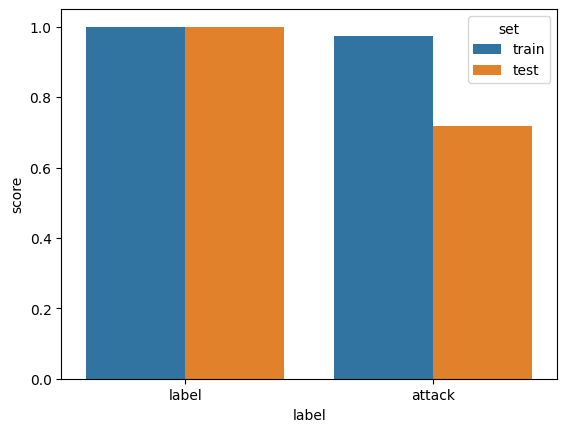

In [31]:
import pickle
forest_lbl = pickle.load(open('model.sav', 'rb'))
forest_atk = pickle.load(open('model_attack.sav', 'rb'))

cols = ['L4_SRC_PORT', 'TCP_WIN_MAX_IN', 'MAX_IP_PKT_LEN', 'L7_PROTO_NAME', 'L4_DST_PORT', 'MIN_IP_PKT_LEN', 'FLOW_DURATION_MILLISECONDS', 'IN_BYTES', 'TCP_WIN_MAX_OUT', 'SRC_TO_DST_SECOND_BYTES_TOTAL', 'SRC_TO_DST_SECOND_BYTES_MEAN', 'IN_PKTS']

X = nums[cols]
y = nums.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)


model_l = RandomForestClassifier(random_state=2022)
model_l.fit(X_train, y_train)

res = [
    { 'score': f1_score(y_train, model_l.predict(X_train), average='macro'), 'set': 'train', 'label': 'label'},
    { 'score': f1_score(y_test, model_l.predict(X_test), average='macro'), 'set': 'test', 'label': 'label' },
]

X = nums[cols]
y = nums.AttackEnc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

model_a = RandomForestClassifier(random_state=2022)
model_a.fit(X_train, y_train)

res.append(
    { 'score': f1_score(y_train, model_a.predict(X_train), average='macro'), 'set': 'train', 'label': 'attack'}
)
res.append(
    { 'score': f1_score(y_test, model_a.predict(X_test), average='macro'), 'set': 'test', 'label': 'attack' },)

score_train = f1_score(y_train, forest_atk.predict(X_train), average='macro')
score_test = f1_score(y_test, forest_atk.predict(X_test), average='macro')

print("TRAIN F1-SCORE:", score_train)
print("TEST F1-SCORE:", score_test)
attack_data = pd.DataFrame(res)

print(res)

sns.barplot(data=attack_data, x="label", y="score", hue="set")


<AxesSubplot:xlabel='Attack', ylabel='Count'>

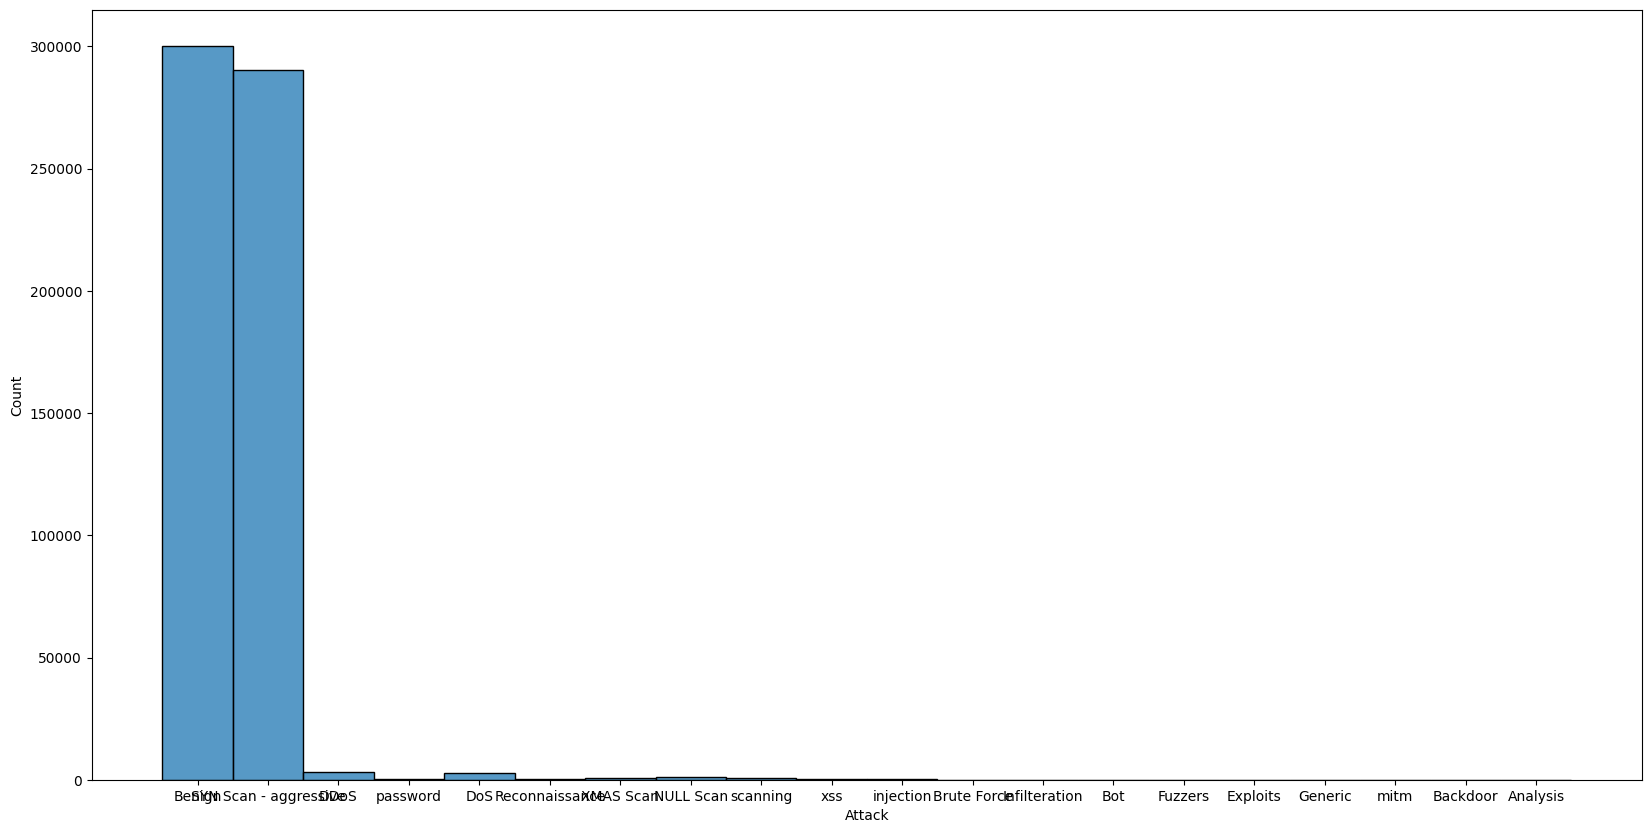

In [33]:
fig = plt.figure(1, figsize=[20,10])
sns.histplot(df, x='Attack')

In [36]:
a = forest_atk.predict(X_test)
np.unique(a)

array([ 1,  2,  3,  4,  5,  6,  9, 10, 11, 12, 13, 14, 15, 17, 18, 19])

<AxesSubplot:ylabel='Count'>

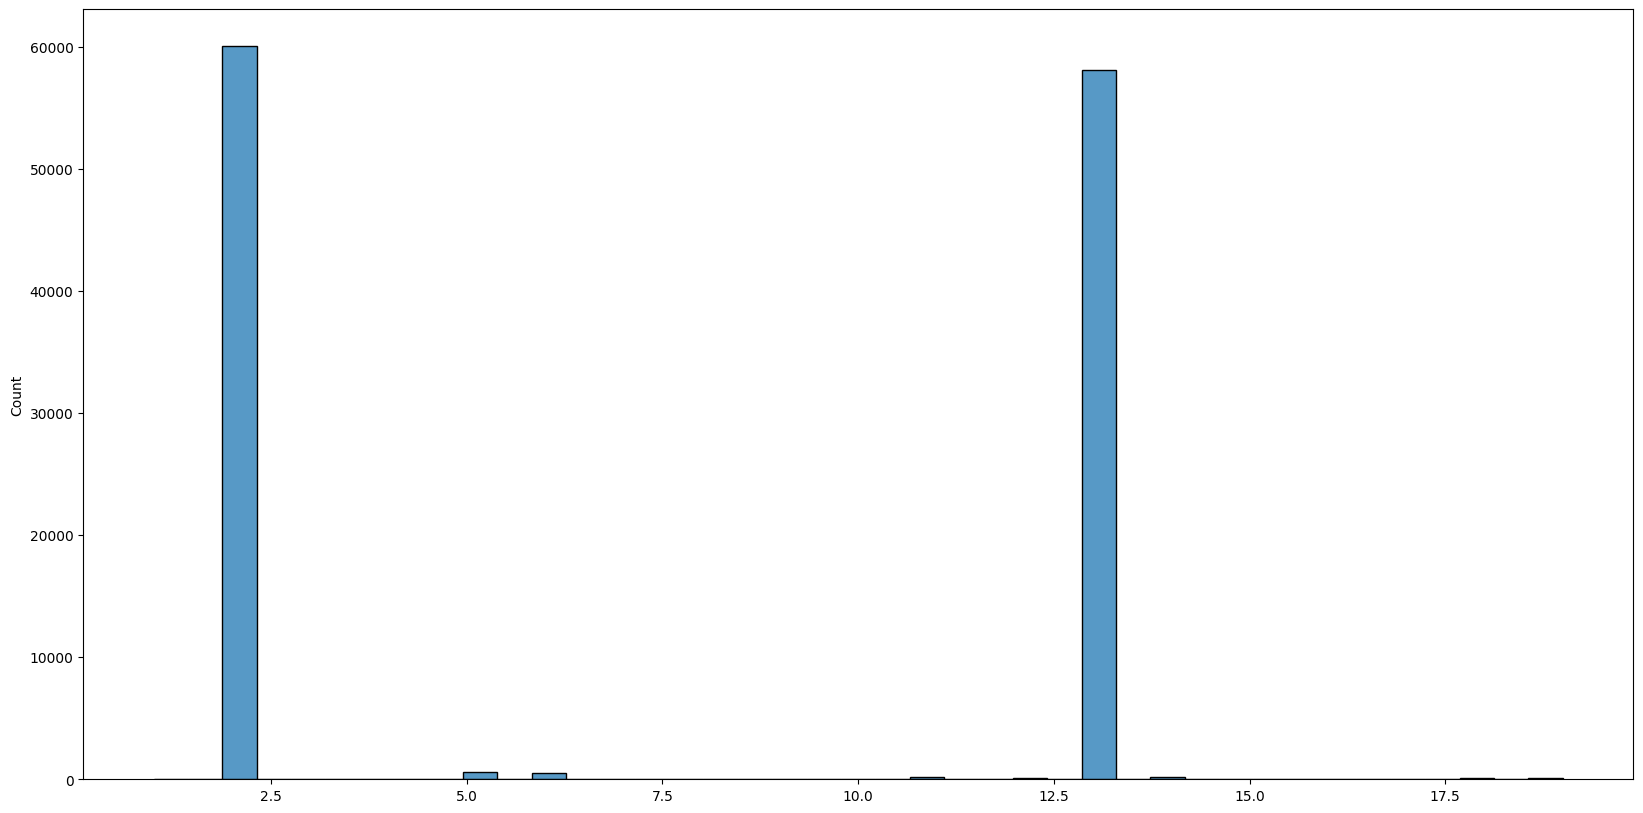

In [37]:
fig = plt.figure(1, figsize=[20,10])
sns.histplot(a)